In [1]:
import numpy as np
import pandas as pd
import torch
import os
import time 
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(font_scale=1)


from SimulationResult import SimulationResult

## Singleton Estimation

We want to estimate the number of singletons that we can expect to have for skeleton tree reconstruction

<b> Variables to Consider:</b>

- num_targets - number of potential target sites 
- mut_rate - mutation rate per target site
- edit_distribution - distribution over potential edits per target site

<hr>

<b> Simulation Formulation </b>

We begin each simulation with one cell, representing the fertilised egg, that has all its targets in an unmutated state. The initial cell then undergoes a series of cell divisions (d), growing into a population of N cells, where $N=2^d$. Following each cell division, each unmutated target can mutate (with a given probability μd) to one of several possible mutated states. Once a target is mutated, it can no longer change, either to revert to the unmutated state or to transit to a new state.


<b> Useful References </b>

<sub> [1]https://elifesciences.org/articles/40292


</sub>

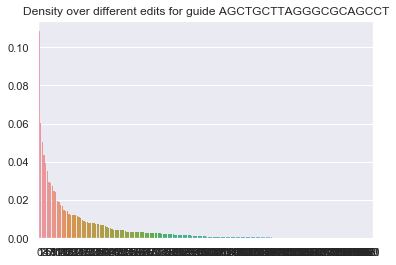

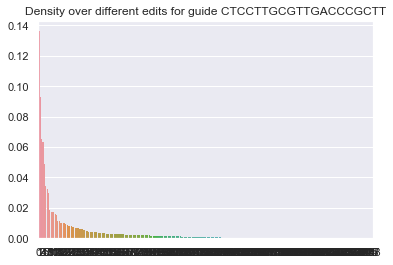

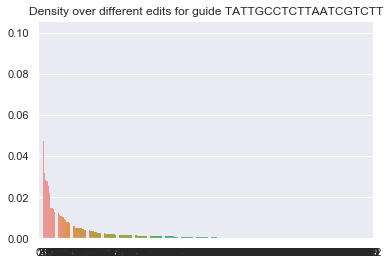

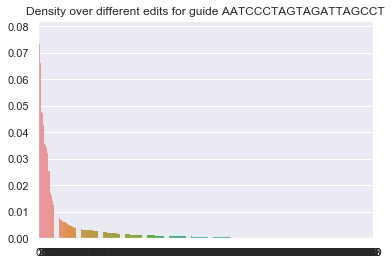

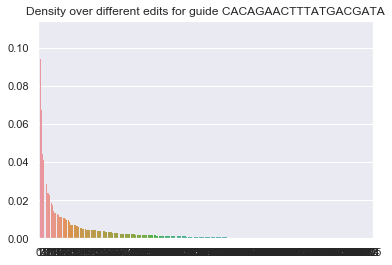

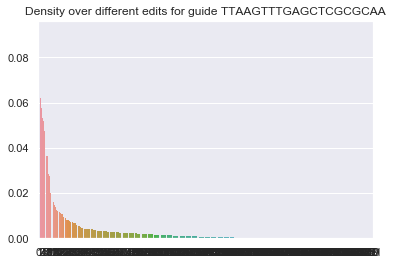

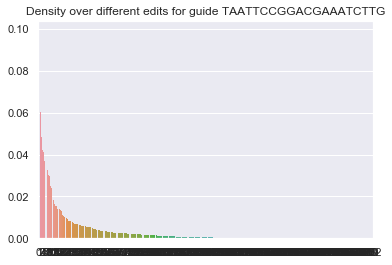

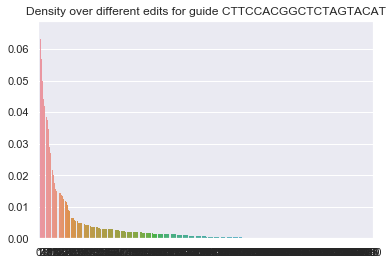

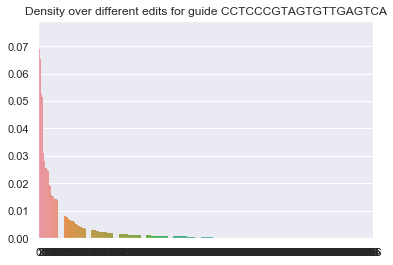

In [2]:
## How many cells does the real data end up with?
## Did this seed from one cell? 

import pickle
with open('/Users/sitarapersad/Downloads/d21_indel_distributions.p', 'rb') as f:
    indel_distributions = pickle.load(f)

slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']

for li in [slow_guides, medium_guides, fast_guides]:
    for guide in li:
        dist = indel_distributions[guide]
        try:
            del dist['']
        except KeyError:
            pass
        distvals = np.array(sorted(list(dist.values()), reverse=True))
        distvals = distvals/distvals.sum()
        plt.figure()
        sns.barplot(np.arange(len(distvals)), distvals, linewidth=0)
        plt.title('Density over different edits for guide {0}'.format(guide))
        plt.show()
        plt.close()

# Estimate the mutation probability

# For a given site E_i[%] = E_{i-1}[%] + p(1-E_{i-1}[%])
# E_i = 1-q^i, where q = 1-p 
# Sanity check: 
# E_0 = 1-(1-p)^0 = 0 
# E_1 = 1-(1-p) = p 

# We can choose to use a combination of varying speed guides 

# 4, 7, 14, 21 days -> 4 generations, 7 generations etc (24 hrs for cell cycle?)

# How many generations does 1 day correspond to?
# Slow guides:
slow = [0.09, 0.15, 0.29, 0.4]

# Medium guides
medium = [0.15, 0.35, 0.6, 0.75]

# Fast guides
fast = [0.75, 0.9, 0.95, 0.96]




In [3]:
gens = [4,7,14,21]
print('\nSlow')
p_avg = 0
for i, x in enumerate(slow):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nMedium')
p_avg = 0
for i, x in enumerate(medium):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nFast')
p_avg = 0
for i, x in enumerate(fast):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)    

""" 
Questions
1. tree or forest
2. are the rates based on isolating a clone or from a forest
3. yosef lab was a single tree?? no

try this instead: 
start with many roots (a forest)

reproduction rate varying / same ?vfr 

"""


Slow
0.02330188829047808
0.02294954933760507
0.02416678505263603
0.024031560532588148
Avg
0.02361244580332683

Medium
0.03981541059581217
0.05968505934696777
0.06335350204906998
0.0638822575463951
Avg
0.056684057384561254

Fast
0.2928932188134524
0.28031432699884795
0.19263617565013524
0.14211035031316765
Avg
0.22698851794390082


' \nQuestions\n1. tree or forest\n2. are the rates based on isolating a clone or from a forest\n3. yosef lab was a single tree?? no\n\ntry this instead: \nstart with many roots (a forest)\n\nreproduction rate varying / same ?vfr \n\n'

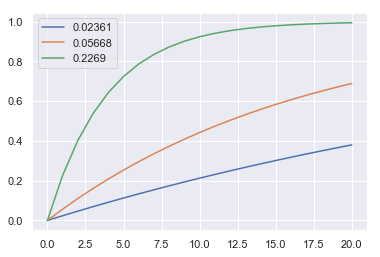

In [4]:
plt.figure()
for p in [0.02361, 0.05668, 0.2269]:
    q = 1-p
    plt.plot(np.arange(21), 1-q**np.arange(21), label=p)
plt.legend()
plt.show()
plt.close()

rate = {}
rate['slow'] = 0.02361
rate['medium'] = 0.05668
rate['fast'] = 0.2269

## Identifying Recurrent Mutations

Possibilities: 
1. Removal by most conflicts
2. Removal by f(conflicts, prevalence), f=??

In [5]:
def identify_recurrent(subsampled_record, recurring_edits, gen_occurred):
    # Test every pair of mutations and identify those which are in conflict
    final_cells = pd.DataFrame(subsampled_record[-1])
    print(final_cells.shape)
    x = final_cells.values

    import time
    t = time.time()
    # For each target site, access all the mutations
    muts = {}
    for col in range(x.shape[1]):
        unique_muts  = np.unique(x[:, col][x[:, col]!=0]) 

        m_list = []
        for m in unique_muts:
            count = (subsampled_record[-1][:, col] == m).sum(0)
            if count >= 2:
                m_list.append(m)
        muts[col] = m_list


    print('Time 1:', time.time()-t)
    # Iterate over all pairs of mutations and determine whether they are in conflict)
    conflicts_with = {}

    sites = list(muts.keys())
    n_sites = len(sites)

    t1 = time.time()
    # See 4-gamete test: A pair of mutations are in conflict if we observe A with B, A without B and B without A.
    for i in range(n_sites):
        for m1 in muts[i]:
            yes_cells = final_cells[final_cells[i] == m1]
            no_cells = final_cells[final_cells[i] != m1]

            for j in range(i+1, n_sites):

                x = set(yes_cells[j].drop_duplicates().values)
                y = set(no_cells[j].drop_duplicates().values)

                for m2 in muts[j]:
                    # Find all the cells that contain both A and B. If none exist, we move on.
                    if m2 not in x:
                        continue
                    # Find all the cells that contain only A. If none exist, we move on.
                    if len(x)==1:
                        continue
                    # Find all the cells that contain only B. If none exist, we move on.
                    if m2 not in y:
                        continue

                    A = (i,m1)
                    B = (j,m2)

                    # Mutations A and B are in conflict
                    conflicts_with[A] = conflicts_with.get(A, []) + [B]                
                    conflicts_with[B] = conflicts_with.get(B, []) + [A]

    print('Compute dictionary:', time.time()-t)          
    
    all_conflicting = list(conflicts_with.keys())
    num_conflicting = [len(conflicts_with[a]) for a in all_conflicting]

    mut_to_ix = {}
    ix_to_mut = {}
    i = 0
    for mut in all_conflicting:
        mut_to_ix[mut] = i
        ix_to_mut[i] = mut
        i += 1
    total_muts = i

    conflict_matrix = np.zeros((total_muts, total_muts))

    for m1 in conflicts_with:
        for m2 in conflicts_with[m1]:
            conflict_matrix[mut_to_ix[m1], mut_to_ix[m2]] = 1

    def check_symmetric(a, tol=1e-8):
        return np.all(np.abs(a-a.T) < tol)

    print('Conflict matrix is symmetric? ', check_symmetric(conflict_matrix))
    runtime = time.time()-t
    print('Total time:', runtime) 

    true = set(recurring_edits.keys())
    inferred = set(conflicts_with.keys())
    print('Number of true recurrent muts: ', len(true))
    print('Number of detected recurrent muts: ', len(inferred))
    undetected = true - true.intersection(inferred)
    prevalence = []
    for m in undetected:
        prevalence.append(sum(subsampled_record[-1][:, m[0]]==m[1]))
    print('Number of true recurrent muts not detected:', len(undetected), 'with prevalence', prevalence)

    # For each identified conflicting mutation, get the number of times it recurred
    num_recur_tape = np.zeros(total_muts)
    for mut in all_conflicting:
        num_recur_tape[mut_to_ix[mut]] = len(gen_occurred[mut])

    # For each identified conflicting mutation, get the generation the mutation first existed
    first_gen_tape = np.zeros(total_muts)
    for mut in all_conflicting:
        first_gen_tape[mut_to_ix[mut]] = gen_occurred[mut][0]

    # For each identified conflicting mutation, what is the prevalence in the final generation?
    prevalence_tape = np.zeros(total_muts)
    for mut in all_conflicting:
        prevalence_tape[mut_to_ix[mut]] = sum(subsampled_record[-1][:, mut[0]]==mut[1])

    # Identify which conflicting muts are true 
    truth = []
    for mut in all_conflicting:
        truth.append(int(mut in recurring_edits))

    sns.set(rc={'axes.facecolor':'gainsboro'})

    f, axes = plt.subplots(8, 1, sharex=True, gridspec_kw={'height_ratios': [5, 0.5, 1, 1, 1, 1, 1,1 ]}, figsize=(10,30))
    sns.heatmap(conflict_matrix, cmap='Paired', ax=axes[0], cbar_kws = dict(use_gridspec=False,location="top"))
    axes[0].set_title('Conflict Matrix')
    sns.heatmap([truth], cmap='Paired', ax=axes[1], cbar=False)
    axes[1].set_title('True Mutations')
    sns.heatmap([conflict_matrix.sum(0)], cmap=sns.color_palette("Blues"), ax=axes[2], cbar_kws = dict(use_gridspec=False,location="bottom"))
    axes[2].set_title('Number of Co-conflicting Mutations')

    axes[3].plot(num_recur_tape)
    axes[3].set_title('Number of Recurrences')

    axes[4].plot(first_gen_tape)
    axes[4].set_title('Generation of First Occurrence')

    axes[5].plot(prevalence_tape)
    axes[5].set_title('Prevalence in Final Generation')

    axes[6].plot(conflict_matrix.sum(0))
    axes[6].set_title('Number of Co-conflicts')
    axes[7].plot(truth, '*')
    axes[7].set_title('Truth')

    axes[7].set_xticklabels(axes[4].get_xticklabels(), rotation=75)
    plt.show()
    plt.close()



    df = {'truth':truth, 'truth_label': ['true_recurrent' if i else 'false_recurrent' for i in truth ], 'co-conflicts':conflict_matrix.sum(0), 
          'prevalence': prevalence_tape, 'first_occur': first_gen_tape, 'num_recur': num_recur_tape}
    df = pd.DataFrame(df)

    df['weighted_conflicts'] = (conflict_matrix * conflict_matrix.sum(0)).sum(0)
    pd.melt(df)

    g = sns.PairGrid(df, hue = 'truth_label', palette="Set2")
    g.map_diag(plt.hist)
    g.map_offdiag(plt.scatter)
    g.add_legend()
    g.fig.suptitle("Relationship Between Metrics", y=1) # y= some height>1
    plt.show()
    plt.close()

    return runtime, all_conflicting, conflict_matrix, truth, prevalence_tape, first_gen_tape, num_recur_tape  
    

## Greedy Tree Construction

    # Why does NJ take so long?? Try doing Camin Sokal or NJ as well 

In [6]:
def split_tree(x, min_cells = 10):
    """
    Warning! Modifies the object x
    """
    # Stop splitting if all the cells are the same or there are fewer than min_cells in the subtree 
    if x.shape[0] <= min_cells:
        x['Label']+='.'
        return x
    
    mode, counts = stats.mode(x.drop('Label',axis=1).values, axis=0, nan_policy = 'omit')
    counts = counts[0]
    mode = mode[0]
    col = np.argsort(counts)[-1]
    edit = mode[col]
    
    # Split tree into cells which contain this edit and those who don't
    ix = (x[col]==edit)
    contains = x.index[ix]
    not_contains = x.index[~ix]

    x.loc[contains,'Label'] += '1'
    x.loc[not_contains,'Label'] += '0'
    
    # Remove this edit (no need to use it again)
    x.loc[ix, col] = np.nan
    
    
    if np.nansum(x.drop('Label', axis=1).values) == 0:
        print('No more mutations to split on, returning.')
        return x 
    
    # Recurse on each individual subtree and label accordingly
    if len(contains) > 0:
        x.loc[contains] = split_tree(x.loc[contains]) 
    
    if len(not_contains) > 0:
        x.loc[not_contains] = split_tree(x.loc[not_contains])
    
    return x



<hr>
## Triplets correct statistic
To compare the similarity of simulated trees to reconstructed trees, we take an approach which compares the
sub-trees formed between triplets of the terminal states
across the two trees. To do this, we sample ∼ 10, 000
triplets from our simulated tree and compare the relative
orderings of each triplet to the reconstructed tree. We say
a triplet is “correct” if the orderings of the three terminal states are conserved across both trees. This approach
is different from other tree comparison statistics, such
as Robinson-Foulds [34], which measures the number of
edges that are similar between two trees.
To mitigate the effect of disproportionately sampling
triplets relatively close to the root of the tree, we calculate
the percentage of triplets correct across each depth within
the tree independently (depth measured by the distance
from the root to the latest common ancestor (LCA) of
the triplet). We then take the average of the percentage
triplets correct across all depths. To further reduce the
bias towards the few triplets that are sampled at levels
of the tree with very few cells (i.e., few possible triplets),
we modify this statistic to only take into account depths
where there at least 20 cells. We report these statistics
without this depth threshold in Additional file 1: Fig S8
           
Ordering -> Cells share common ancestors in the correct order:

{{AB}C} vs {A{BC}}



In [7]:
def compute_triplets_correct(final_cells_labeled, subsampled_ix, sample_size = 1000):
    def get_ordering(a,b,c):
        """
        Return which cell (A,B or C) was least related of the triplet.
        e.g.
             ___A    
         ____|
        |    |___B
        |    
        |________C

        returns C
        """

        # The last (least significant) digit which agree across cells is the depth of their most recent common ancestor

        max_depth = {}
        for i in range(min(len(a),len(b))):
            if a[i] != b[i]:
                max_depth['ab'] = i
                break

        for i in range(min(len(a),len(c))):
            if a[i] != c[i]:
                max_depth['ac'] = i
                break


        for i in range(min(len(c),len(b))):
            if c[i] != b[i]:
                max_depth['bc'] = i
                break

        vals = list(max_depth.values())
        max_val = max(vals)
        if len(set(vals)) == 1:
            # All are at same depth
            return '='
        elif max_depth['ac'] == max_val:
            return 'B'
        elif max_depth['bc'] == max_val:
            return 'A'
        if max_depth['ab'] == max_val:
            return 'C'

    def cell_ix_to_label(i):
        return (format(i-1, '#022b')[2:])

    num_correct = 0
    for _ in range(sample_size):
        # Randomly sample triplets (a,b,c) and determine the relative ordering of ancestry.
        # How many are consistent with the truth?
        ix = np.random.choice(np.arange(subsampled_ix.shape[0]), 3, replace=False)
        a,b,c = (cell_ix_to_label(i) for i in subsampled_ix[ix])
        truth = get_ordering(a,b,c)

        # Grab the corresponding cells from our final array
        a,b,c = final_cells_labeled['Label'].iloc[ix]
        inferred = get_ordering(a,b,c)

        if truth == inferred:
            num_correct += 1

    print('Proportion correct = ', num_correct/sample_size)
    
    return num_correct/sample_size

In [8]:
def performCRISPR(cell_recorder, 
                  num_edit_sites, 
                  reproduction_prob,
                  mutation_probs,
                  deletions_probs,
                  ):
            
    num_cells = cell_recorder.shape[0]

    # TODO: Will each cell divide? And at what rate? This should be considered
    reproducting = np.random.random((num_cells, num_edit_sites)) <= reproduction_prob

    # For each target, mutate with a fixed probability
    # This probability empirically estimated from MSKCC data with 
    # the assumption of fixed reproduction time.

    # An edit occurs if: 
    # (1) the probability drawn is sufficient and 
    mutating = np.random.random((num_cells, num_edit_sites)) <= mutation_probs

    # (2) the site is not already edited.
    not_edited = cell_recorder == 0 

    num_available_sites = not_edited.sum()

    edit_here = mutating & not_edited
    num_edits_made = edit_here.sum()

    novel_edits = edit_here
    if edit_here.sum() > 0:
        # For the cells and targets which are mutating, now draw a deletion 
        # from the distribution specific to that. Deletions are indexed starting at 1
        deletion_choice = 1 + torch.multinomial(torch.DoubleTensor(deletions_probs), num_cells, replacement=True).numpy().T
        deletion_choice[~edit_here] = 0
        novel_edits = deletion_choice 
#         sites, cells = np.where(deletion_choice !=0)

#         site_edits = list(zip(sites, deletion_choice[(sites, cells)]))
#         intersection = edits_occurred.intersection(site_edits)

#         for edit in intersection:
#             if verbose:
#                 print('{0} already occurred before {1}'.format(edit, i))
#             # If a sampled (target, deletion) has already occurred, 
#             # then note the tree depth before we have 'convergent' evolution
#             convergence[edit] = convergence.get(edit, []) + [i]
#             if np.isnan(min_depth):
#                 min_depth = i

#         # Update the list of (target, deletions) that have already occurred.
#         edits_occurred = edits_occurred.union(site_edits)    

        cell_recorder += deletion_choice 

    # New cell_recorder has double the entries after replication
    # TODO: Only allow some cells to replicate    
    cell_recorder = np.repeat(cell_recorder, 2, axis=0)

    return cell_recorder, novel_edits, num_available_sites, num_edits_made

In [9]:
def lineageSimulation(label, tree_depth, num_sites, deletions_probs, mutation_probs, compute_tree=False):

    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, 'figure.figsize':(20, 10)})
    
    start = time.time()
    simulation = SimulationResult(label, tree_depth, num_sites, run=None)
    
    # TODO: Fix this reproduction probability
    reproduction_prob = 1.0 
    
    # Simulating a tree: we start out with a single cell which is unmutated
    cell_recorder = np.zeros((1, num_edit_sites))
    min_depth = np.nan
    record = [cell_recorder]

    available_sites = []
    edits_made = []
    edit_record = []
    
    # Not needed??
    edits_occurred = set([])
    convergence = {}
    
    for i in range(tree_depth):
        # One round of CRISPR may happen between this generation's division and the previous generation
        cell_recorder, novel_edits, num_available_sites, num_edits_made = performCRISPR(cell_recorder, 
                                                                                      num_edit_sites, 
                                                                                      reproduction_prob,
                                                                                      mutation_probs,
                                                                                      deletions_probs,
                                                                                      )

        available_sites.append(num_available_sites)
        edits_made.append(num_edits_made)
        
        record.append(cell_recorder)
        edit_record.append(novel_edits)
        
    simulation.add_full_cell_record(record)
    simulation.add_full_edit_record(edit_record)
    
    # Plot some dynamics of full simulation

    simulation.add_full_open_sites(available_sites)
    simulation.plot_full_open_sites()
    
    simulation.add_full_edits_made(edits_made)
    simulation.plot_full_edits_made()
    
    # Subsample cells 
    subsampled_ix = np.random.choice(cell_recorder.shape[0], n_subsample, replace=False)
    
    # We only care about the ancestors of these subsampled cells
    subsampled_record = []
    level_ix = subsampled_ix
    for i, ix in enumerate(range(len(record)-1, -1, -1)):
        rec = record[ix]
        subsampled_record.append(rec[level_ix, :])
        level_ix = pd.unique(level_ix//2)
    subsampled_record.reverse()
    
    simulation.add_subsampled_ix(subsampled_ix)
    simulation.add_cell_record(subsampled_record)
    
    # We also only care about edits related to these subsampled cells
    # The edit at index i corresponds to the parents of the cells at 2i, 2i+1 in the level below
    level_ix = subsampled_ix
    subsampled_edits = []
    for rec in reversed(edit_record):
        level_ix = pd.unique(level_ix//2)
        subsampled_edits.append(rec[level_ix, :])
    subsampled_edits.reverse()
    
    simulation.add_edit_record(subsampled_edits)
    
    # Plot the number of mutations that occurred per generation
    simulation.plot_edits_made()
    
    # Plot the character matrix of the final 
    simulation.plot_character_matrix()
    
    # Plot various dynamics of subsampled tree
    simulation.plot_subsampled_growth_curve()
    simulation.plot_unique_cells()
    
    # Plot the number of available sites per generation 
    simulation.plot_open_sites()
    final_cells = simulation.compute_final_cells()
    
    
    # Investigating number of singletons, recurrent mutations and 'good' mutations 
    recurring_edits = {} # Mapping (site, deletion) to a list of generations where the mutation reoccured. 
    gen_occurred = {}
    for gen in range(1, tree_depth):
        rows, cols = np.where(subsampled_edits[gen]!=0)
        edits = subsampled_edits[gen][np.where(subsampled_edits[gen]!=0)]
        for col, edit in zip(cols, edits):
            # Track the generation that each mutation occurred
            gen_occurred[(col,edit)] = gen_occurred.get((col, edit), []) + [gen]
            # Track only recurrent mutations
            if ((subsampled_record[gen - 1 ][:, col] == edit).sum()) > 0:
                # Add this (position, deletion) pair to the list of recurring muts
                recurring_edits[(col, edit)] = recurring_edits.get((col, edit), []) + [gen]
                
                
    plt.figure()
    plt.suptitle('Subsampled - Number of Occurrences for Repeated Mutations')
    total = 0
    for x in gen_occurred:
        if len(gen_occurred[x])==1:
            total+=1
    plt.title('Number of Unique Muts: {0}'.format(total))
    repeated = [len(x) for x in recurring_edits.values()]
    plt.hist(repeated, bins=len(repeated))
    plt.ylabel('Count')
    plt.xlabel('Number of Occurrences')
    plt.show()
    
    if compute_tree:
        final_cells = copy.deepcopy(pd.DataFrame(subsampled_record[-1]))
        final_cells['Label'] = '1'
        final_cells_labeled = split_tree(final_cells)
        final_cells = copy.deepcopy(pd.DataFrame(subsampled_record[-1]))
        final_cells['Label'] = '1'
        compute_triplets_correct(final_cells_labeled, subsampled_ix, sample_size = 1000)

    # Plot the tests for identifying recurrent mutations 
    result = identify_recurrent(subsampled_record, recurring_edits, gen_occurred)
    runtime, all_conflicting, conflict_matrix, truth_tape, prevalence_tape, first_gen_tape, num_recur_tape = result 
    
    print(first_gen_tape)
    
    simulation.add_conflict_matrix(conflict_matrix)
    simulation.add_truth_tape(truth_tape)
    simulation.add_prevalance_tape(prevalence_tape)
    simulation.add_first_gen_tape(first_gen_tape)
    simulation.add_num_recur_tape(num_recur_tape)
    simulation.add_conflicting_muts(all_conflicting)

    simulation.runtime = time.time()-start

    return simulation 


In [10]:
slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']

ssm = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT','AATCCCTAGTAGATTAGCCT']
smm = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA']
ssf = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'CCTCCCGTAGTGTTGAGTCA']
smf = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CCTCCCGTAGTGTTGAGTCA']
sff = ['AGCTGCTTAGGGCGCAGCCT', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']
mmf = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TAATTCCGGACGAAATCTTG']
mff = ['AATCCCTAGTAGATTAGCCT', 'TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT']


results = {'Guides':[], 'Num_Distinct_Edits':[], 
           'Min_depths':[], 'Num_Mutations':[],
           'Recurring_Characters':[],  
           'Recurring_Characters_%':[],
           'Recurring_Mutations' : [],
           'Recurring_Mutations_%': []
          }

subsampled_results = {'Guides':[], 'Total_Mutations':[], 'Distinct_Mutations':[], 'Recurring_Mutations':[], 'Recurring_Mutations_%':[], 'Unique_Cells': [] }

timers = {}

lists_of_guides = [slow_guides, ssm, smm, ssf, smf, sff, medium_guides, mmf, mff, fast_guides]
labels = ['sss','ssm','smm','ssf','smf','sff', 'mmm', 'mmf','mff', 'fff']
verbose = False
tree_depth = 20
num_runs = 50
n_subsample = 10000
num_arrays = 10

debug = True
compute_tree = True

if debug:
    lists_of_guides = lists_of_guides[:1]
    labels = labels[:1]
    tree_depth = 18
    num_runs = 10
    n_subsample = 10000
    num_arrays = 10

Label: sss
List of targets:  [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2), (6, 0), (6, 1), (6, 2), (7, 0), (7, 1), (7, 2), (8, 0), (8, 1), (8, 2), (9, 0), (9, 1), (9, 2)]


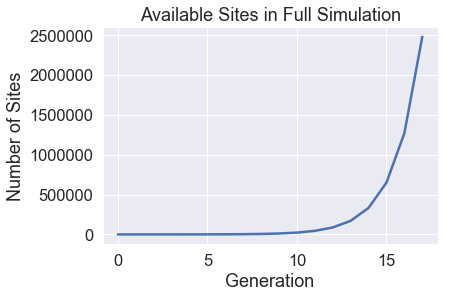

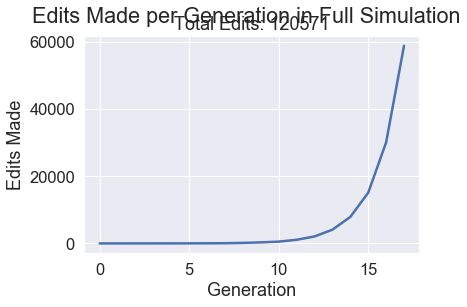

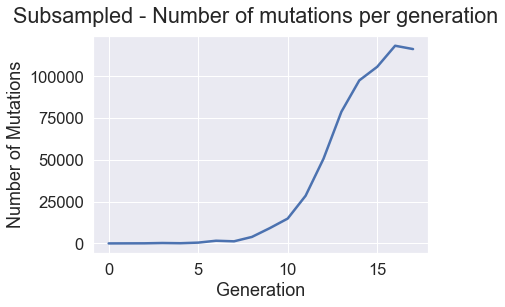

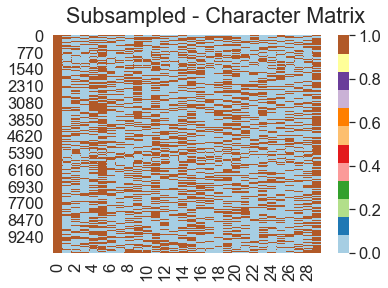

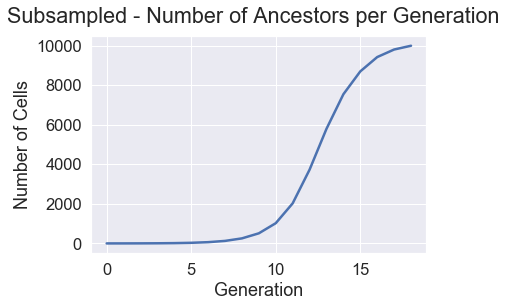

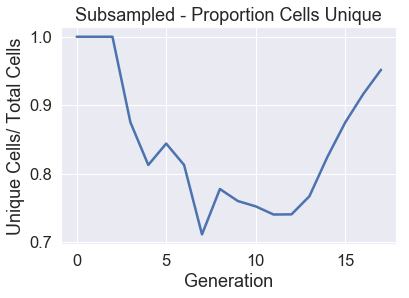

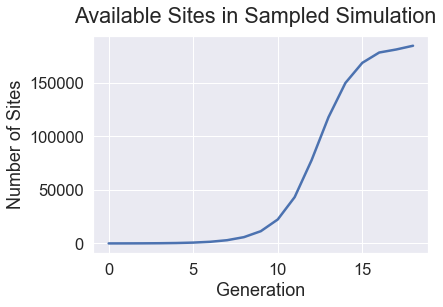

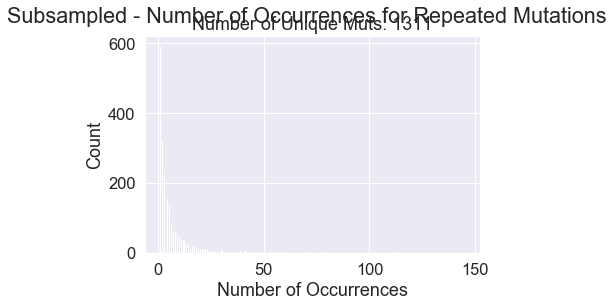

(10000, 30)
Time 1: 0.16569900512695312
Compute dictionary: 57.960469245910645
Conflict matrix is symmetric?  True
Total time: 58.22715997695923
Number of true recurrent muts:  2216
Number of detected recurrent muts:  2688
Number of true recurrent muts not detected: 0 with prevalence []


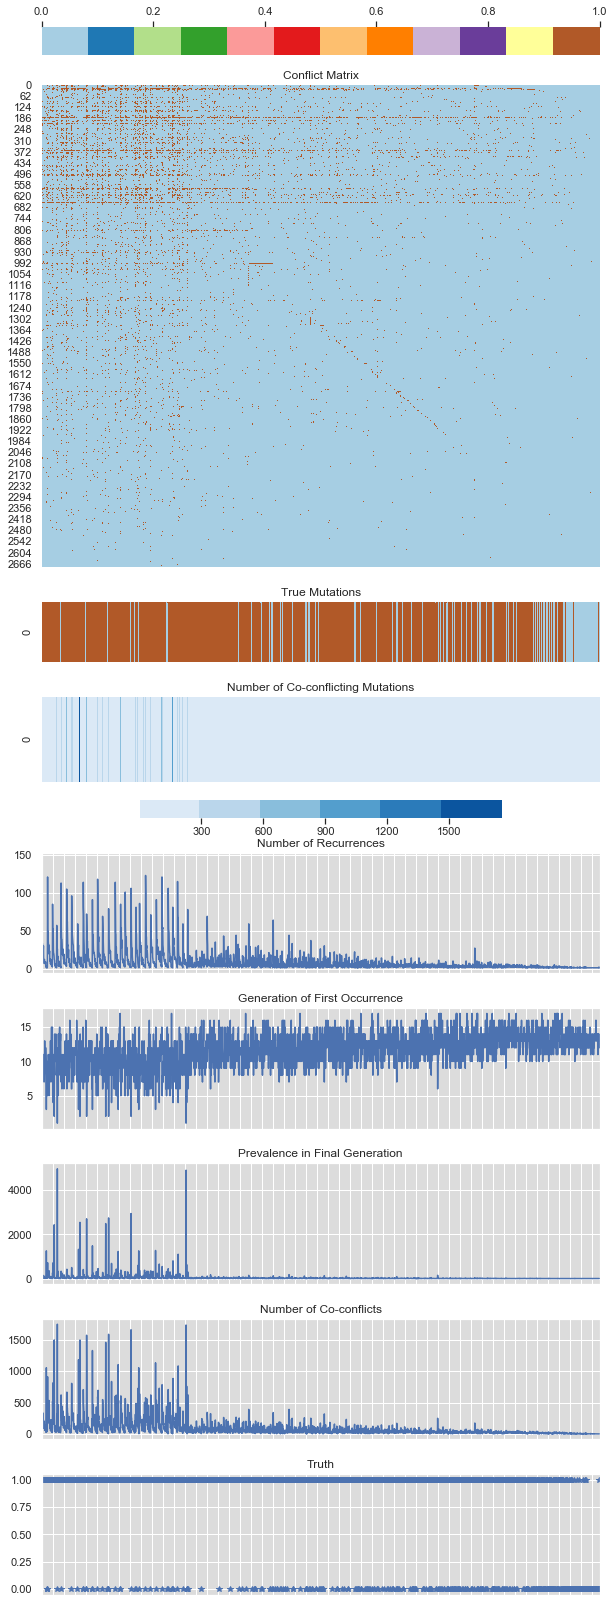

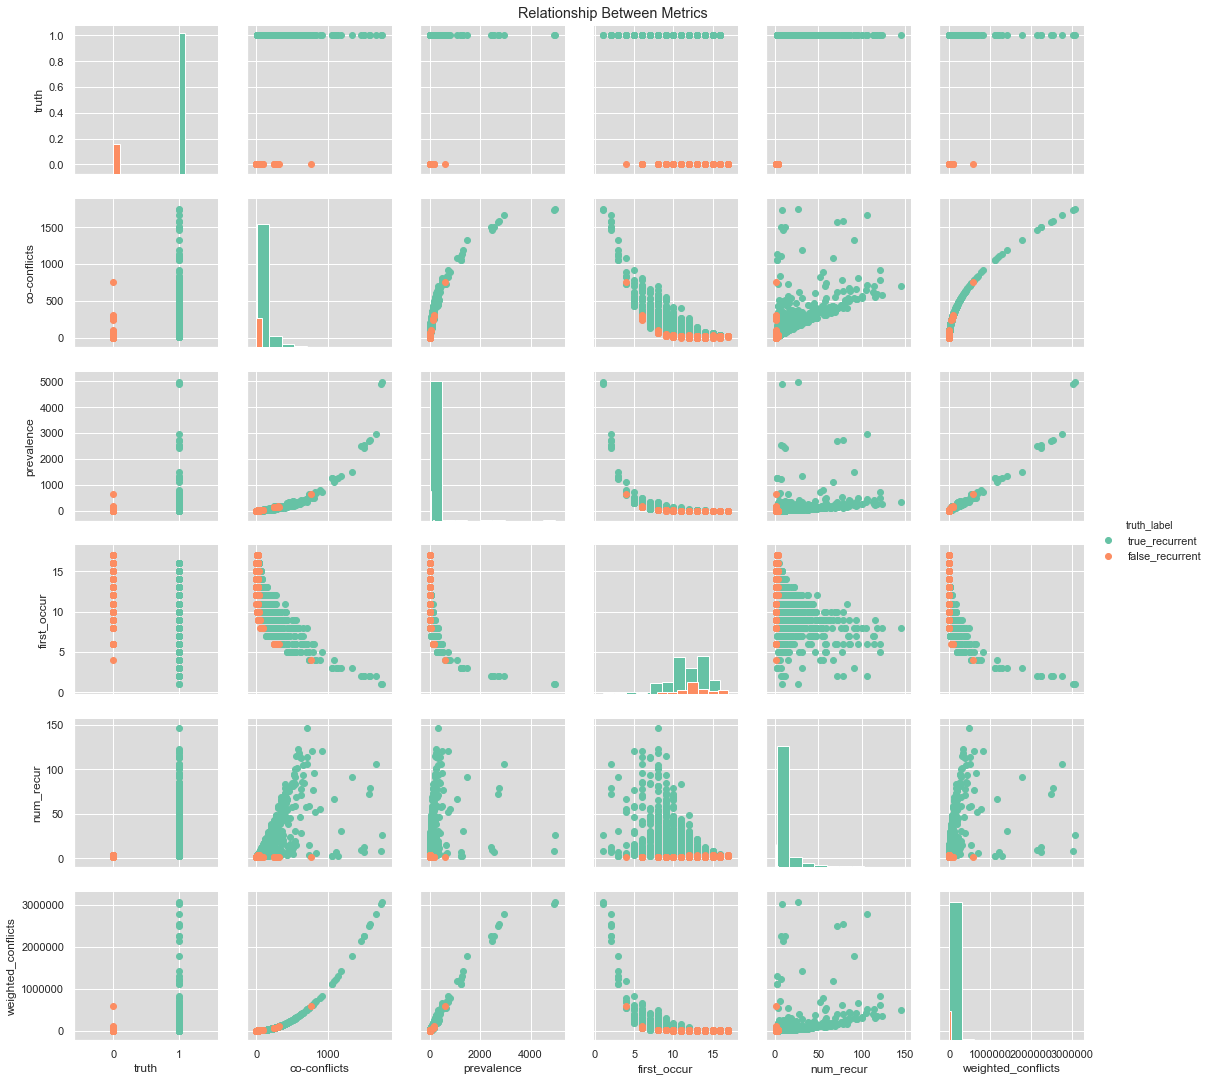

[  8.   7.   9. ...,  14.  13.  12.]


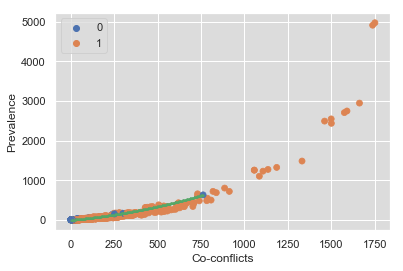

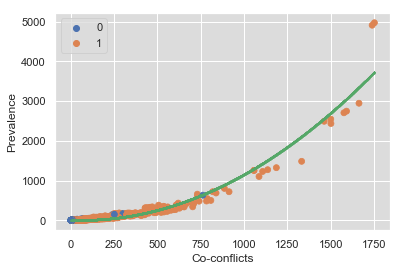

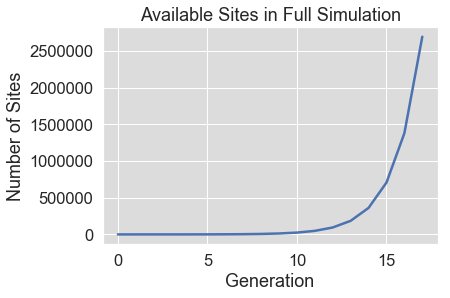

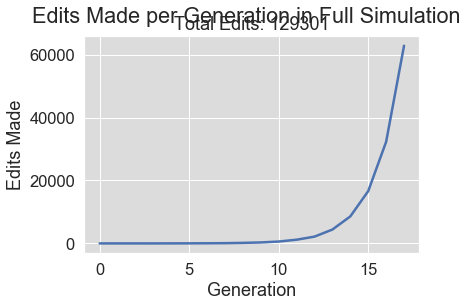

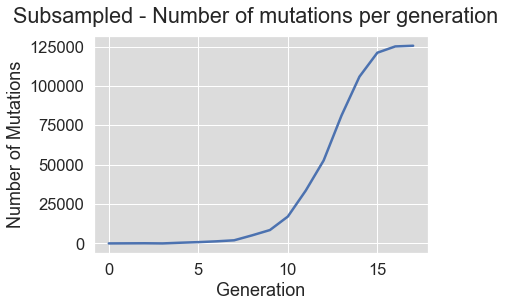

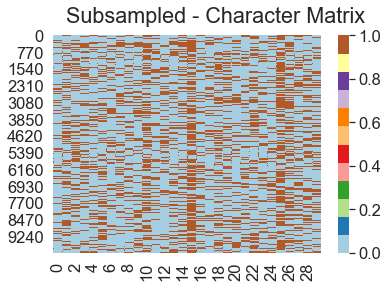

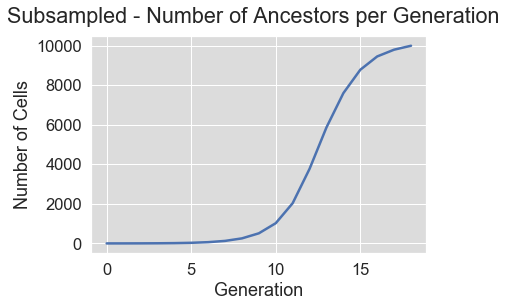

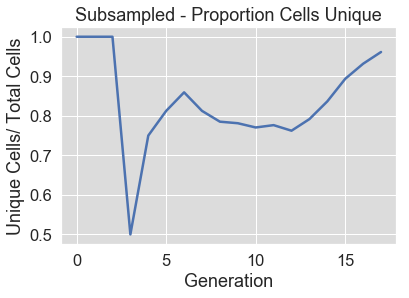

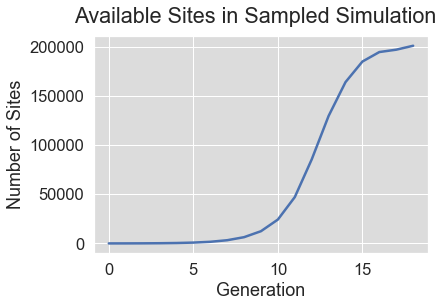

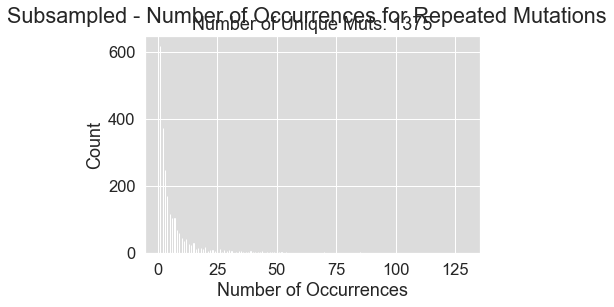

(10000, 30)
Time 1: 0.1671280860900879
Compute dictionary: 59.598556995391846
Conflict matrix is symmetric?  True
Total time: 59.90577006340027
Number of true recurrent muts:  2384
Number of detected recurrent muts:  2857
Number of true recurrent muts not detected: 0 with prevalence []


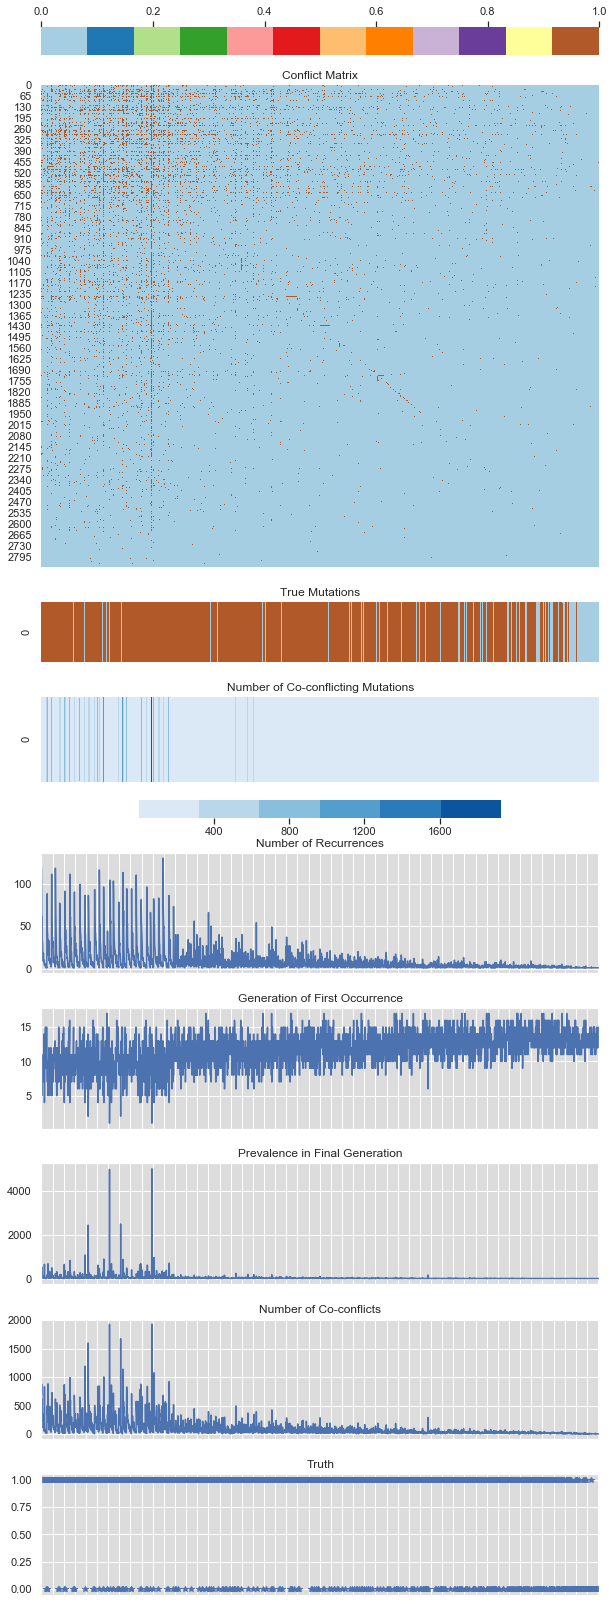

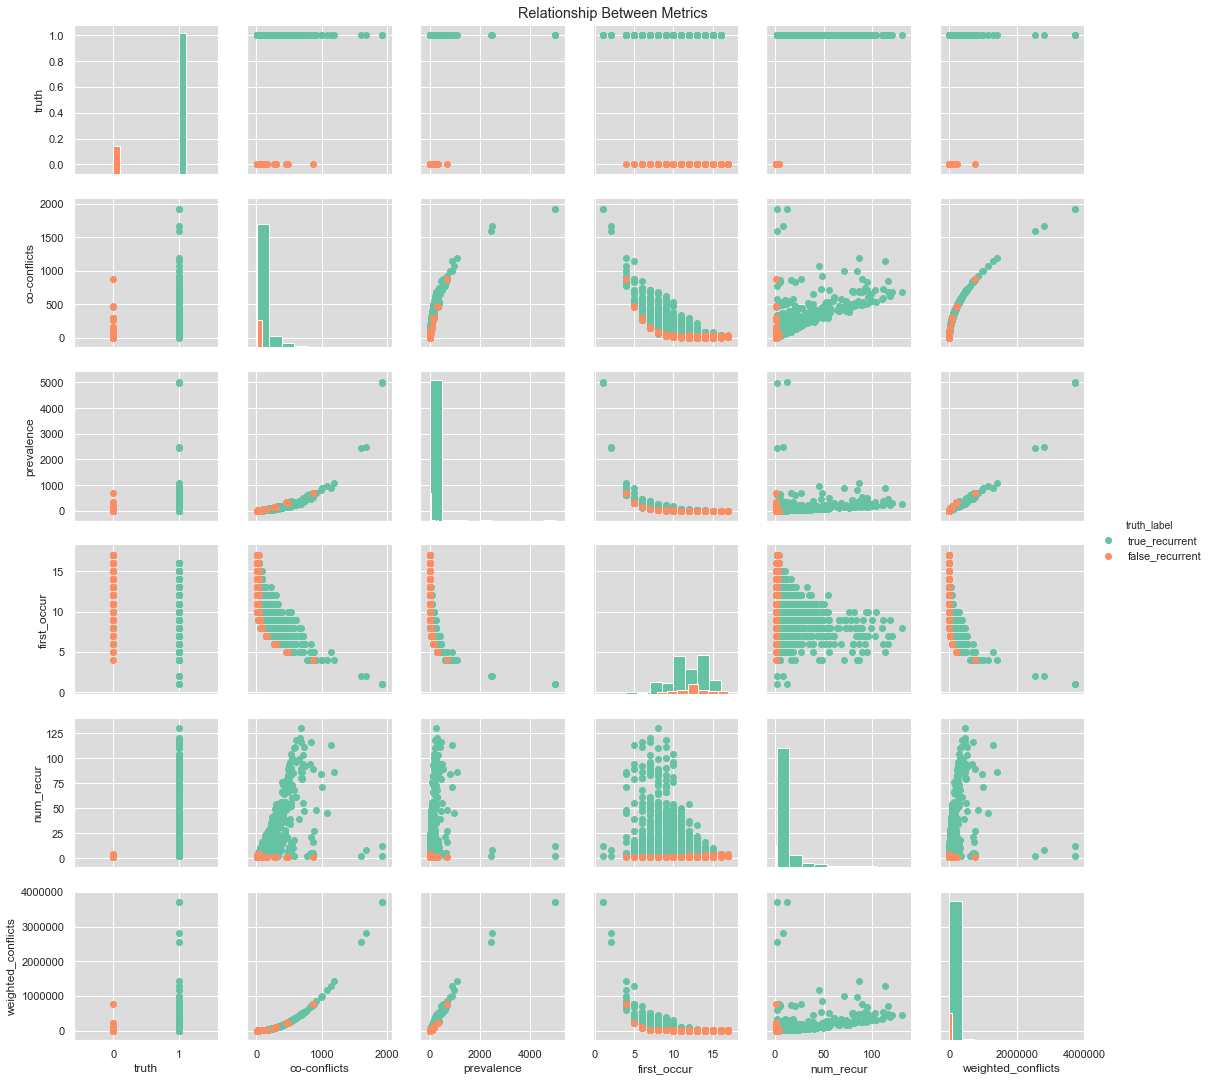

[  7.   7.   5. ...,  14.  13.  14.]


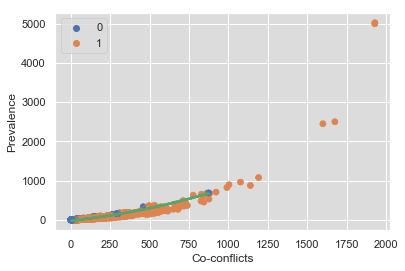

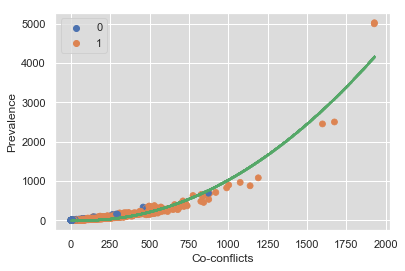

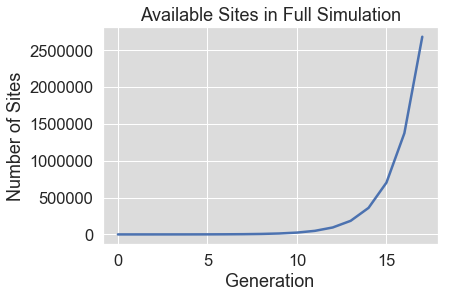

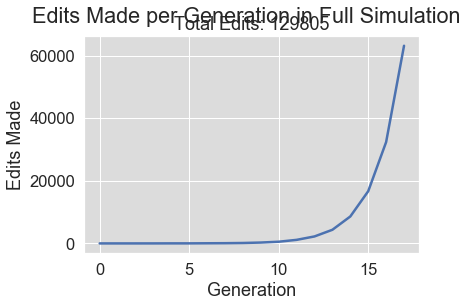

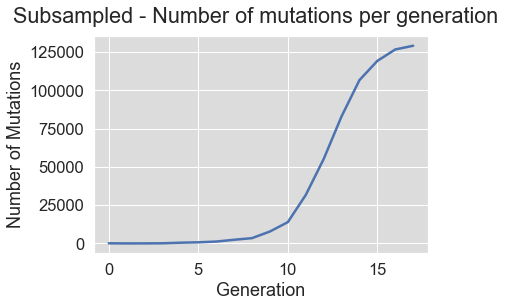

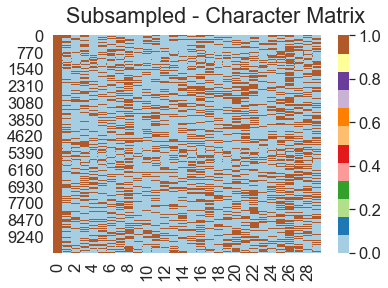

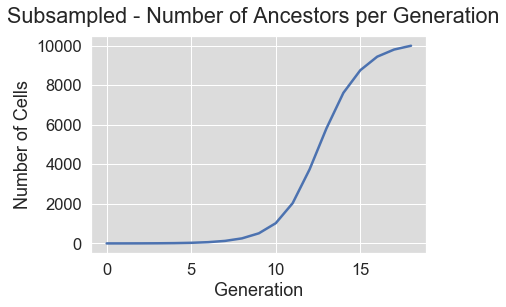

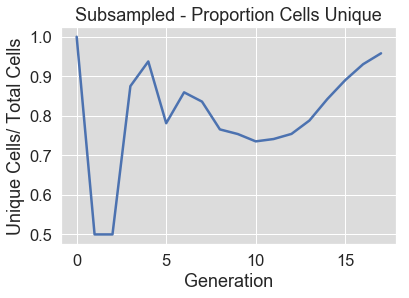

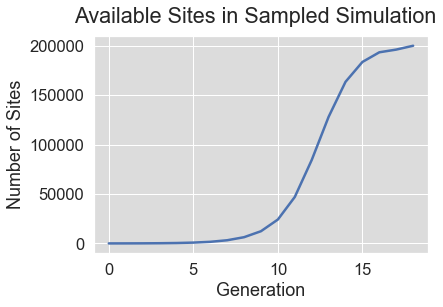

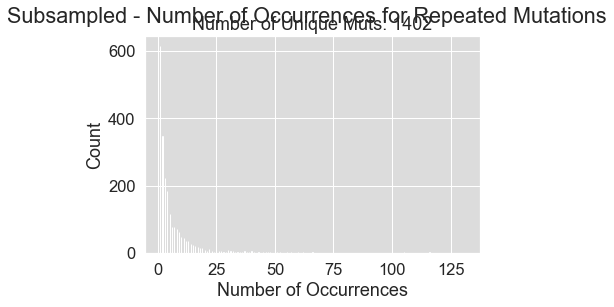

(10000, 30)
Time 1: 0.17081785202026367
Compute dictionary: 58.110493898391724
Conflict matrix is symmetric?  True
Total time: 58.3826699256897
Number of true recurrent muts:  2312
Number of detected recurrent muts:  2759
Number of true recurrent muts not detected: 0 with prevalence []


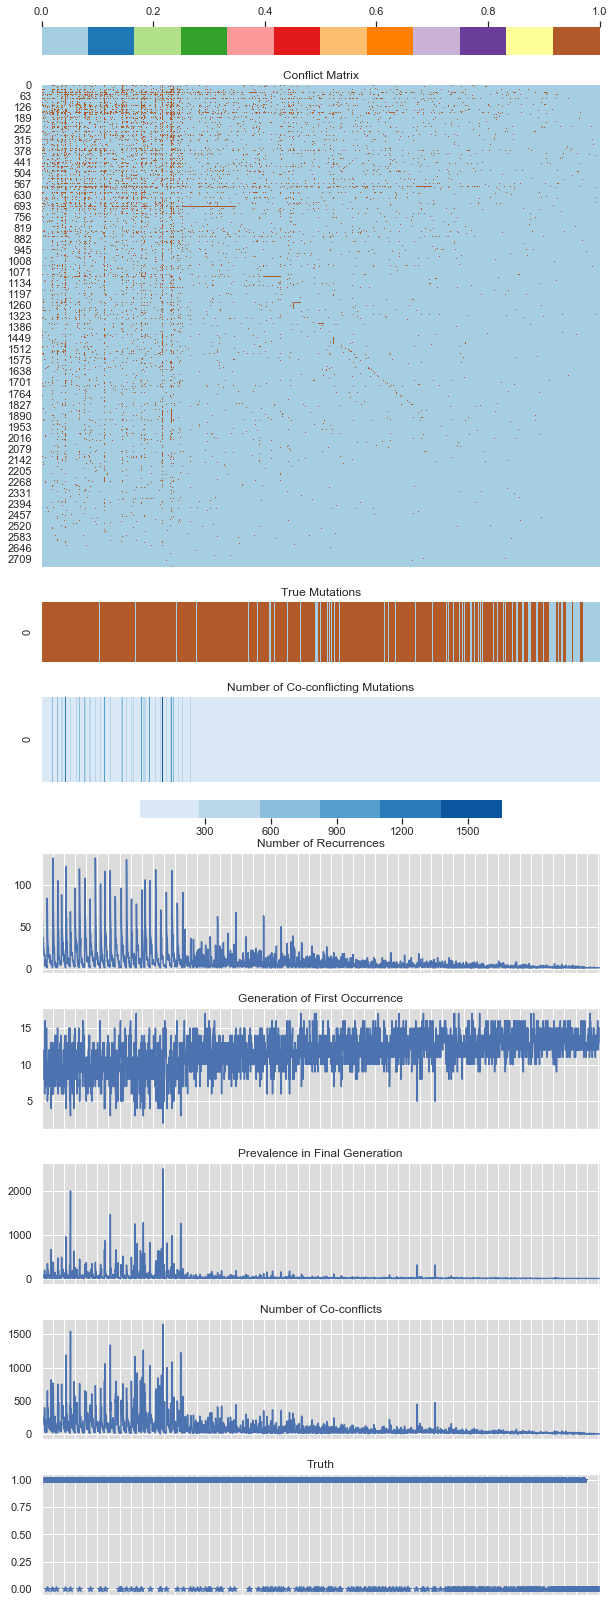

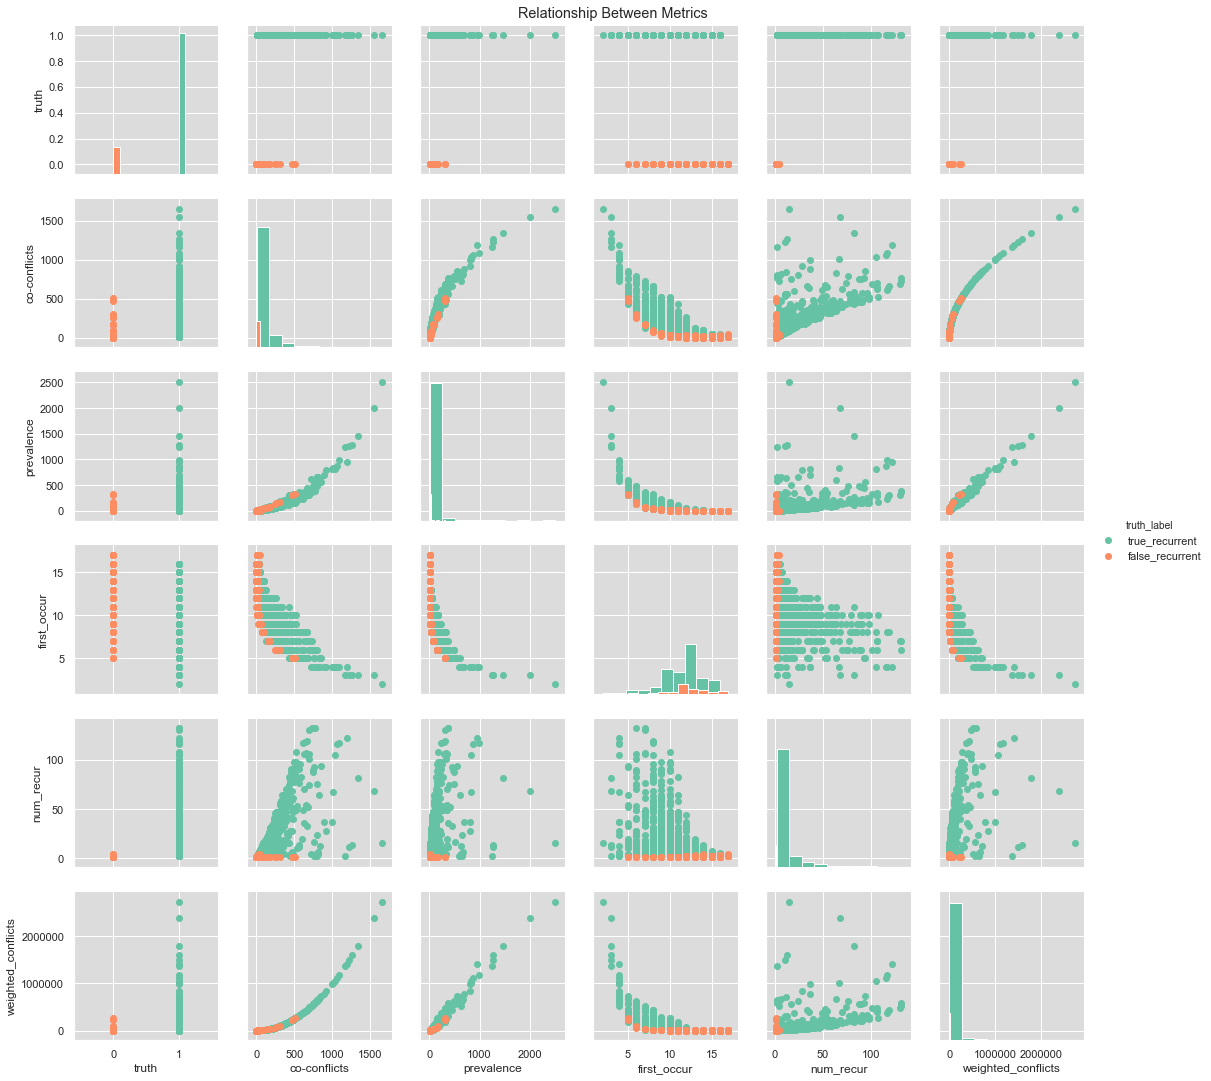

[  6.  10.   8. ...,  14.  13.  15.]


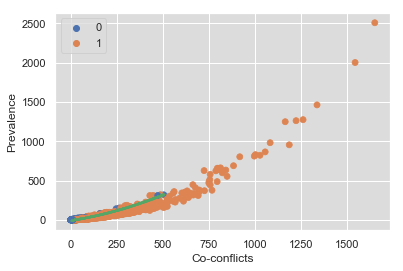

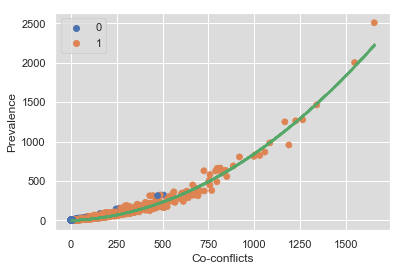

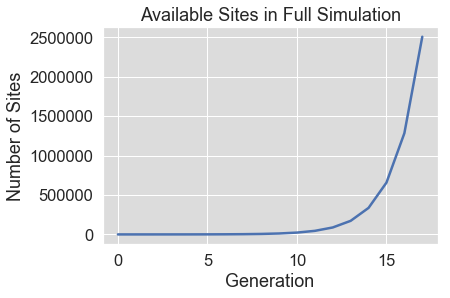

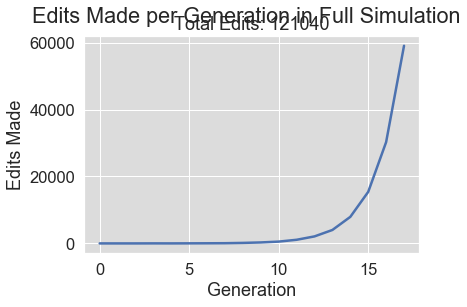

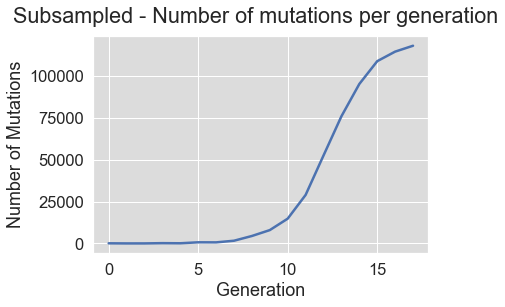

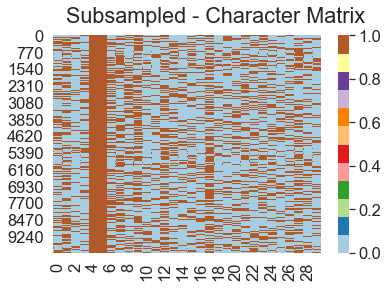

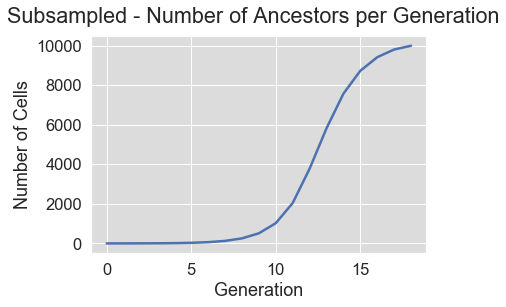

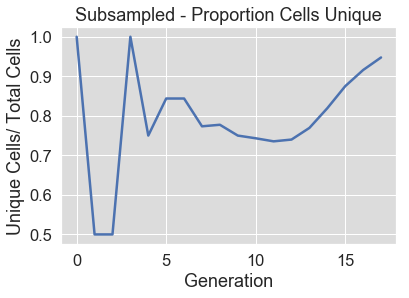

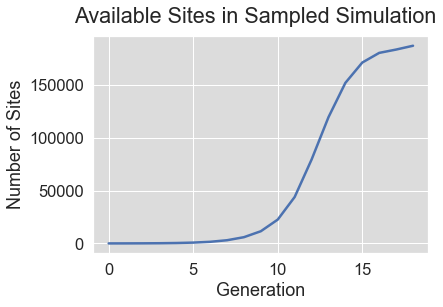

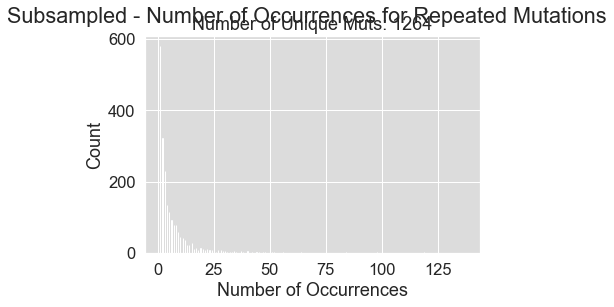

(10000, 30)
Time 1: 0.14691805839538574
Compute dictionary: 54.24448895454407
Conflict matrix is symmetric?  True
Total time: 54.4911949634552
Number of true recurrent muts:  2186
Number of detected recurrent muts:  2602
Number of true recurrent muts not detected: 0 with prevalence []


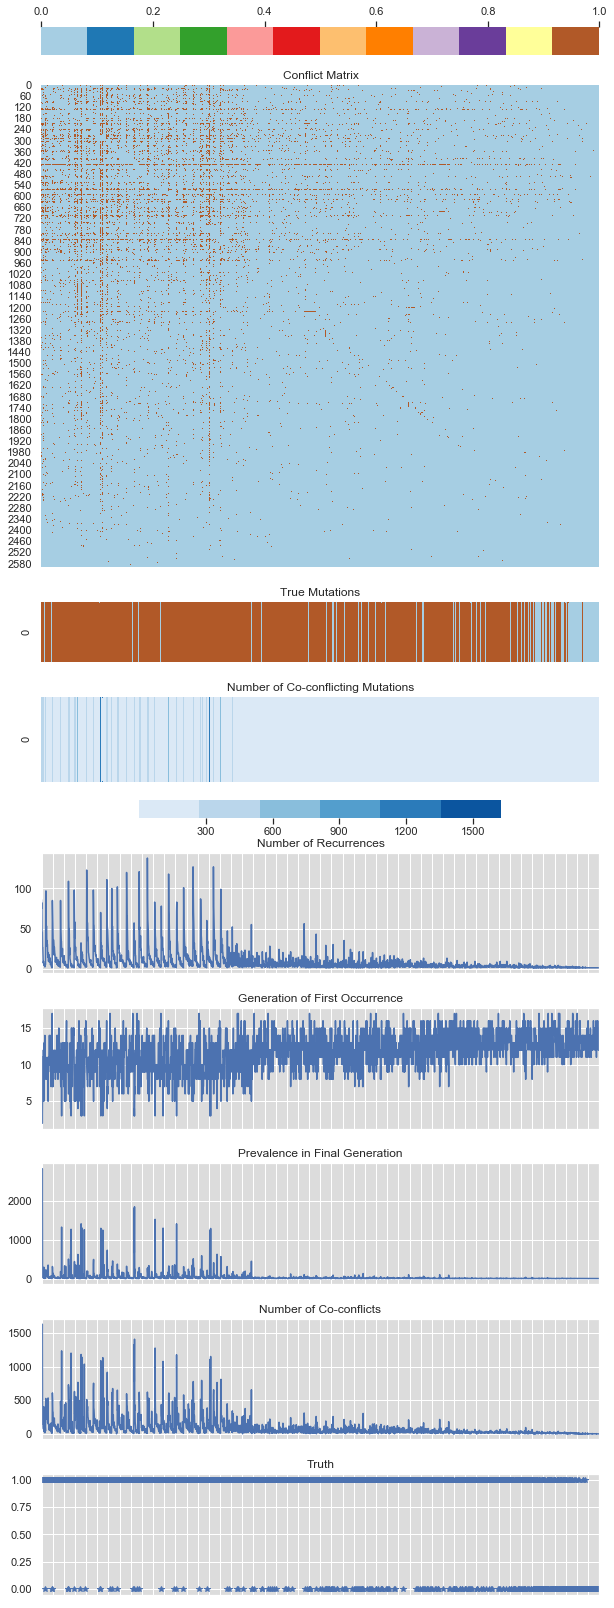

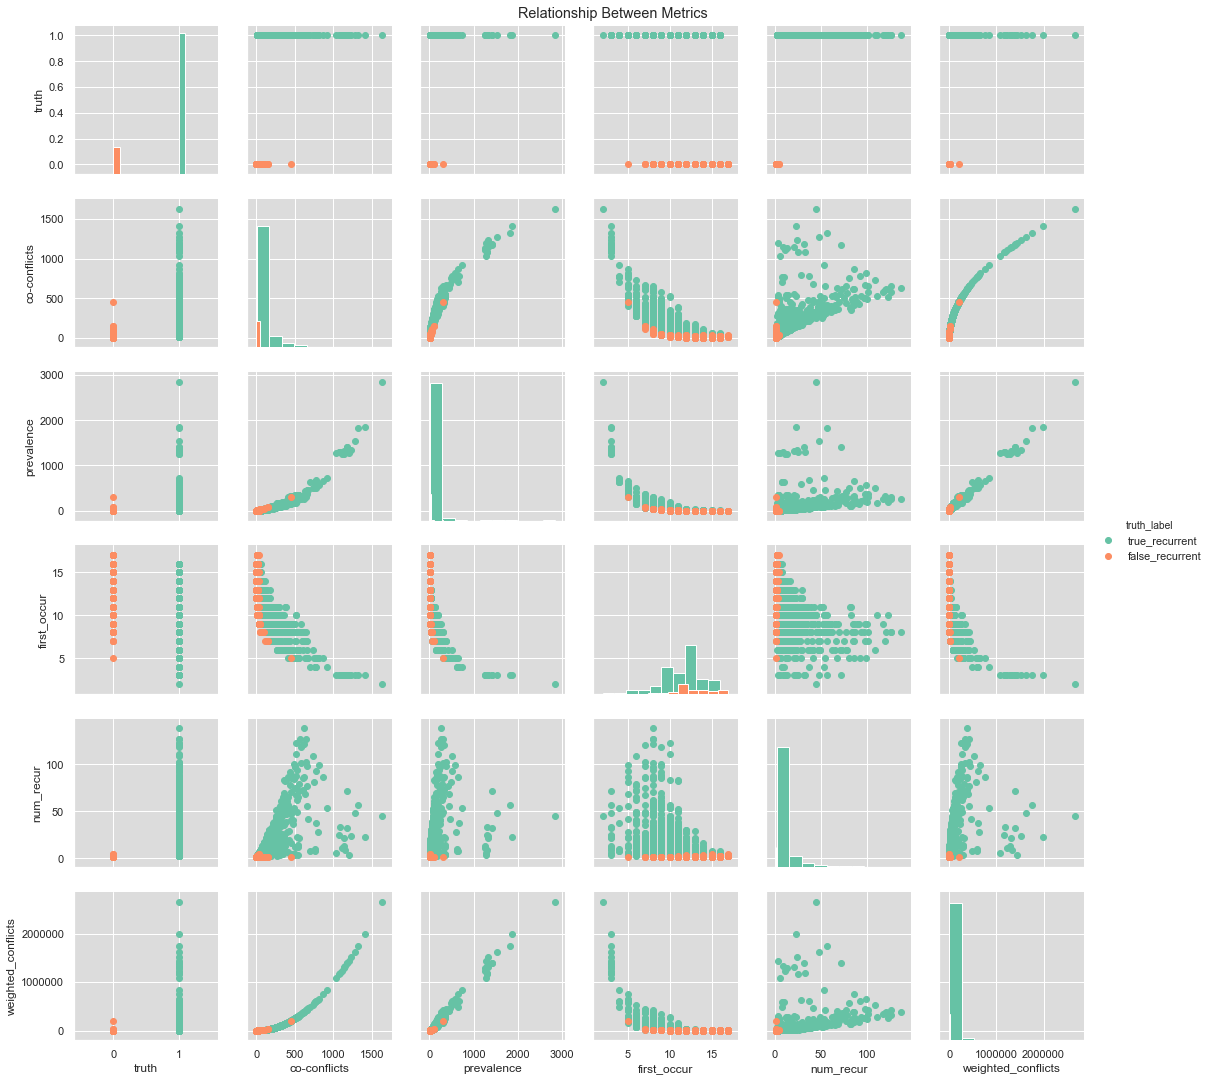

[  5.   7.  11. ...,  15.  13.  14.]


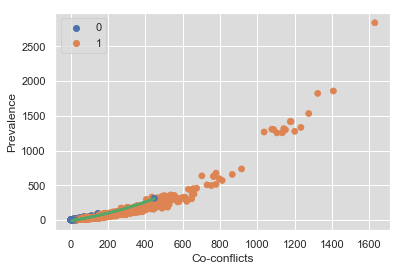

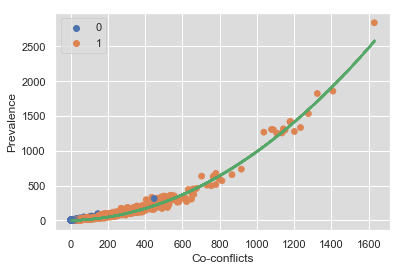

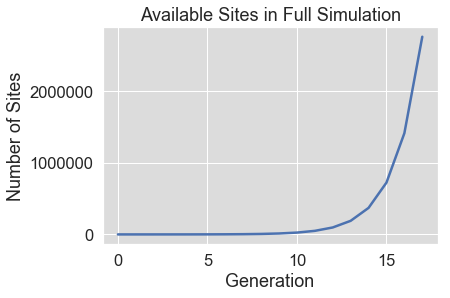

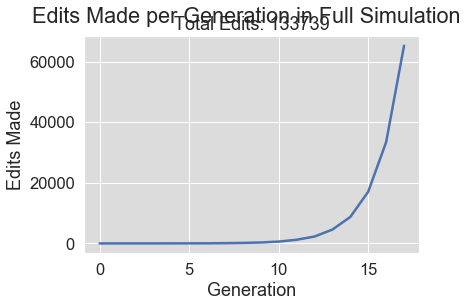

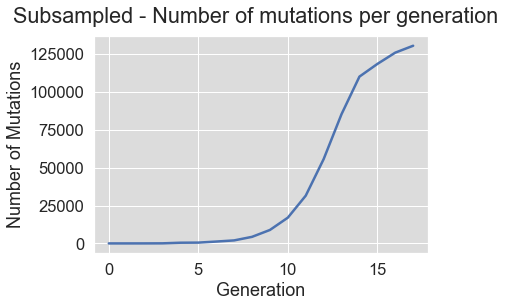

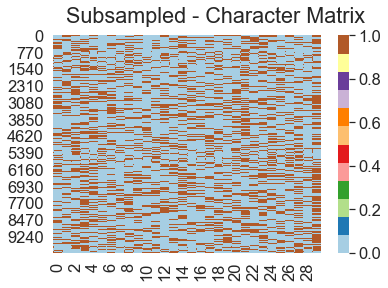

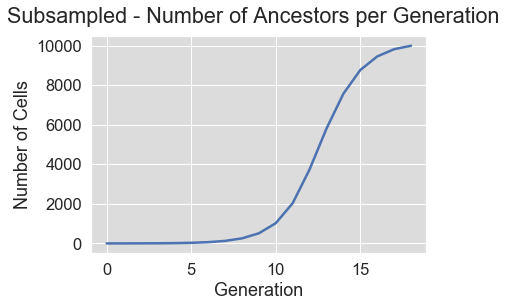

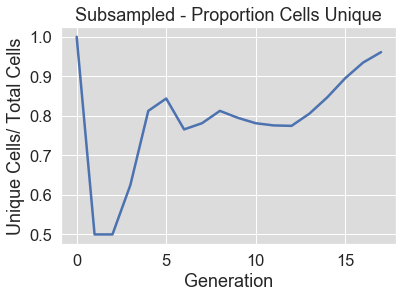

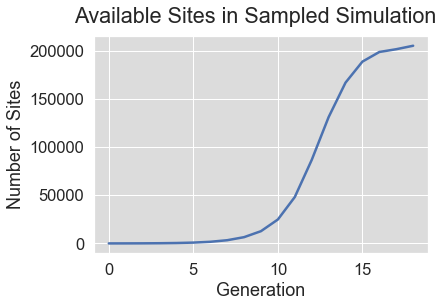

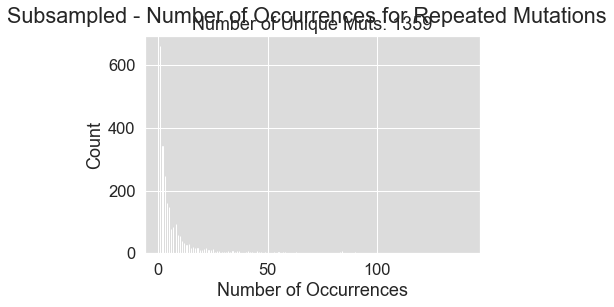

(10000, 30)
Time 1: 0.17446589469909668
Compute dictionary: 59.88203716278076
Conflict matrix is symmetric?  True
Total time: 60.19398593902588
Number of true recurrent muts:  2408
Number of detected recurrent muts:  2880
Number of true recurrent muts not detected: 0 with prevalence []


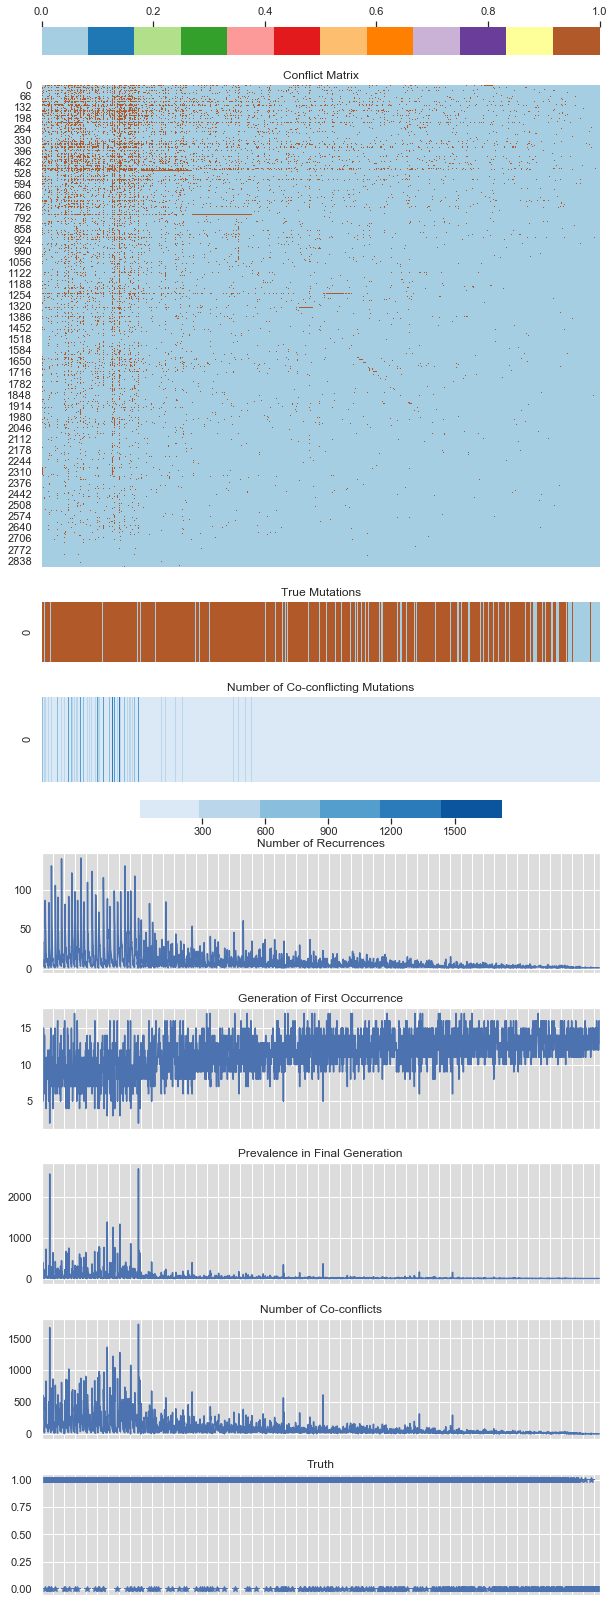

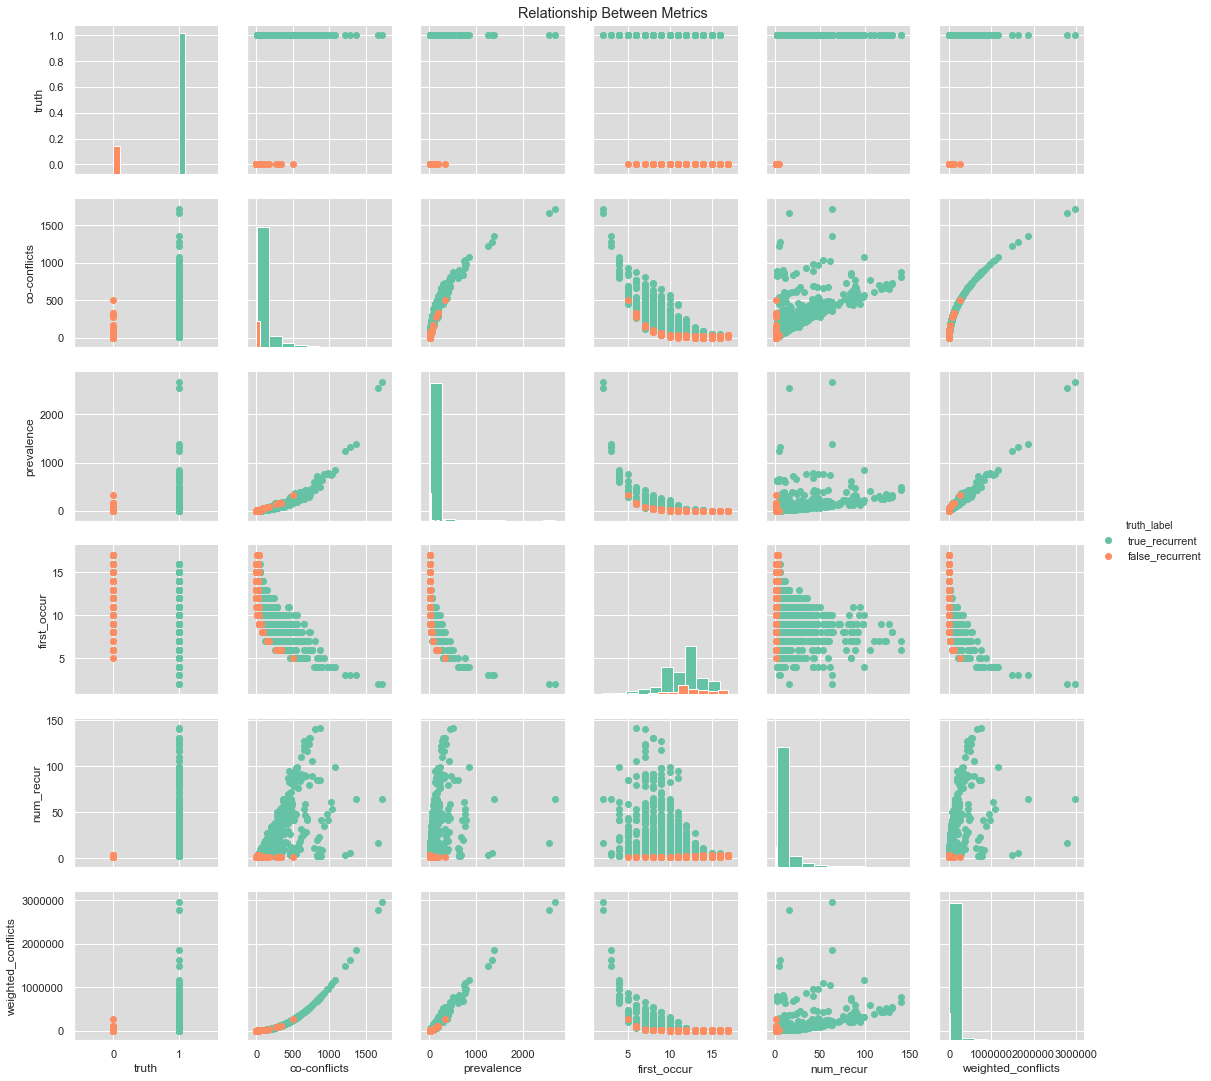

[  8.   9.   8. ...,  15.  16.  13.]


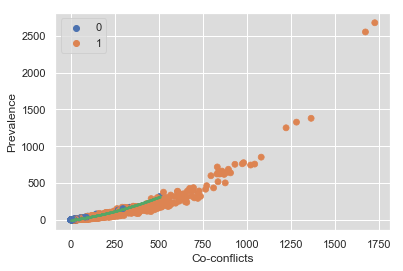

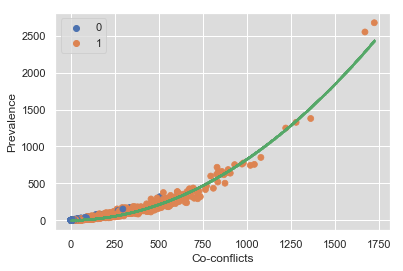

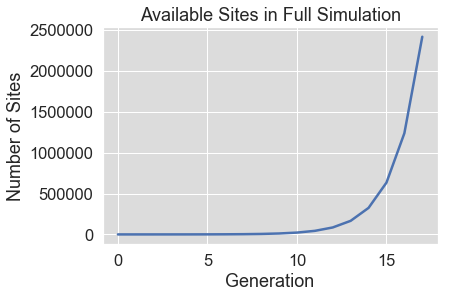

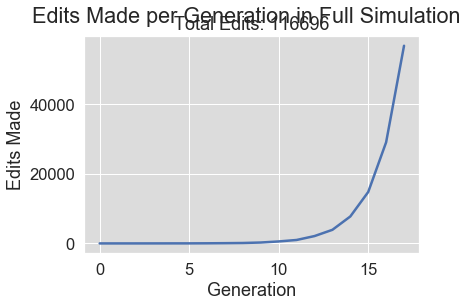

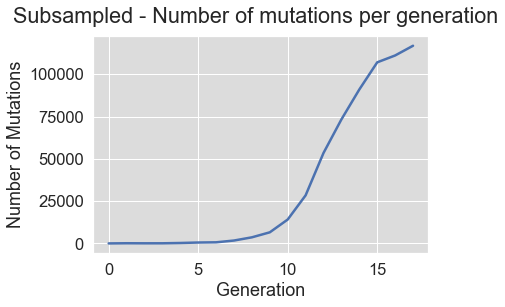

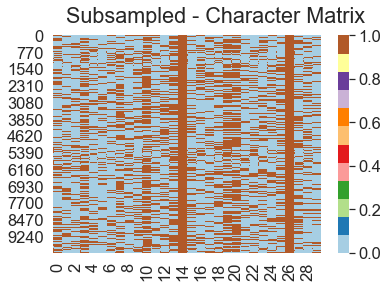

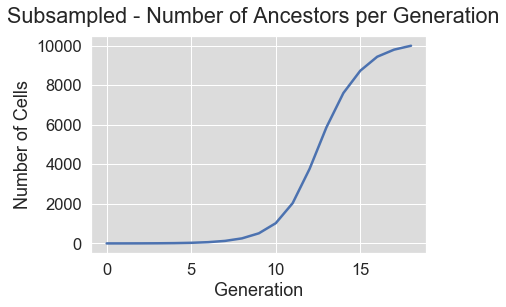

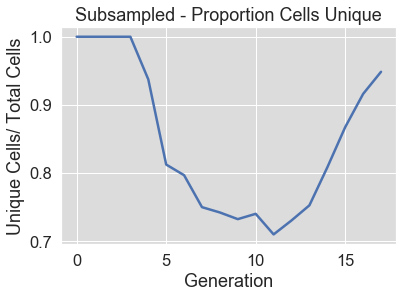

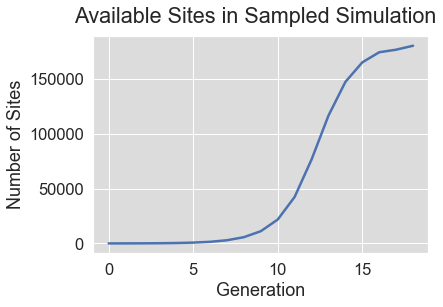

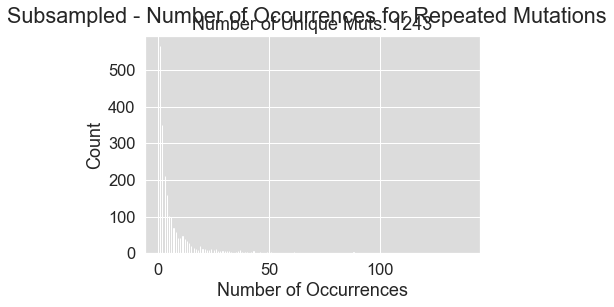

(10000, 30)
Time 1: 0.1600499153137207
Compute dictionary: 54.04169487953186
Conflict matrix is symmetric?  True
Total time: 54.27596592903137
Number of true recurrent muts:  2158
Number of detected recurrent muts:  2565
Number of true recurrent muts not detected: 0 with prevalence []


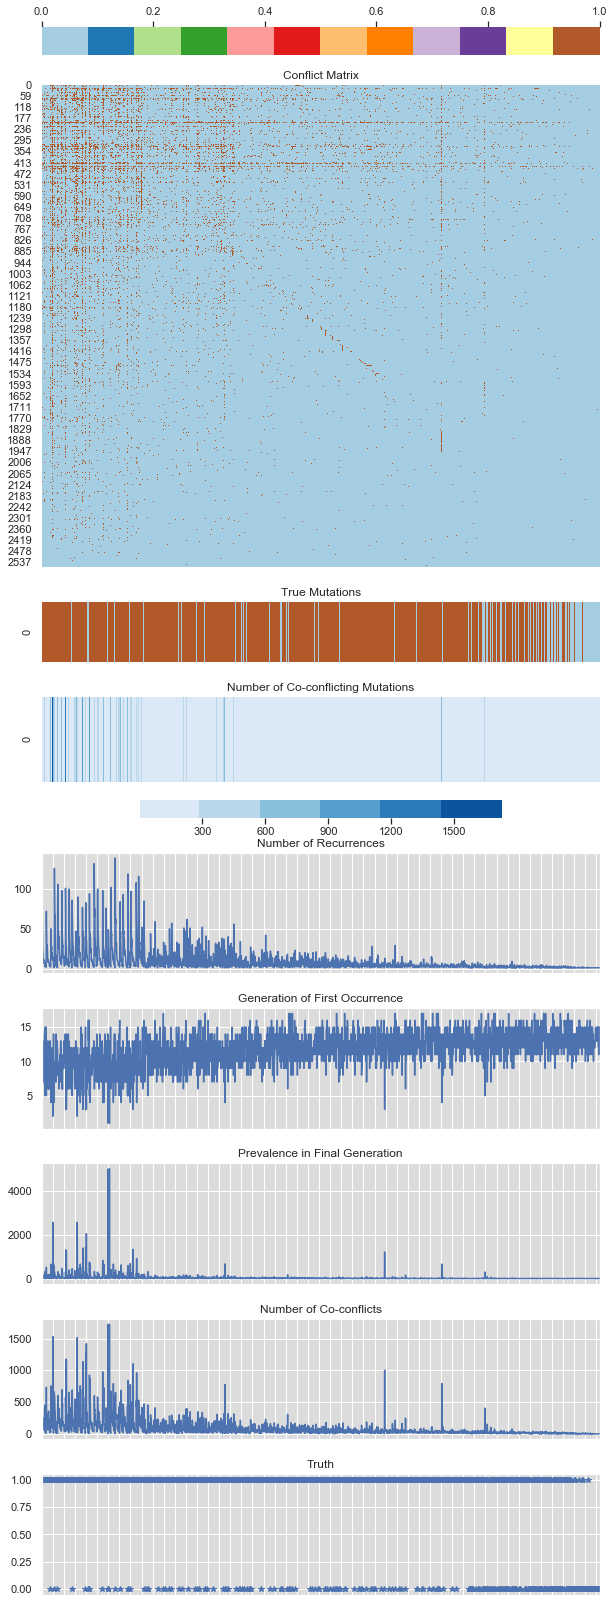

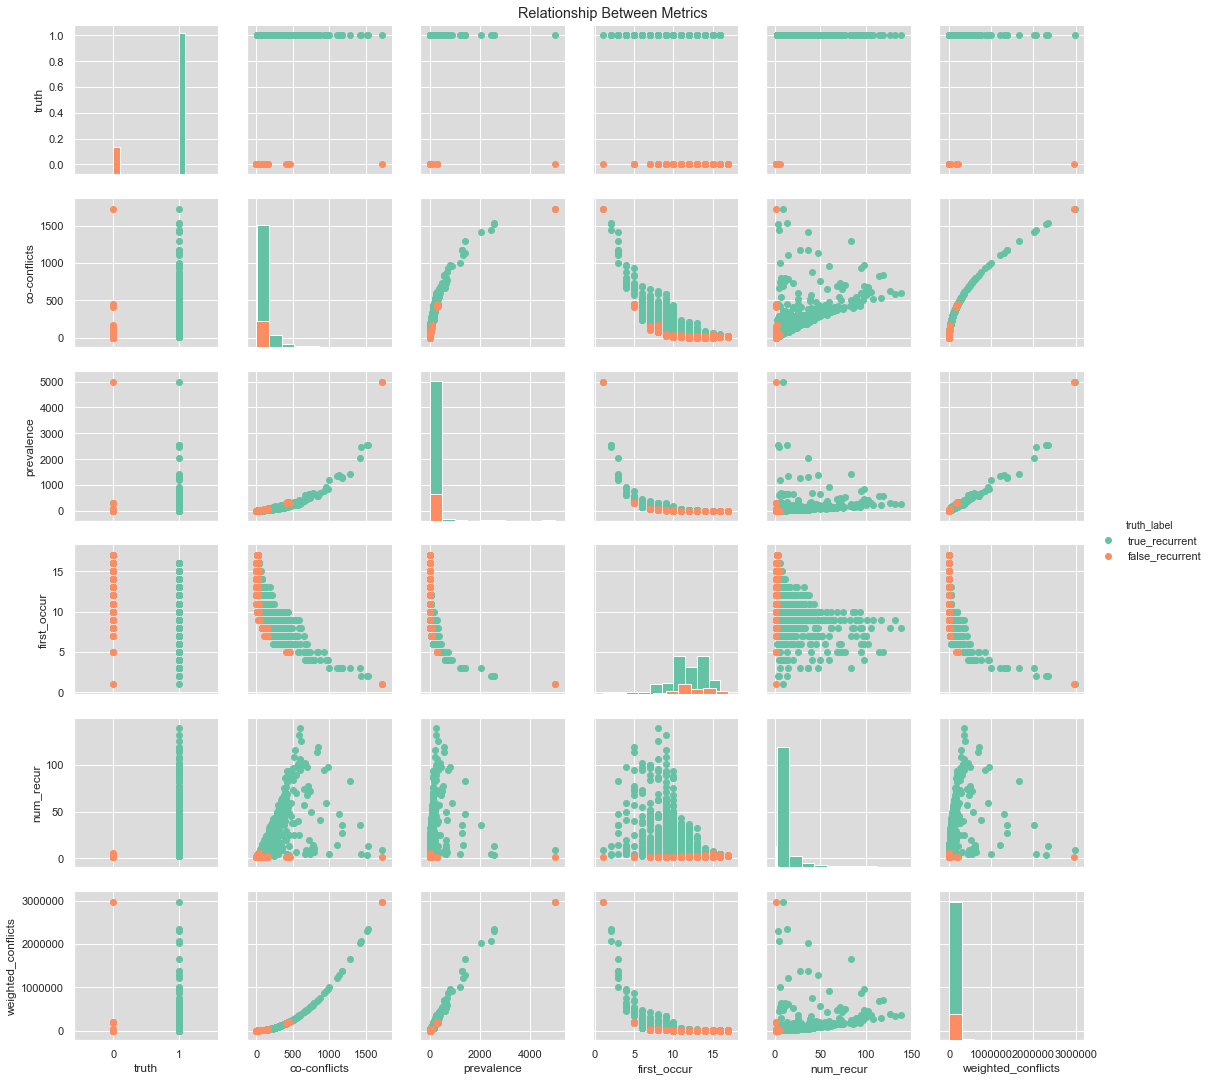

[  9.   5.  10. ...,  11.  15.  13.]


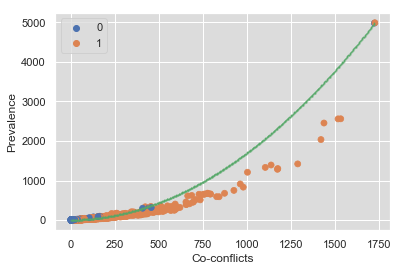

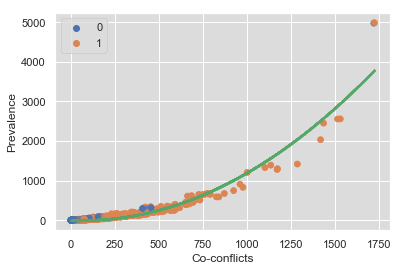

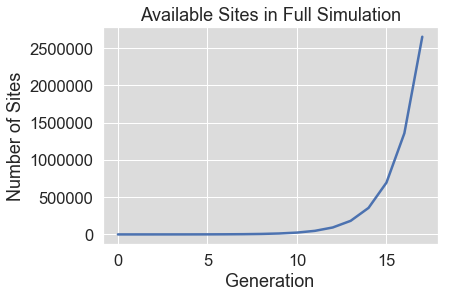

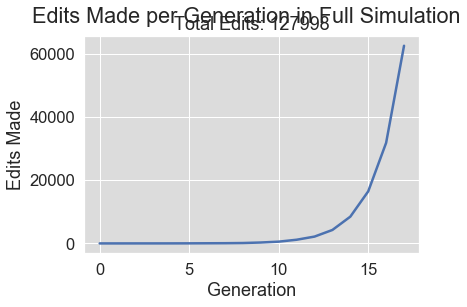

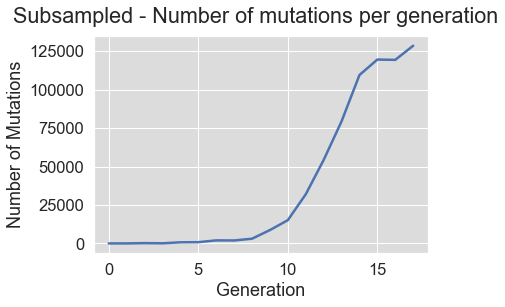

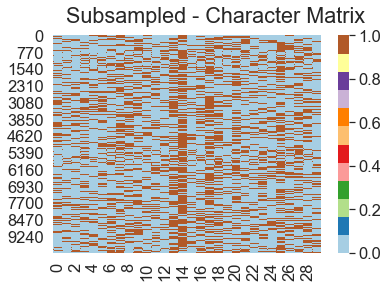

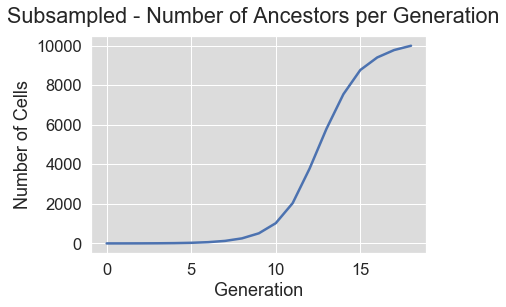

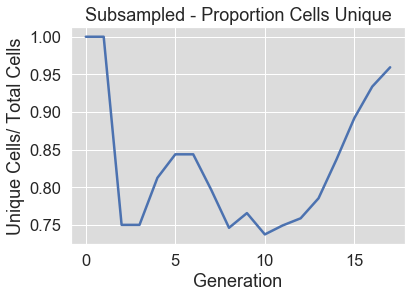

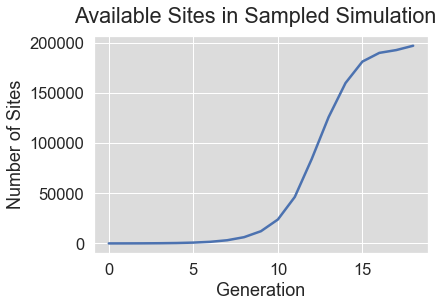

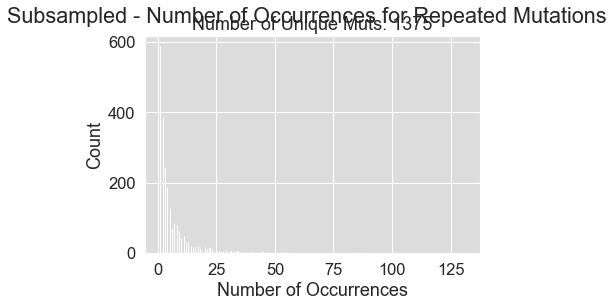

(10000, 30)
Time 1: 0.18116998672485352
Compute dictionary: 80.01792192459106
Conflict matrix is symmetric?  True
Total time: 80.36680793762207
Number of true recurrent muts:  2359
Number of detected recurrent muts:  2815
Number of true recurrent muts not detected: 0 with prevalence []


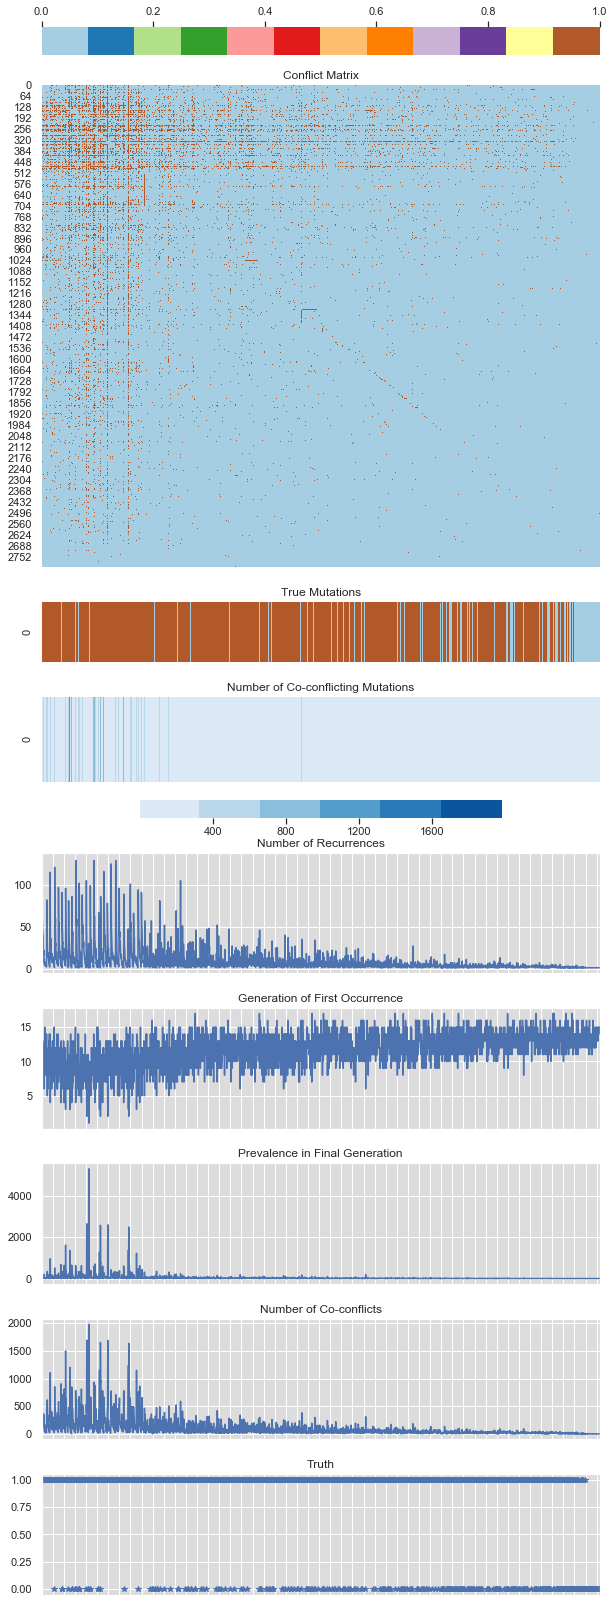

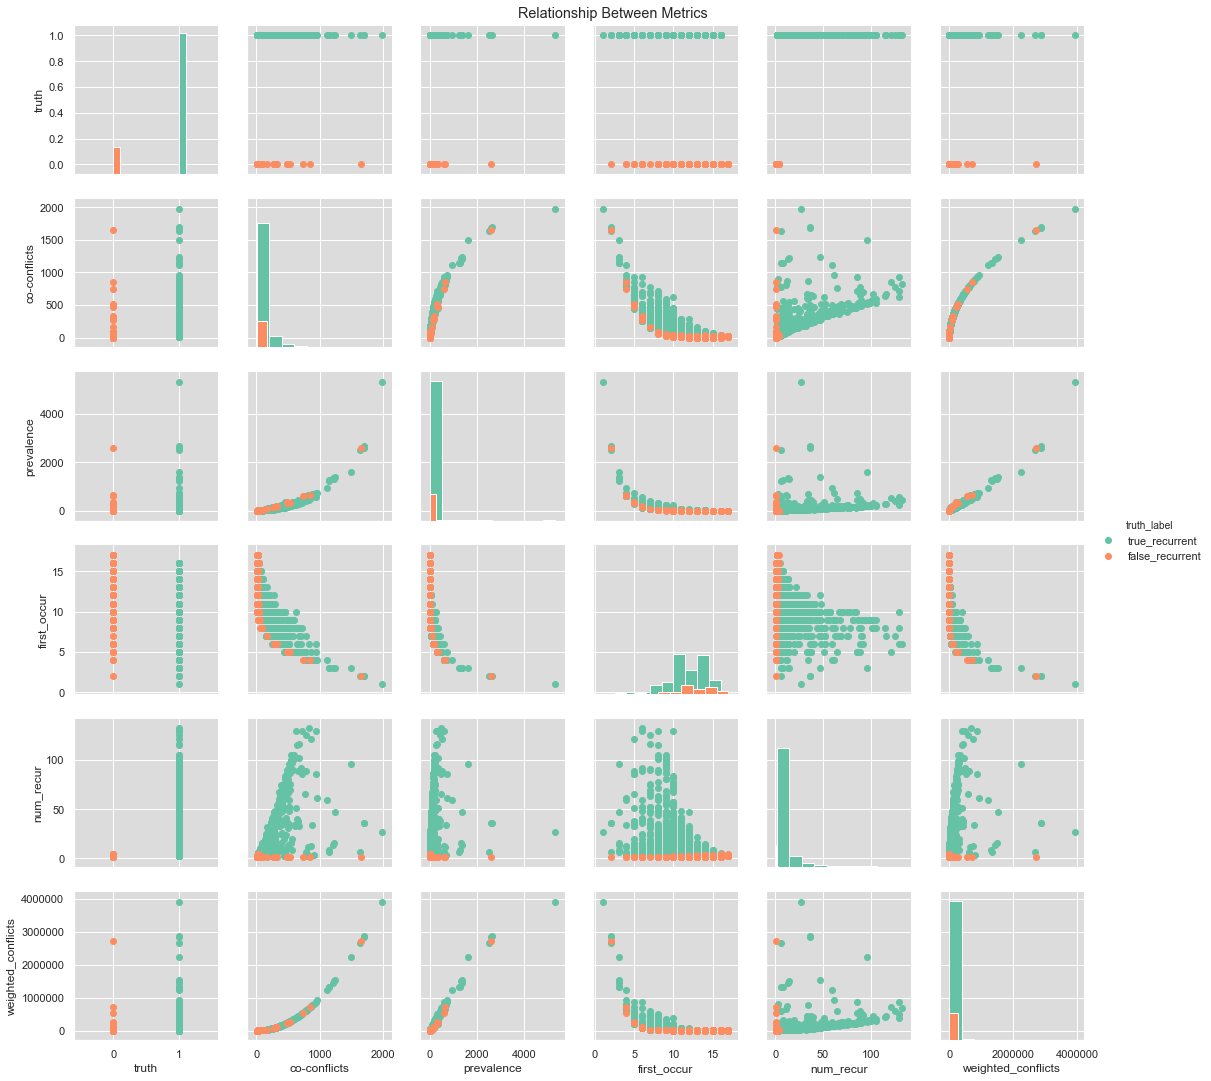

[  7.   6.   6. ...,  14.  15.  15.]


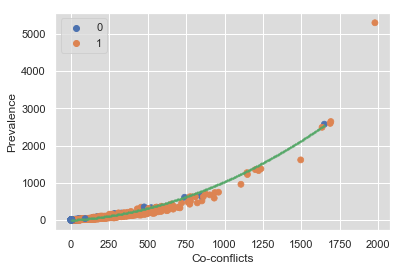

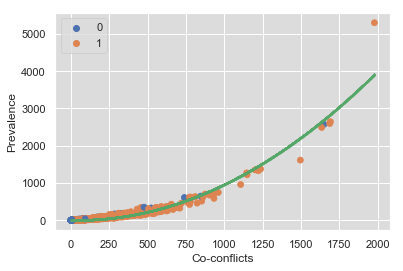

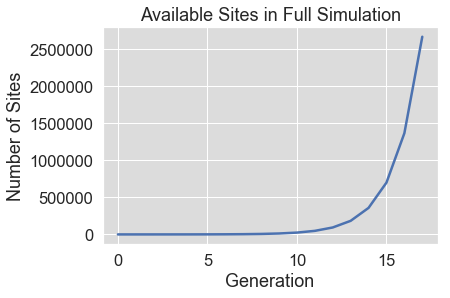

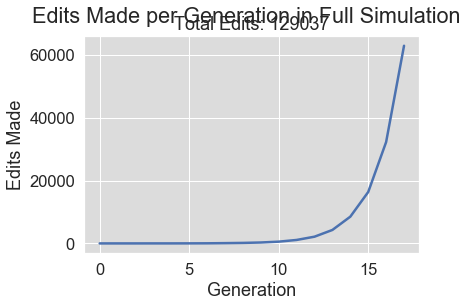

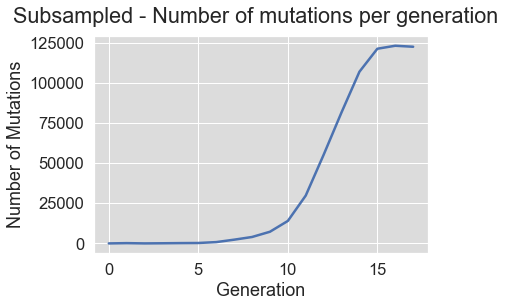

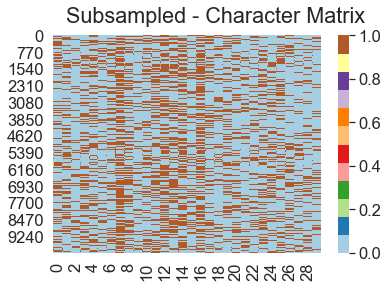

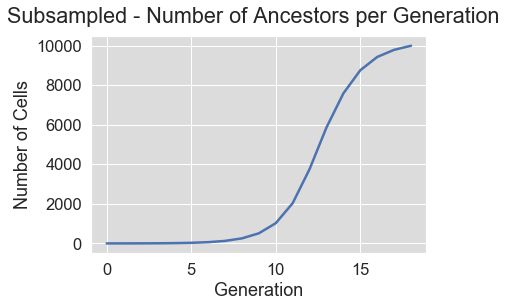

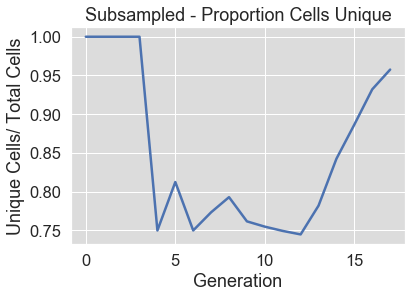

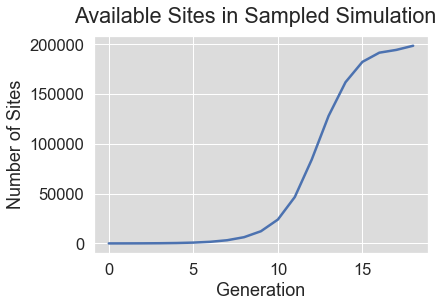

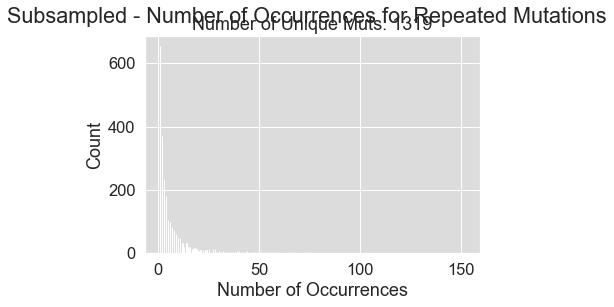

(10000, 30)
Time 1: 0.15866899490356445
Compute dictionary: 65.8549861907959
Conflict matrix is symmetric?  True
Total time: 66.08594012260437
Number of true recurrent muts:  2375
Number of detected recurrent muts:  2812
Number of true recurrent muts not detected: 0 with prevalence []


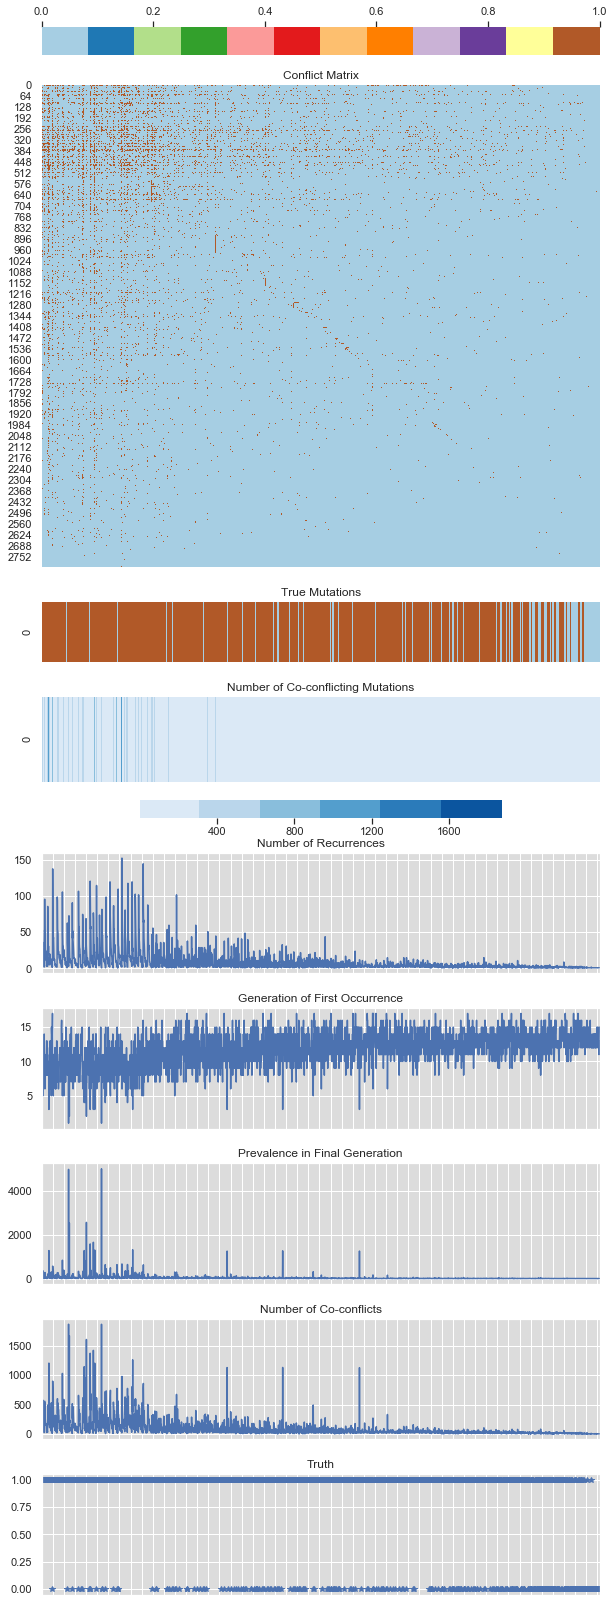

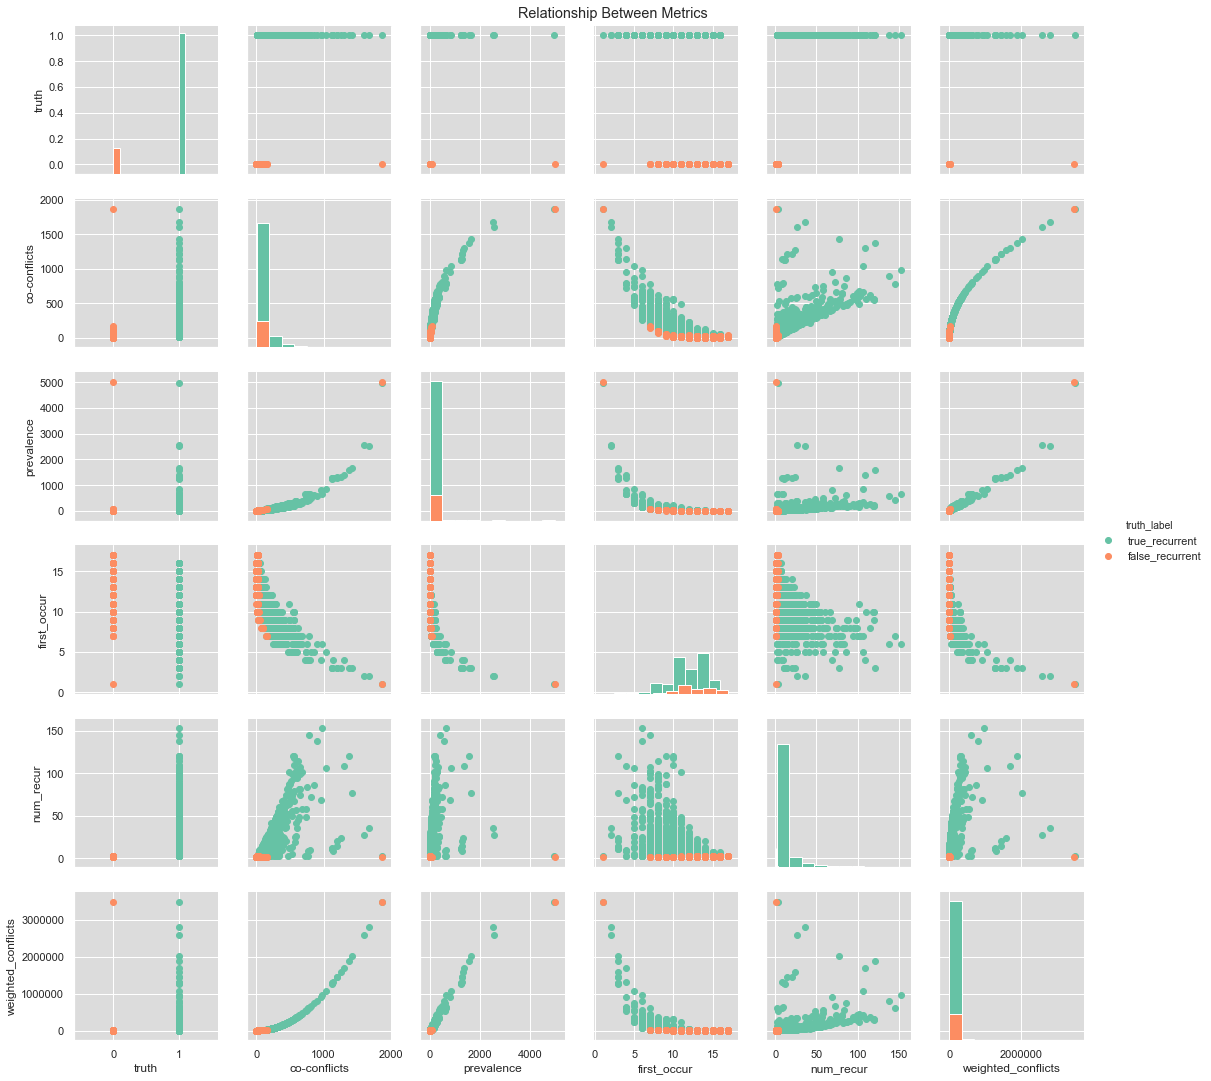

[  9.   4.   6. ...,  11.  14.  15.]


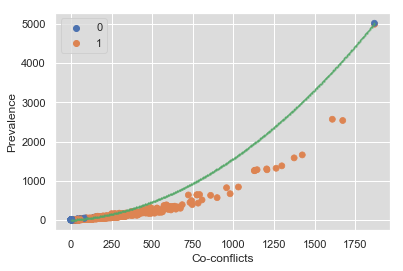

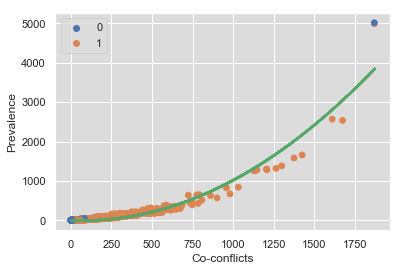

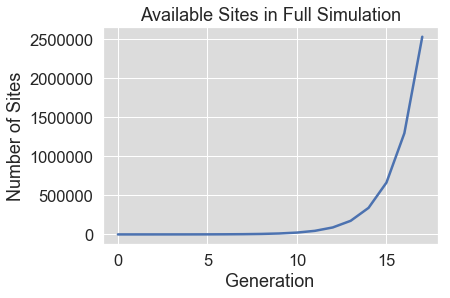

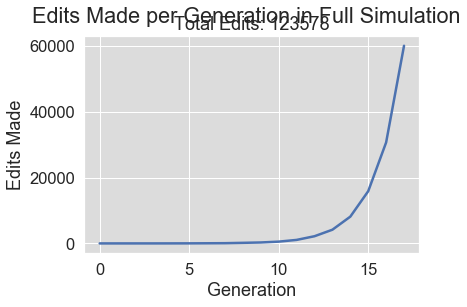

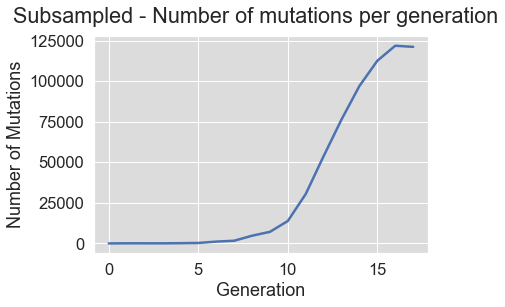

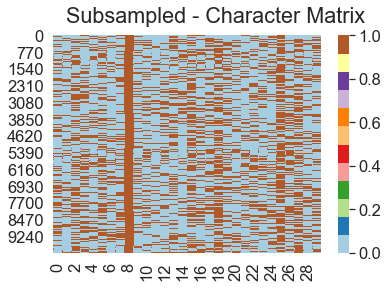

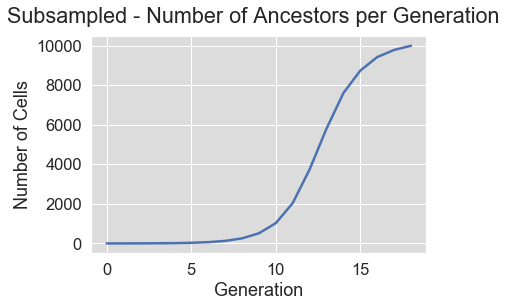

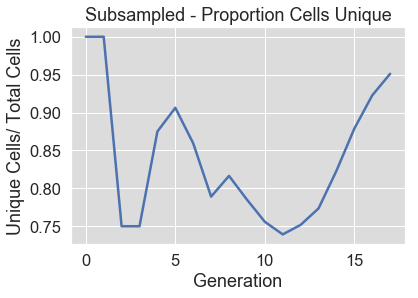

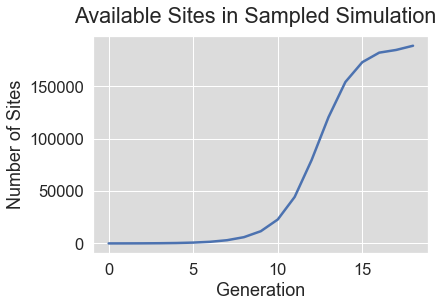

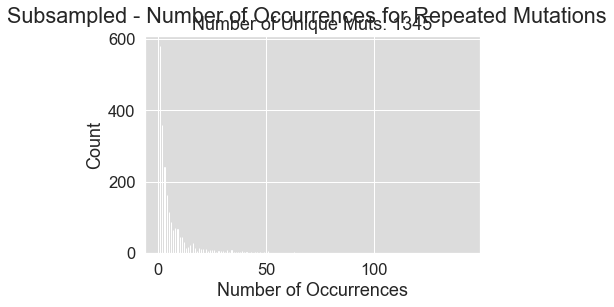

(10000, 30)
Time 1: 0.19504523277282715
Compute dictionary: 80.55825114250183
Conflict matrix is symmetric?  True
Total time: 80.82251214981079
Number of true recurrent muts:  2244
Number of detected recurrent muts:  2698
Number of true recurrent muts not detected: 0 with prevalence []


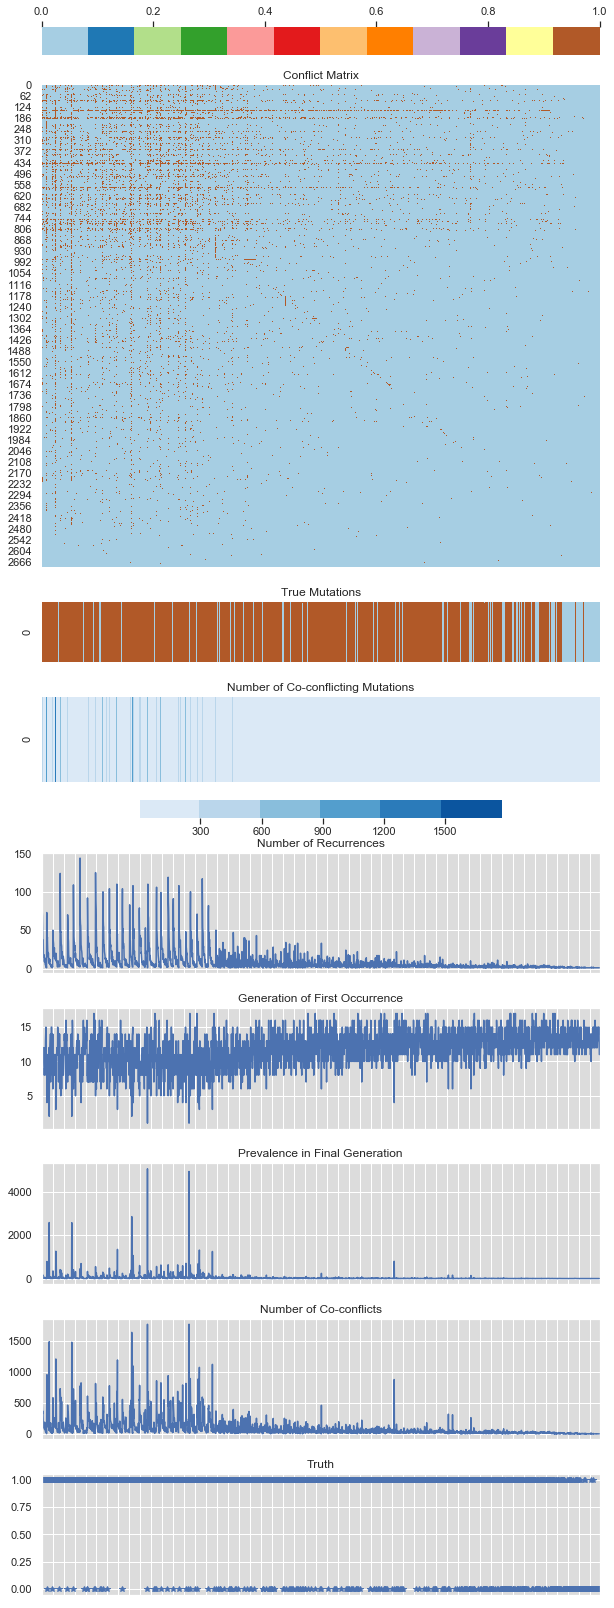

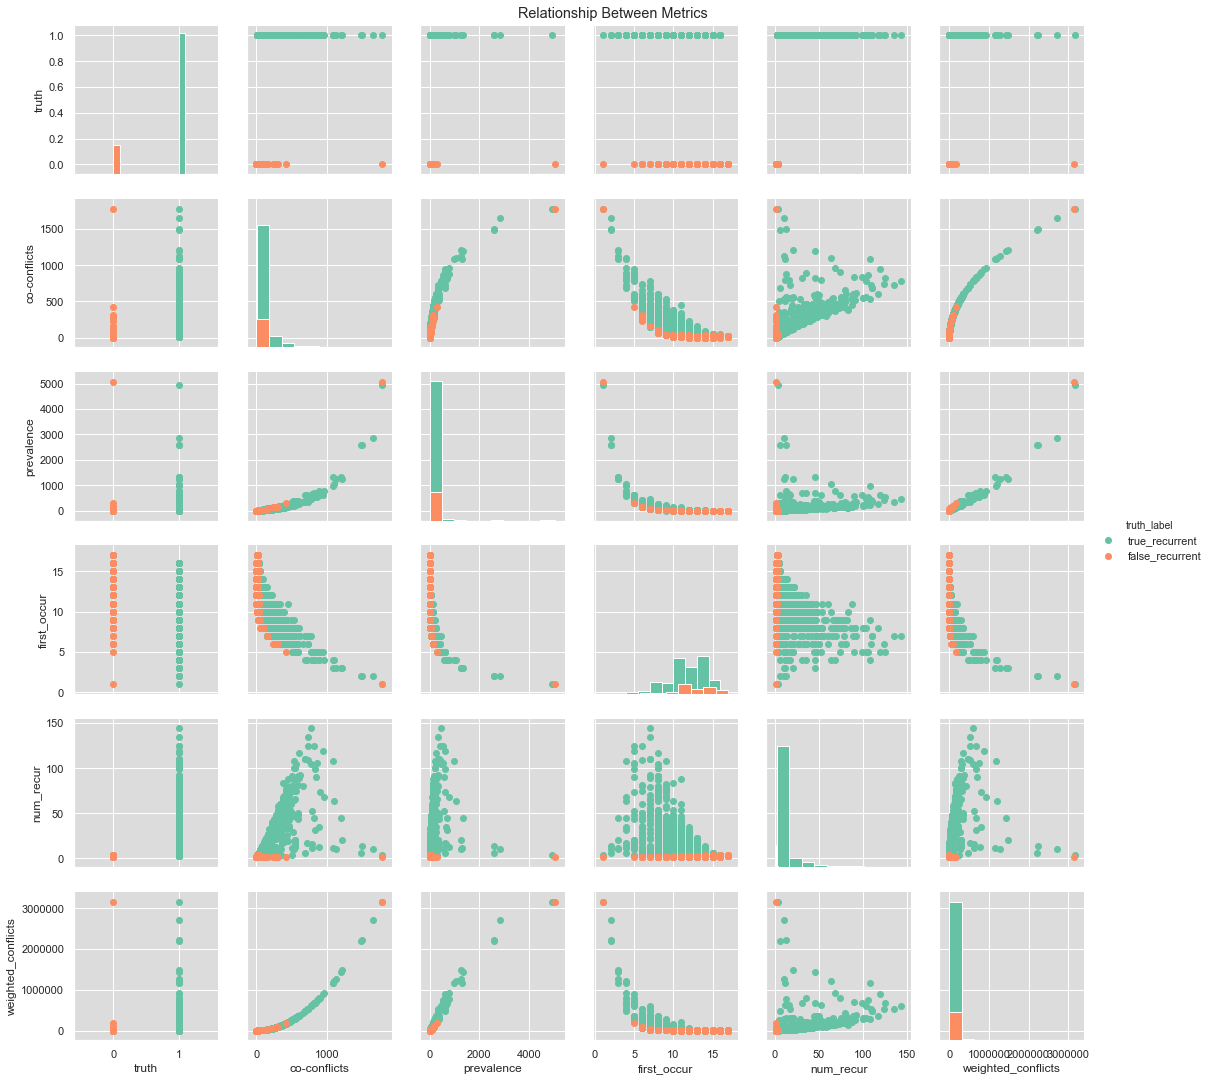

[  5.   7.   6. ...,  15.  14.  11.]


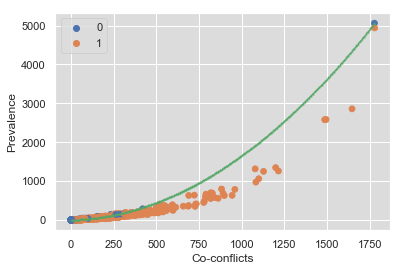

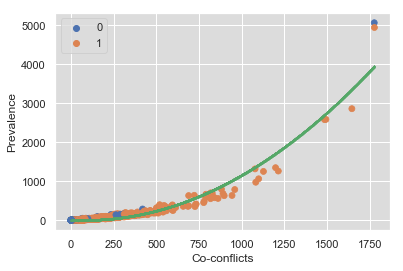

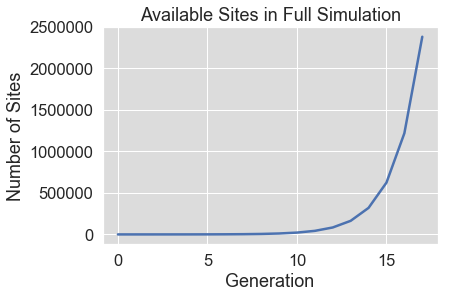

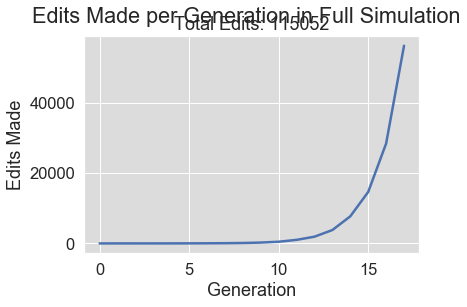

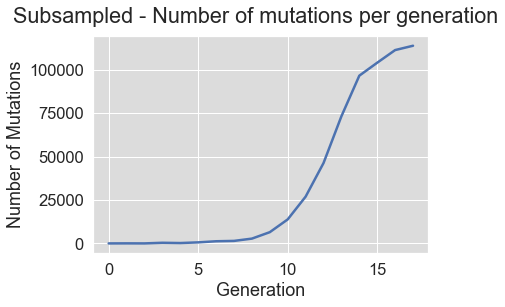

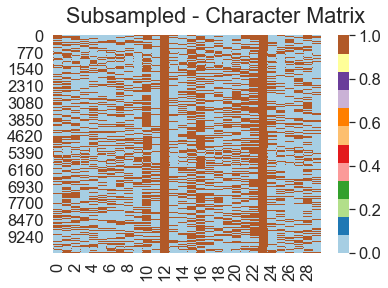

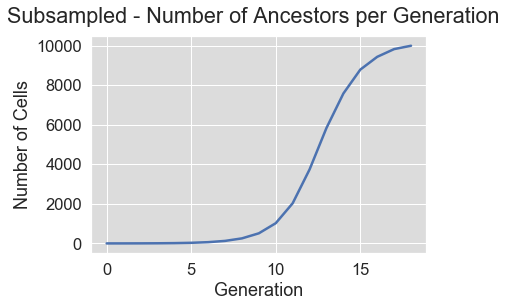

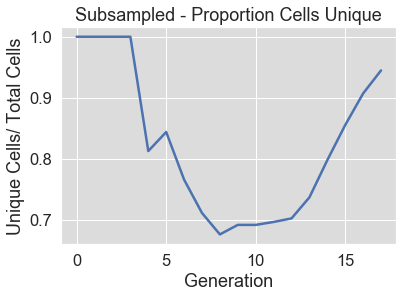

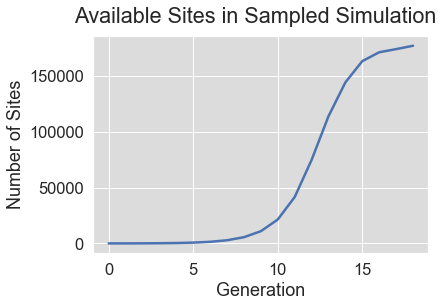

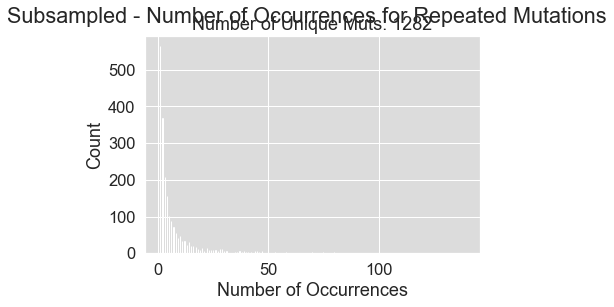

(10000, 30)
Time 1: 0.16803574562072754
Compute dictionary: 75.84722876548767
Conflict matrix is symmetric?  True
Total time: 76.09070062637329
Number of true recurrent muts:  2131
Number of detected recurrent muts:  2568
Number of true recurrent muts not detected: 0 with prevalence []


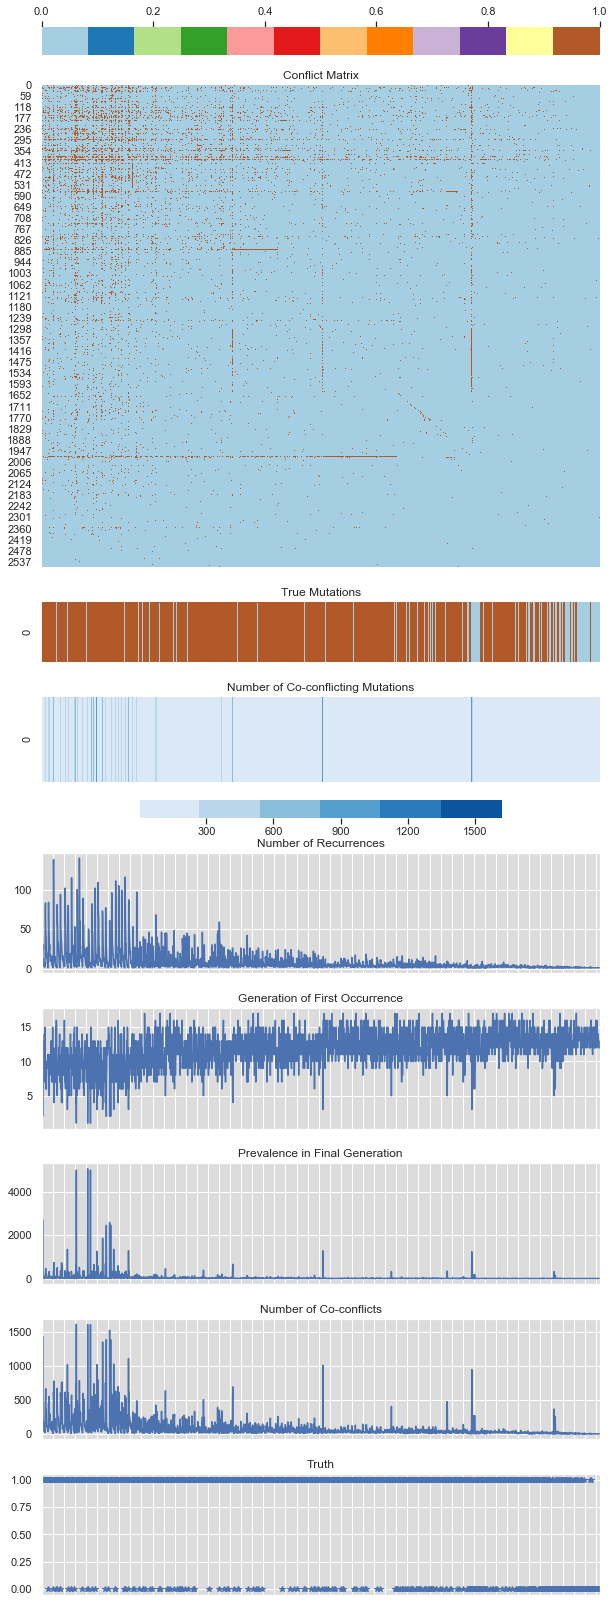

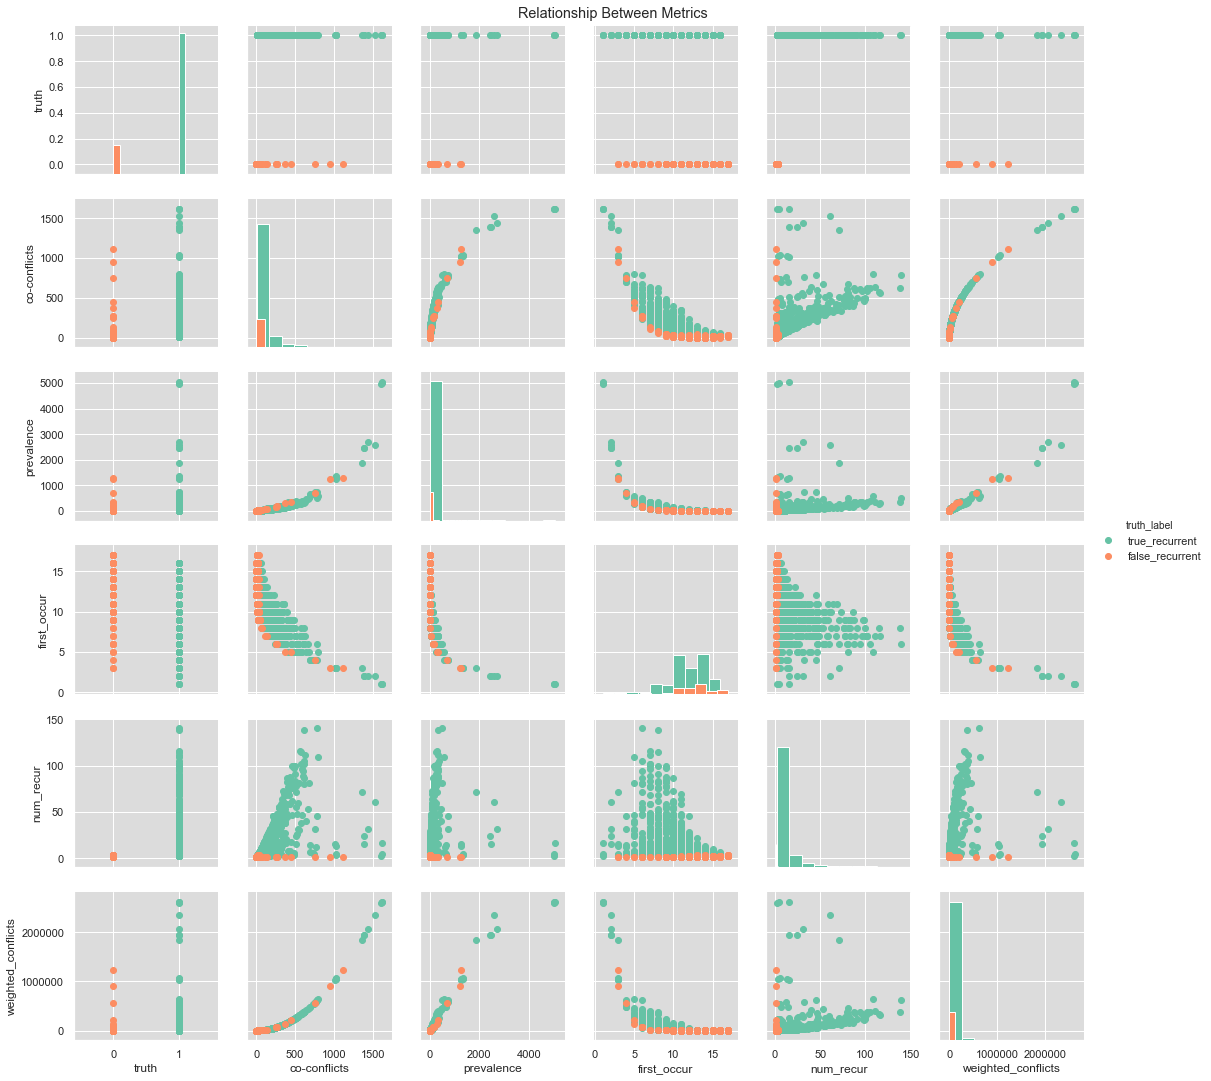

[  9.   8.  11. ...,  12.  12.  12.]


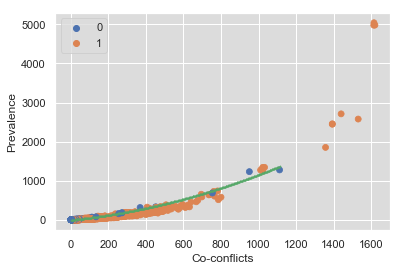

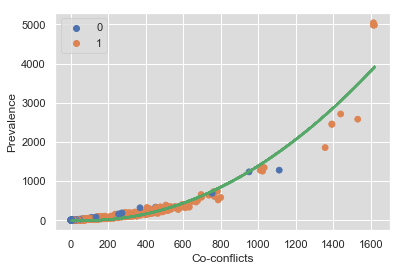

ValueError: min() arg is an empty sequence

In [11]:
simulation_list = []
for i, list_of_guides in enumerate(lists_of_guides):
    label = labels[i]
    print('Label:', label)

    # Each array has 3-6 targets, we insert ~10 arrays. This gives us 30-60 sites
    site_ix = 0
    target_distributions = {}
    speed = {}
    for guide in list_of_guides:
        dist = indel_distributions[guide]
        try:
            del dist['']
        except KeyError:
            pass
        distvals = np.array(sorted(list(dist.values()), reverse=True))
        distvals = distvals/distvals.sum()
        target_distributions[site_ix] = distvals
        if guide in slow_guides:
            speed[site_ix] = 'slow'
        elif guide in medium_guides:
            speed[site_ix] = 'medium'
        else:
            speed[site_ix] = 'fast'

        site_ix += 1

    num_targets = site_ix 
    num_edit_sites = num_targets * num_arrays

    import itertools
    targets = list(itertools.product(np.arange(num_arrays), np.arange(num_targets)))
    print('List of targets: ', targets)

    deletions = []
    mutation_probs = []
    for array, target in targets:
        deletions.append(target_distributions[target])
        mutation_probs.append(rate[speed[target]])
    
    deletions_probs = pd.DataFrame(deletions)
    deletions_probs = torch.DoubleTensor(deletions_probs.fillna(0.0).values)
    
    # Each edit site has a different mutation probability 
    mutation_probs= np.array(mutation_probs)


    for run in range(num_runs):
        simulation = lineageSimulation(label, tree_depth, num_edit_sites, deletions_probs, mutation_probs)
           
        # Summarize results
        # Plot a regression for the non-recurrent mutations
        X = simulation.conflict_matrix.sum(0)
        Y = simulation.prevalence_tape
        ix = np.array(simulation.truth_tape)==0

#         from sklearn.linear_model import LinearRegression
#         reg = LinearRegression().fit(X[ix].reshape(-1,1), Y[ix].reshape(-1,1))
        
        x = X[ix]
        y = Y[ix]
        
        new_x = np.linspace(min(x), max(x), num=np.size(x))
        coefs = np.polyfit(x,y,2)
        new_line = np.polyval(coefs, new_x)
            
        plt.figure()
        sns.scatterplot(X, Y, hue=simulation.truth_tape, 
                        cmap='Paired', edgecolor=None,)

        plt.scatter(new_x,new_line,c='g', marker='^', s=1)
        plt.xlabel('Co-conflicts')
        plt.ylabel('Prevalence')
        plt.show()
        plt.close()
        
        simulation.random_attr['coef'] = coefs
        
        
        simulation.random_attr['num_conflict'] = simulation.conflict_matrix.shape[0]
        
        x = X
        y = Y
        
        new_x = np.linspace(min(x), max(x), num=np.size(x))
        coefs = np.polyfit(x,y,2)
        new_line = np.polyval(coefs, new_x)
        
        
        
        plt.figure()
        sns.scatterplot(X, Y, hue=simulation.truth_tape, 
                        cmap='Paired', edgecolor=None,)

        plt.scatter(new_x,new_line,c='g', marker='^', s=1)
        plt.xlabel('Co-conflicts')
        plt.ylabel('Prevalence')
        plt.show()
        plt.close()
        
        simulation.random_attr['full_reg_coef'] = coefs
        
        simulation_list.append(simulation)

        df = pd.DataFrame(subsampled_results)
for y in ['Total_Mutations','Distinct_Mutations','Recurring_Mutations','Recurring_Mutations_%', 'Unique_Cells']:
    plt.figure()
    ax = sns.boxplot(x='Guides', y=y, data=df) 
    plt.title(y)
    plt.show()
    plt.close()

df = pd.DataFrame(results)
for y in ['Num_Distinct_Edits', 'Min_depths', 'Num_Mutations','Recurring_Characters','Recurring_Characters_%','Recurring_Mutations','Recurring_Mutations_%']:
    plt.figure()
    ax = sns.boxplot(x='Guides', y=y, data=df) 
    plt.title(y)
    plt.show()
    plt.close()



In [ ]:
simulation

## Evaluating the Effectiveness of Dropping Recurrent Mutations 

### Removal by Fitted Prevalence-Conflict Curve

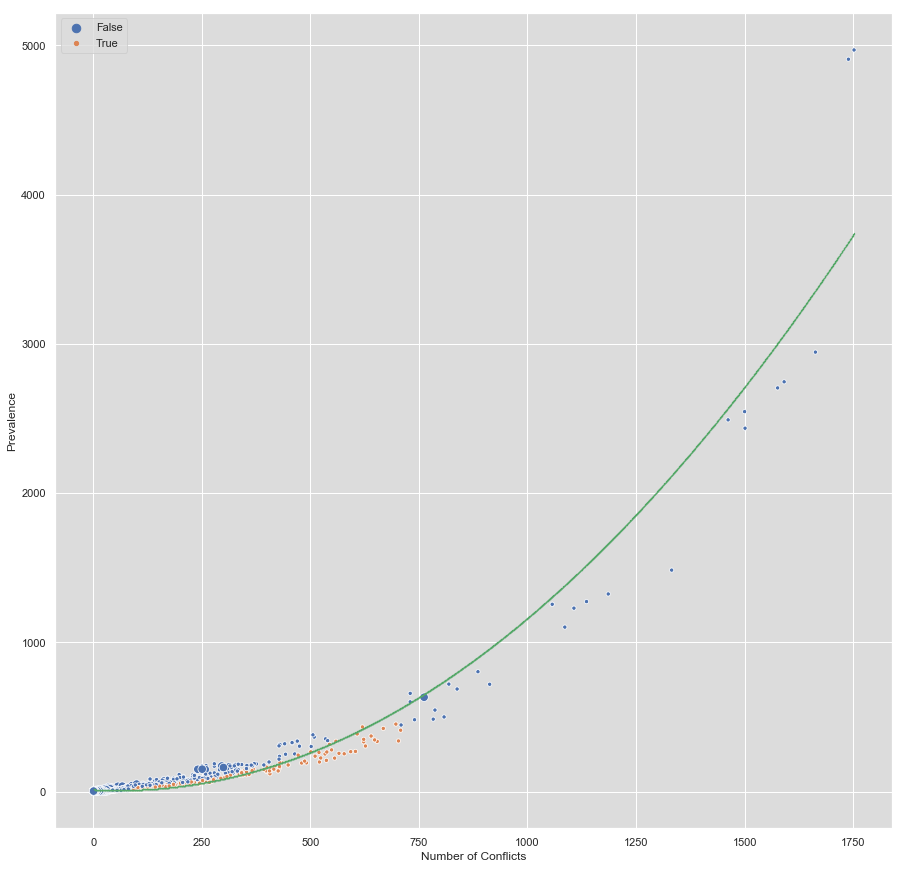

Percent truly identified as bad: 100.0
Proportion of total eliminated:  14.657738095238095
[  8.   7.   9. ...,  14.  13.  12.]


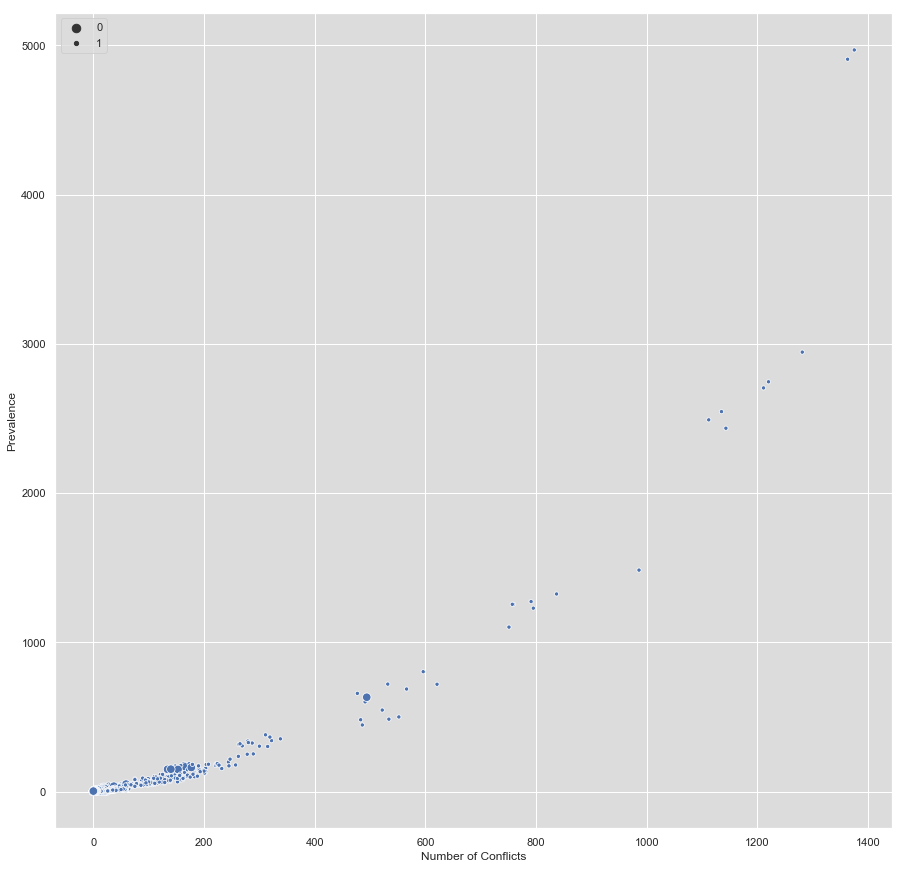

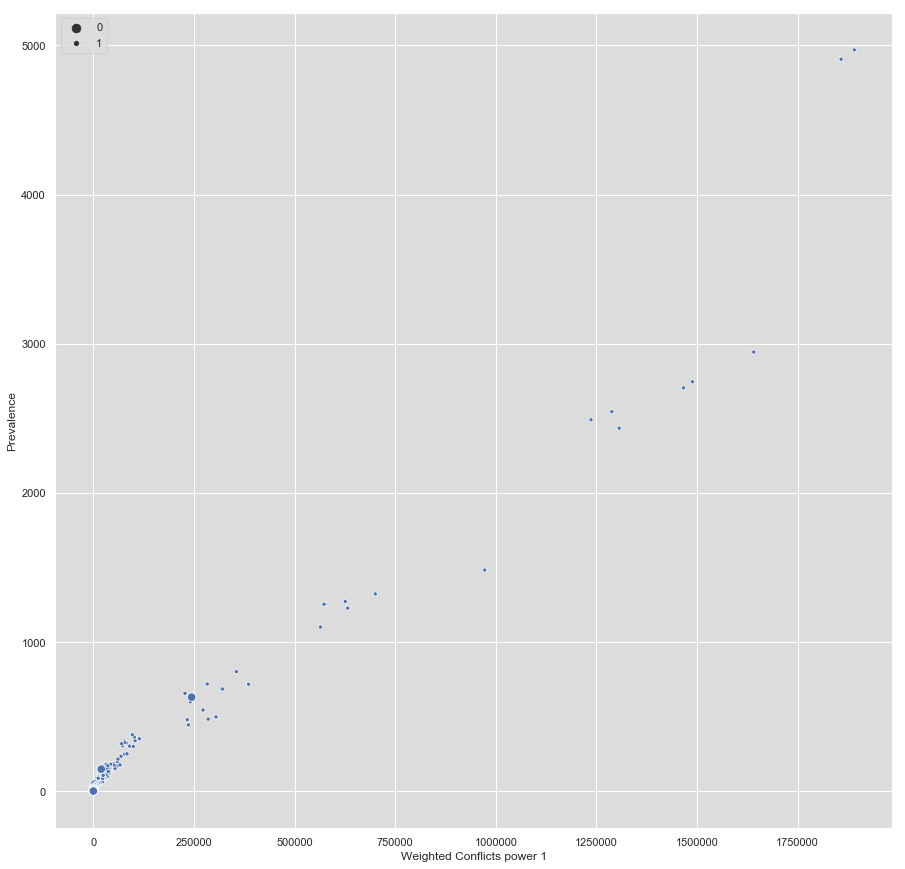

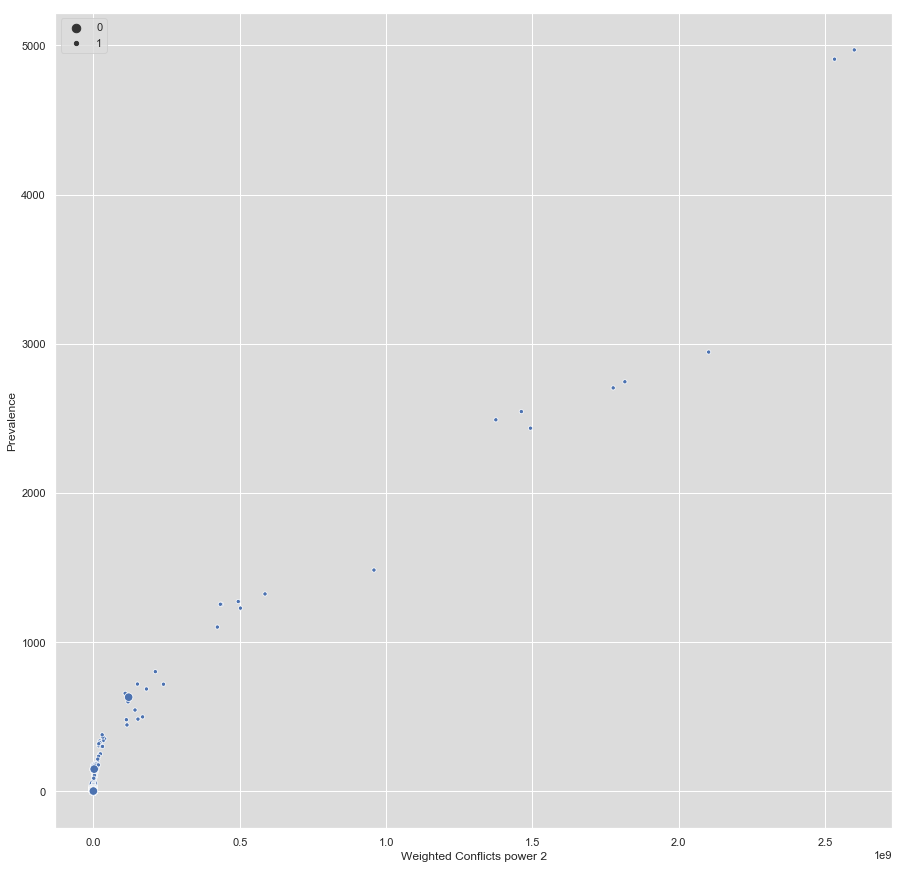

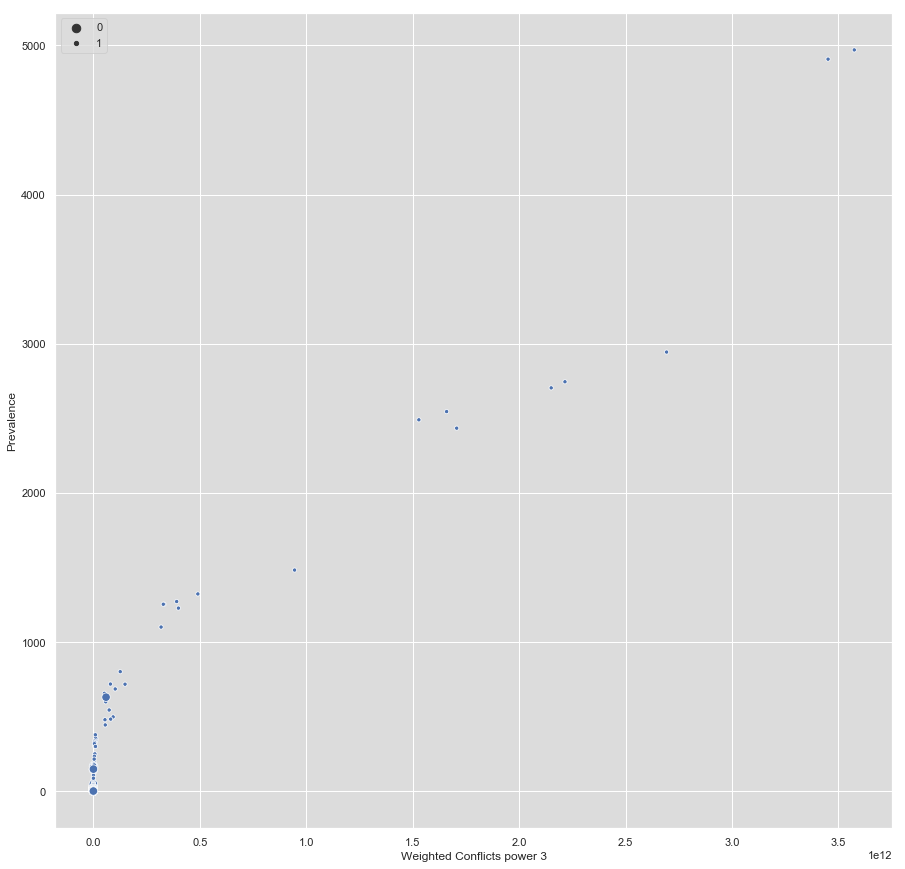

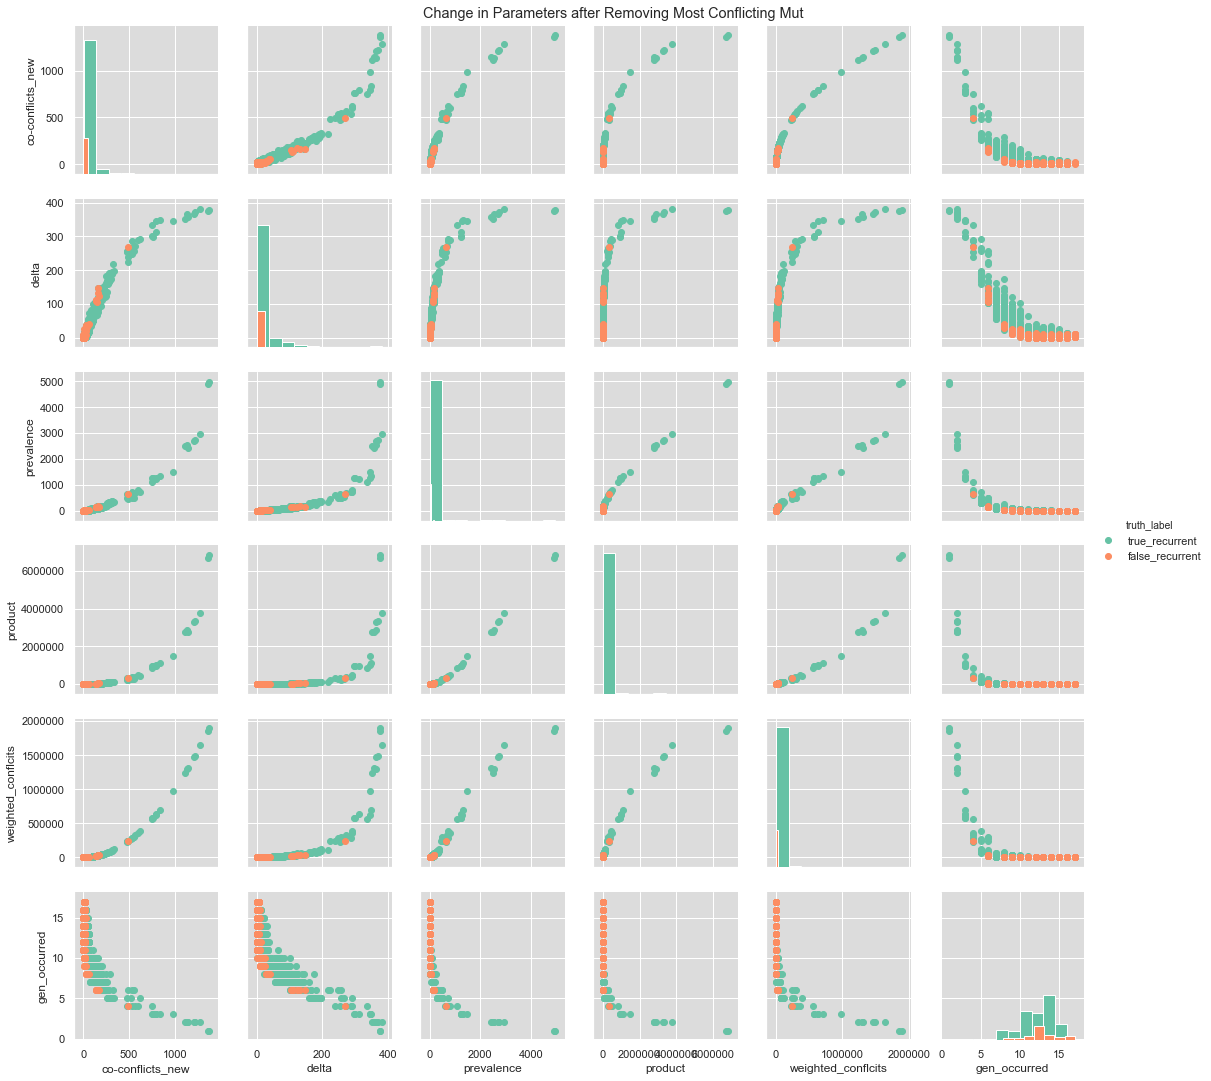

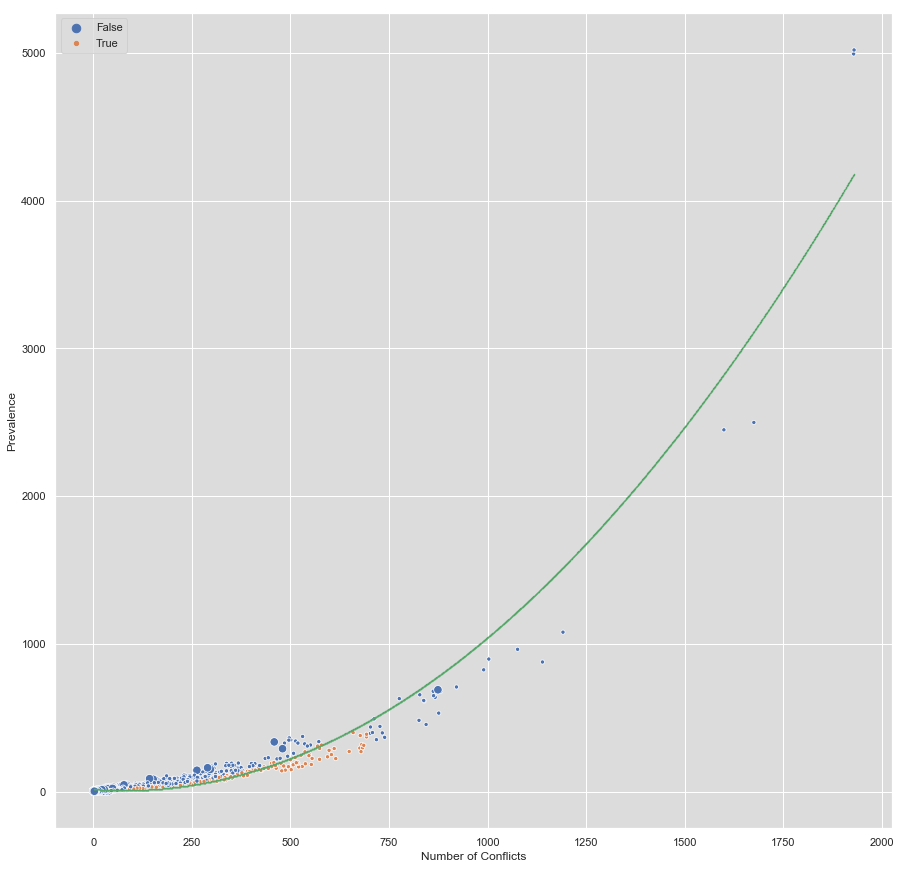

Percent truly identified as bad: 100.0
Proportion of total eliminated:  10.290514525726286
[  7.   7.   5. ...,  14.  13.  14.]


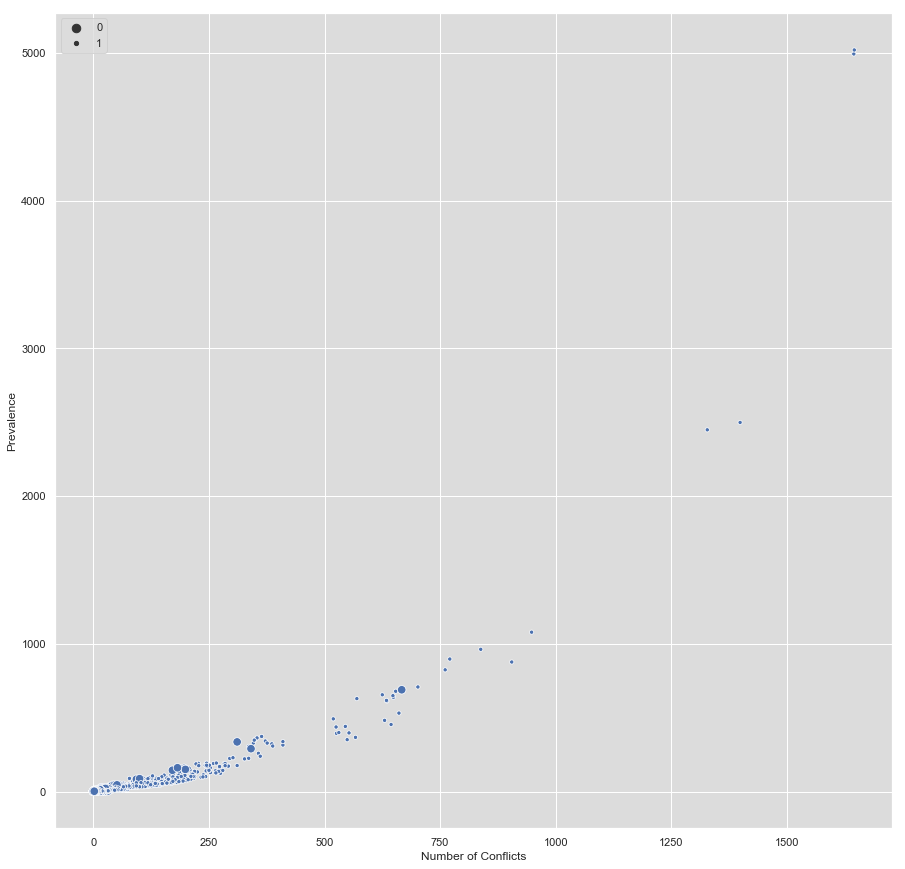

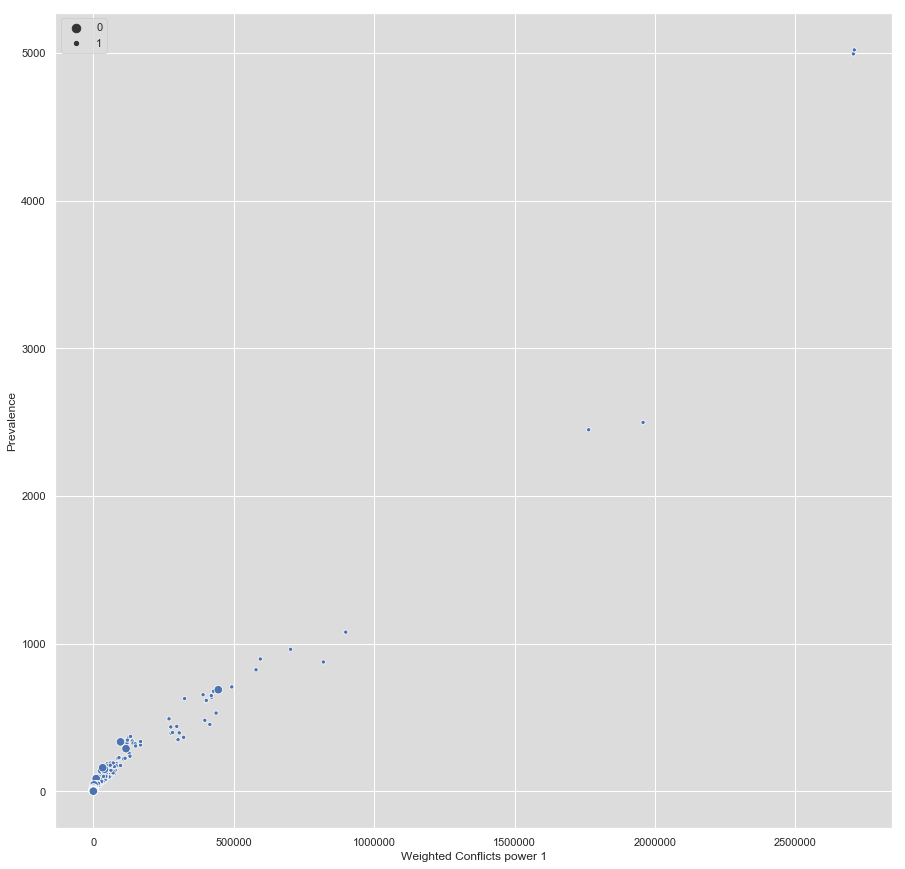

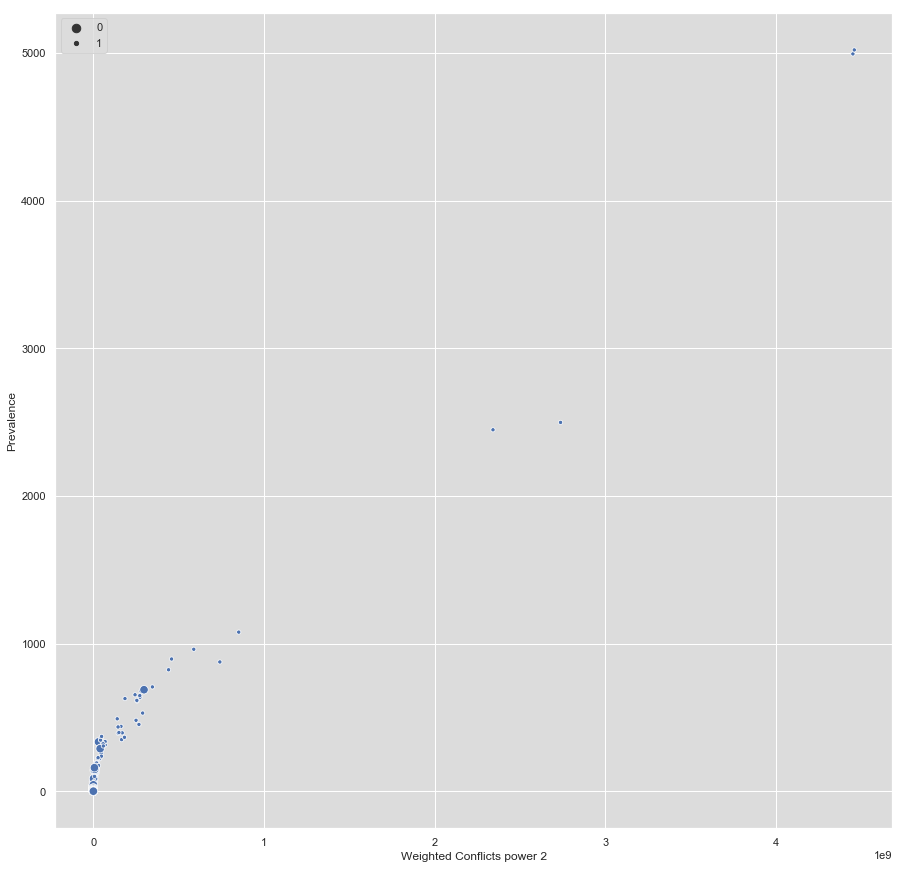

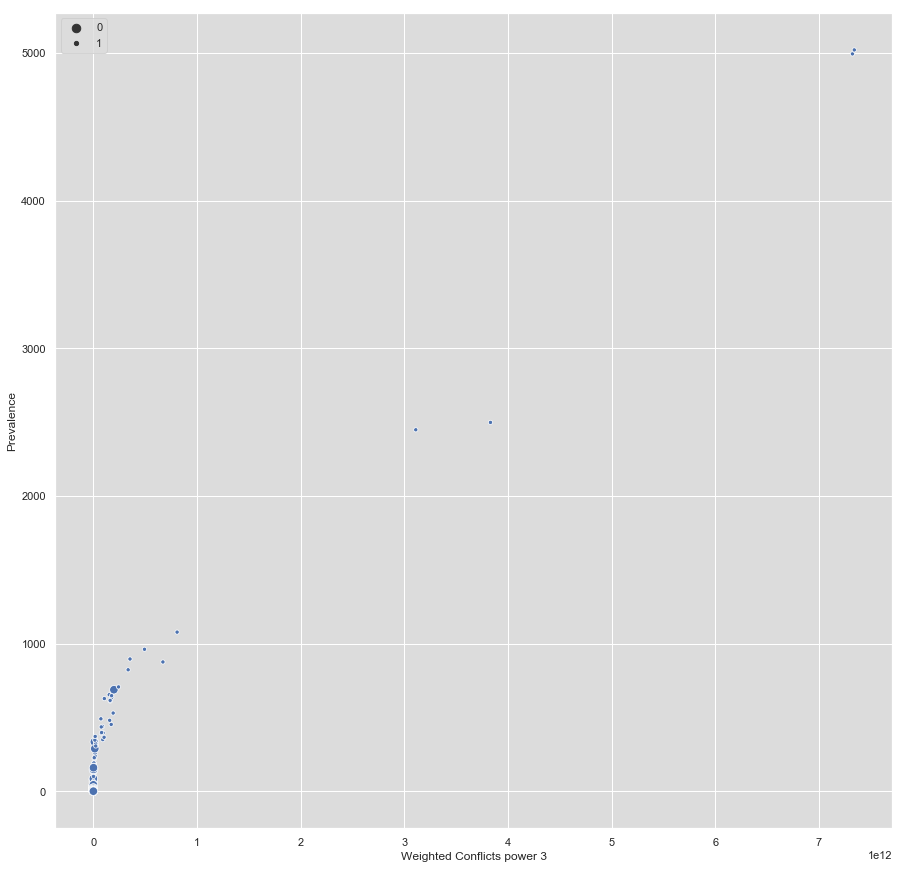

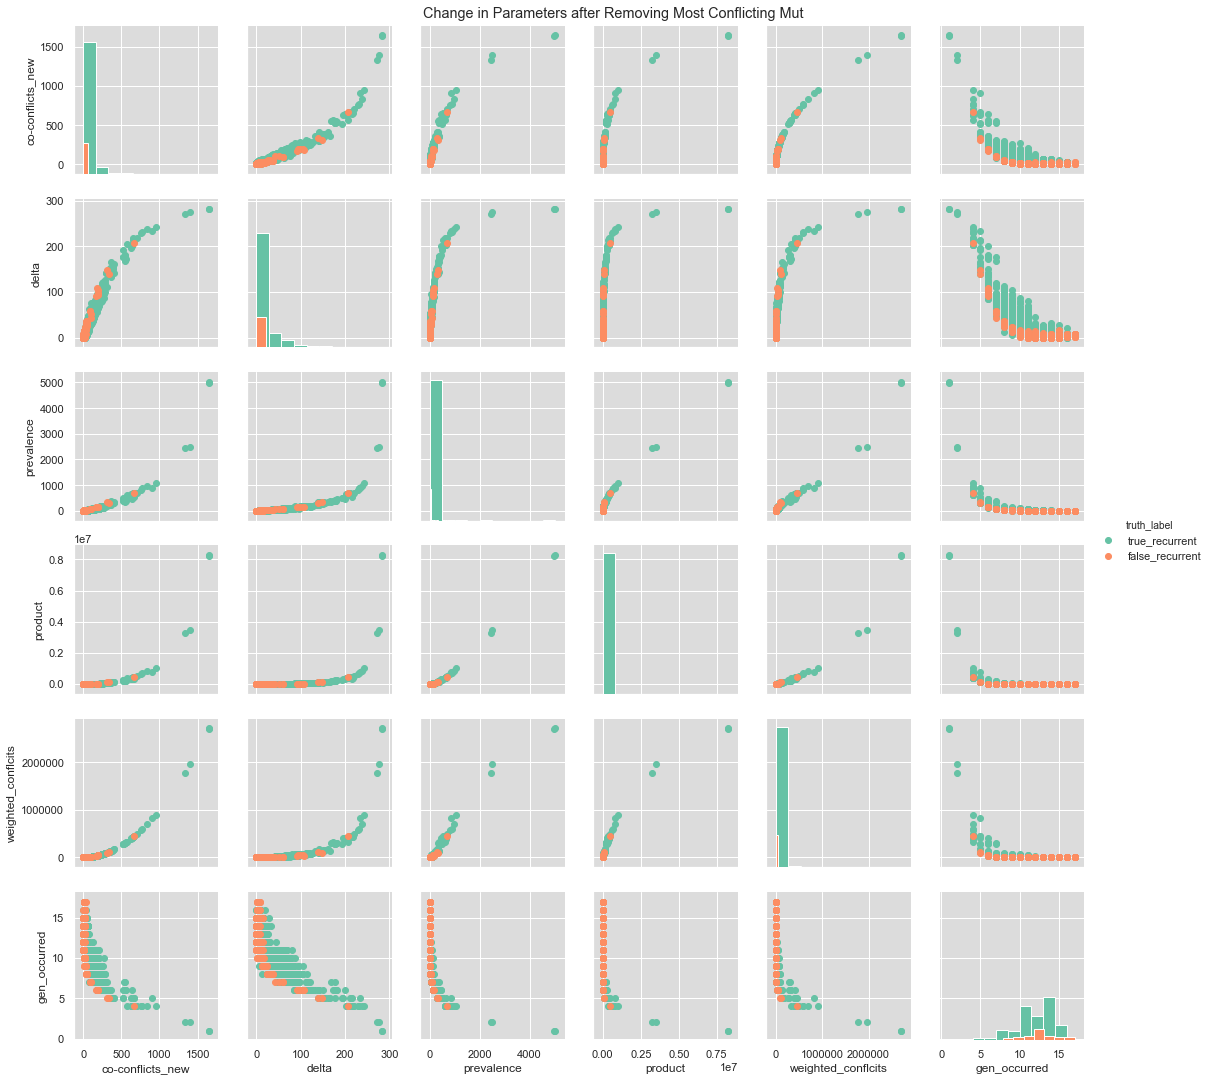

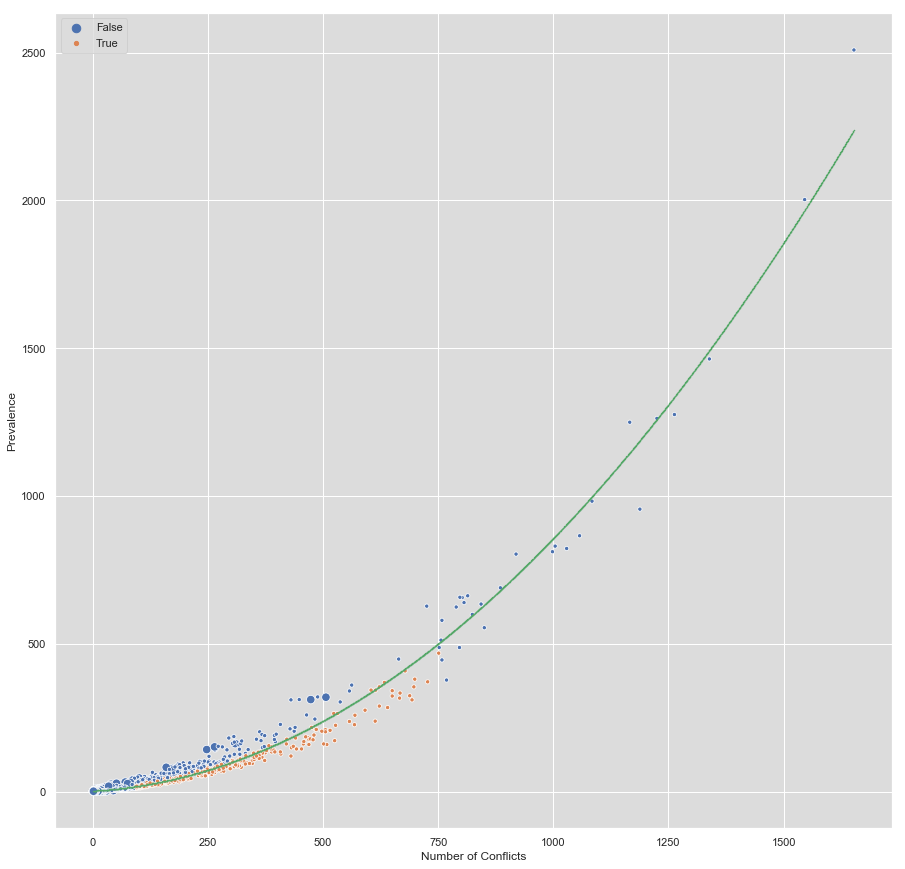

Percent truly identified as bad: 100.0
Proportion of total eliminated:  15.25915186661834
[  6.  10.   8. ...,  14.  13.  15.]


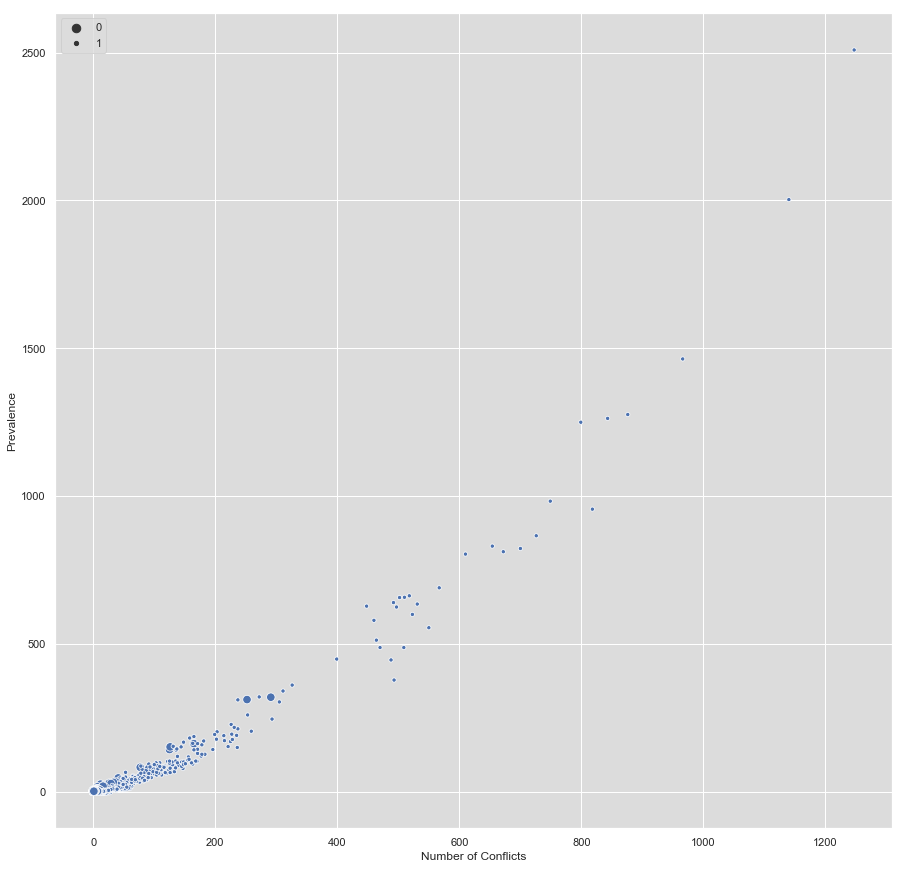

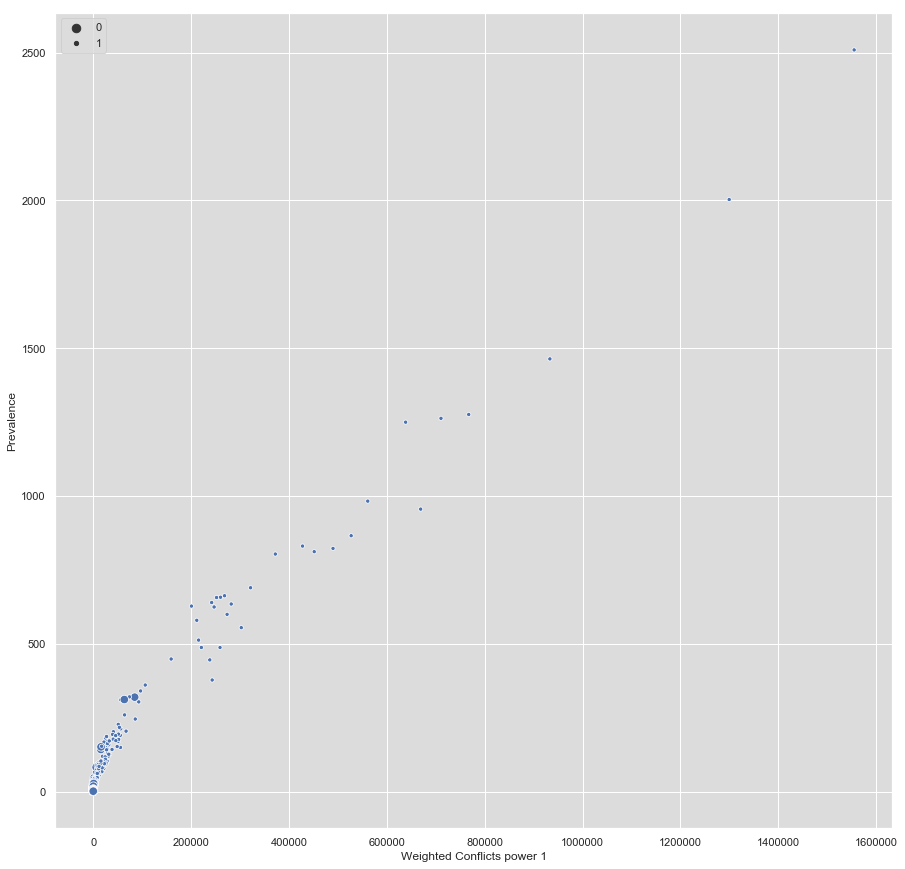

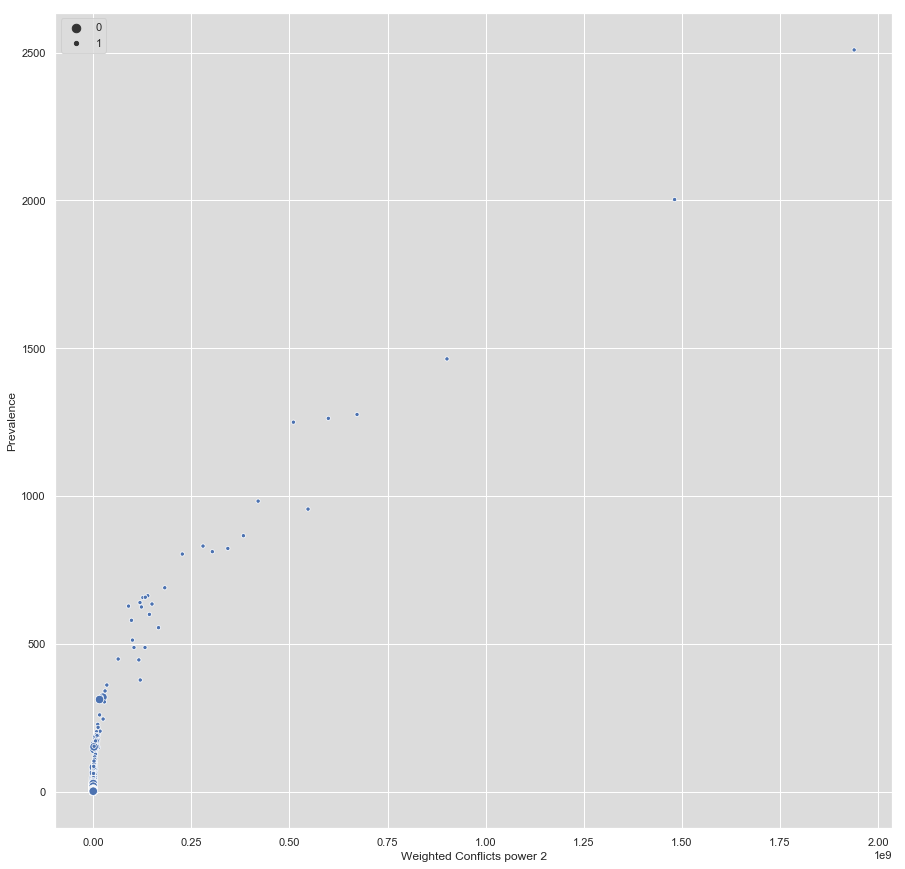

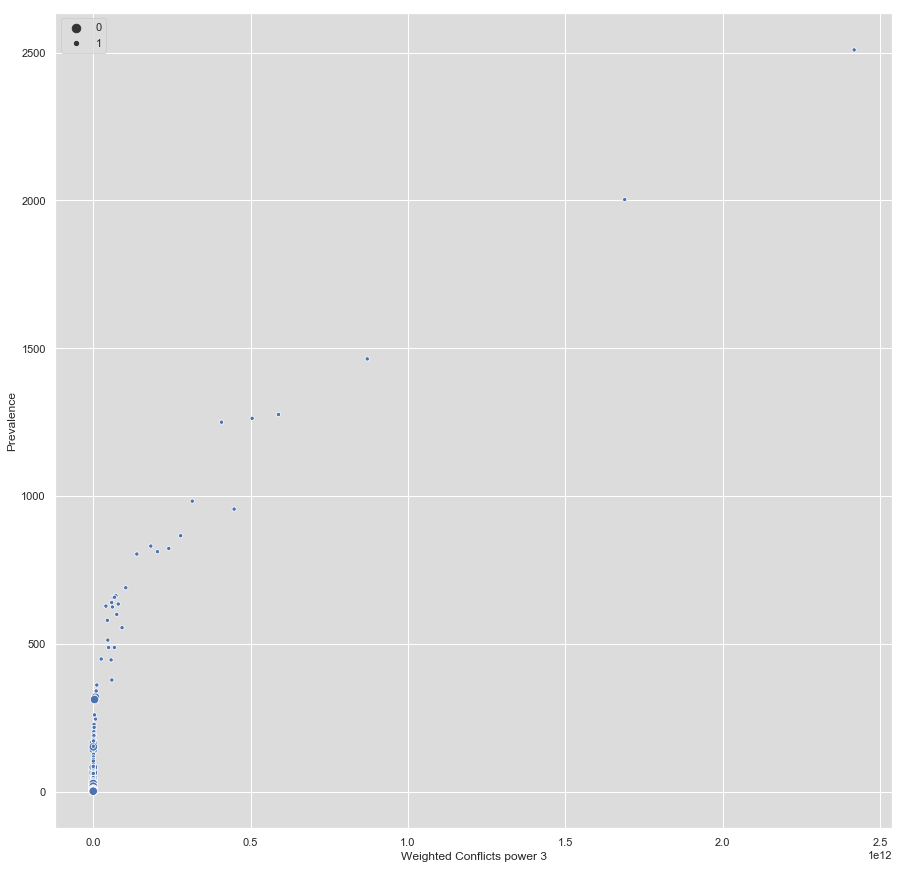

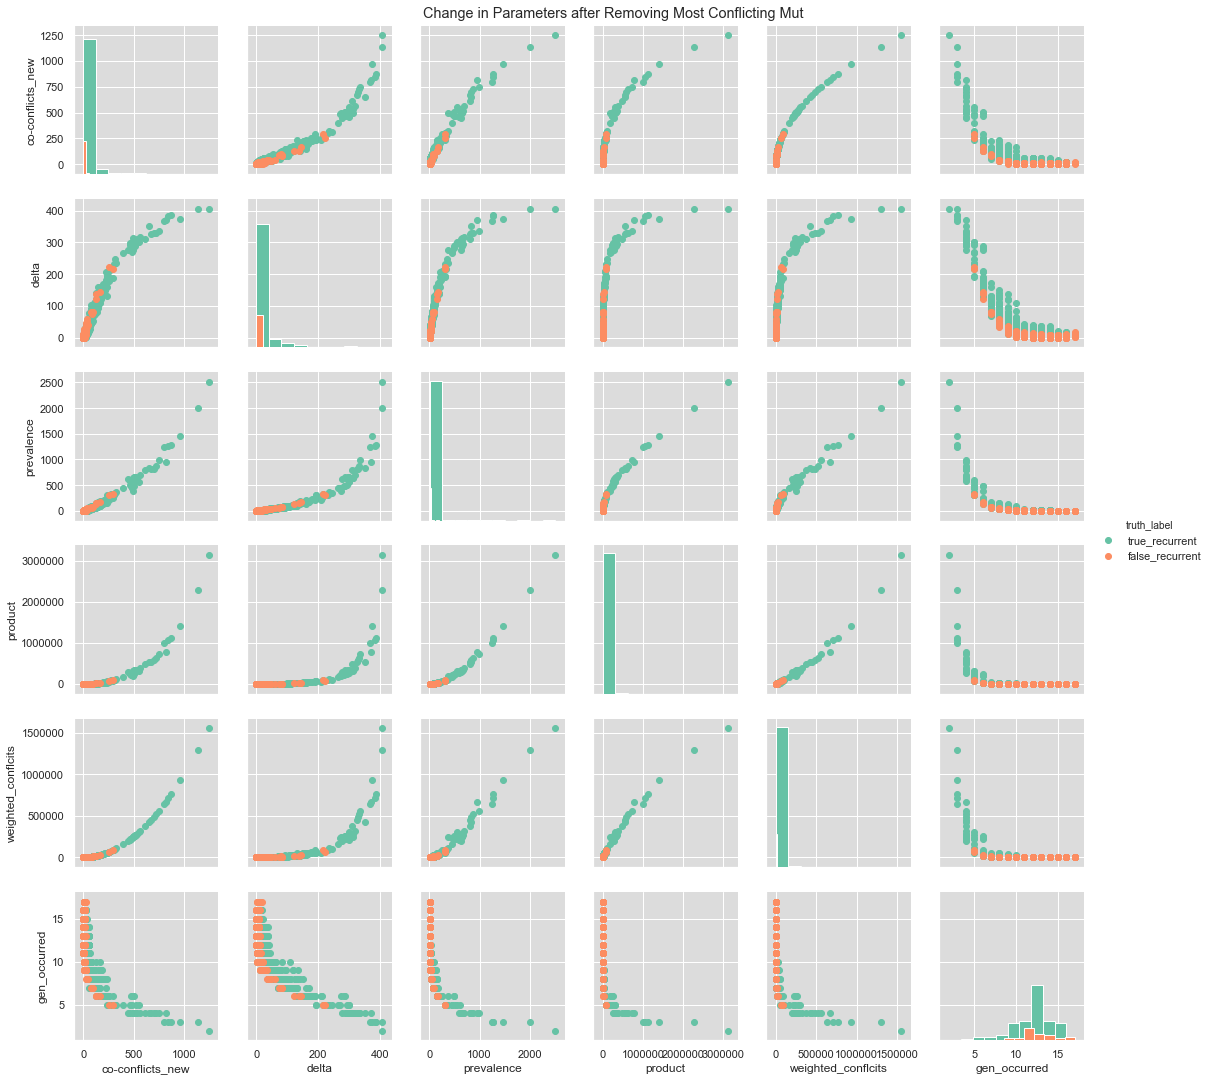

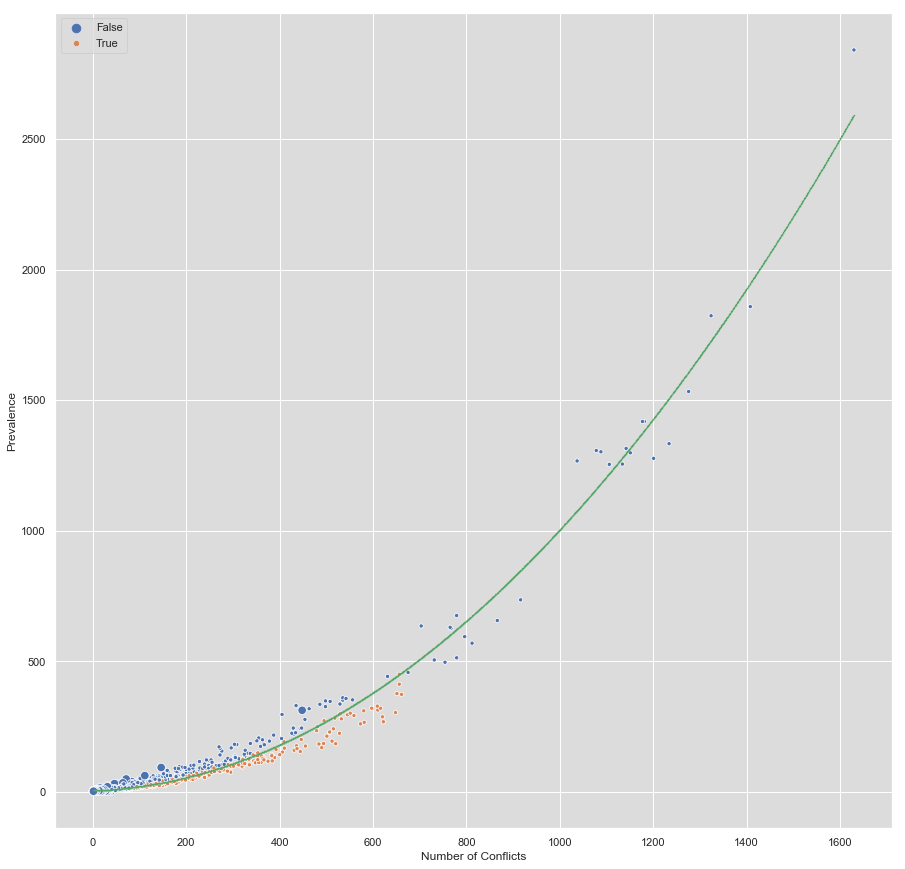

Percent truly identified as bad: 100.0
Proportion of total eliminated:  13.912375096079938
[  5.   7.  11. ...,  15.  13.  14.]


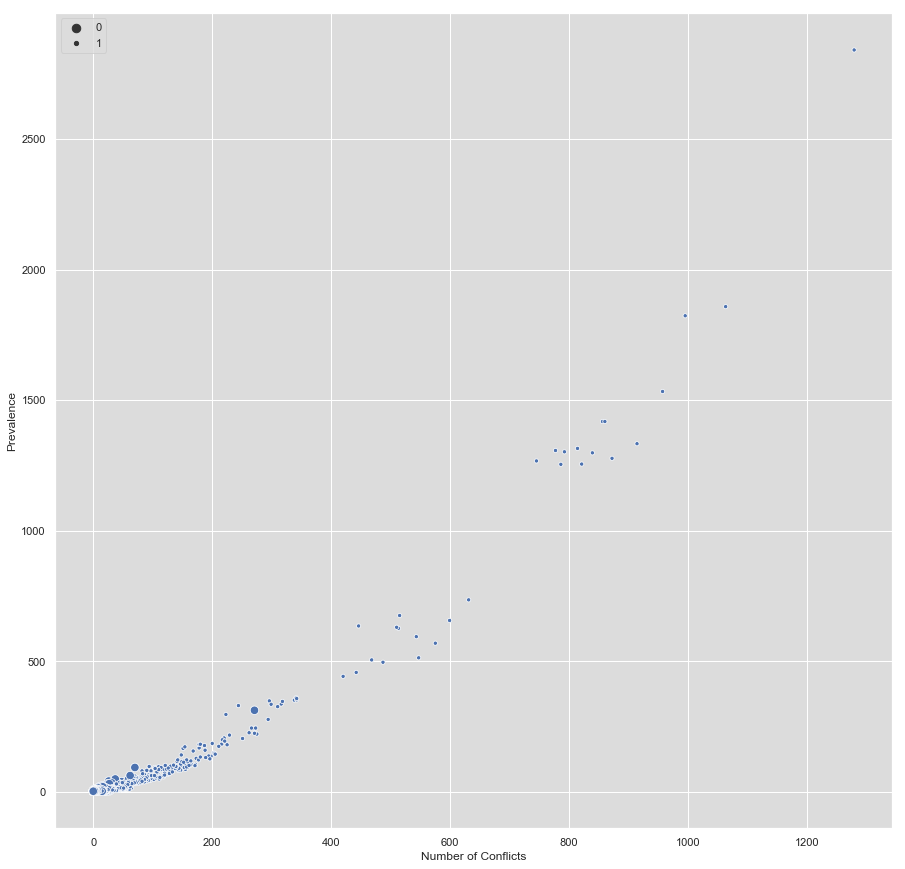

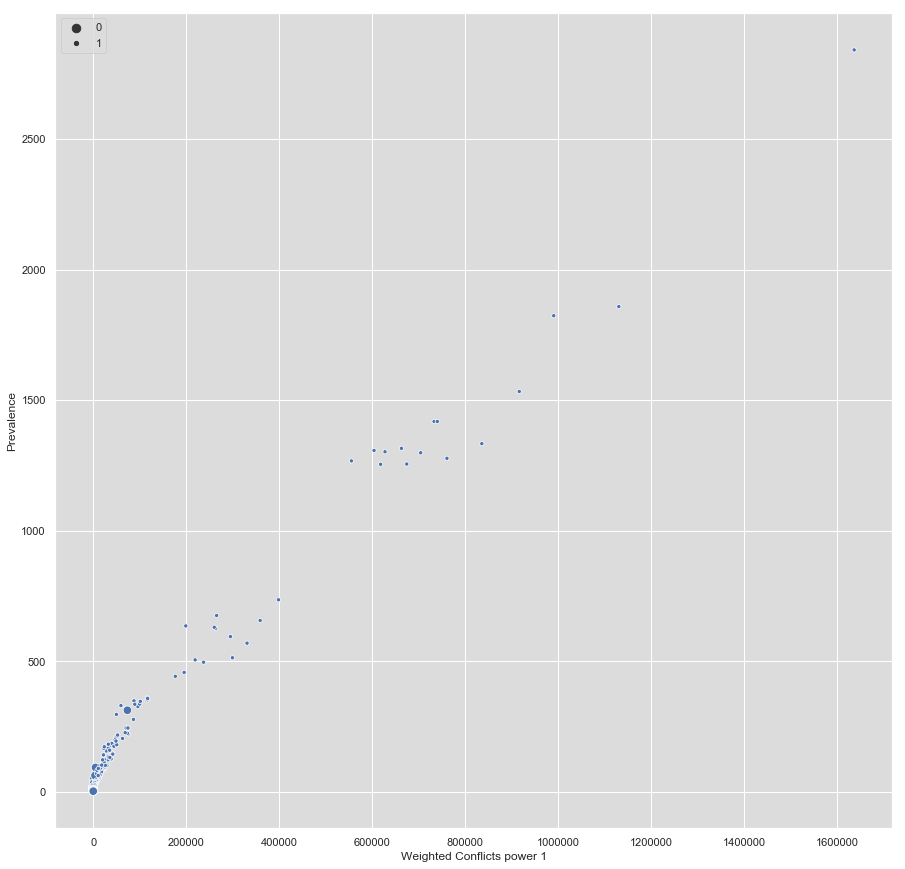

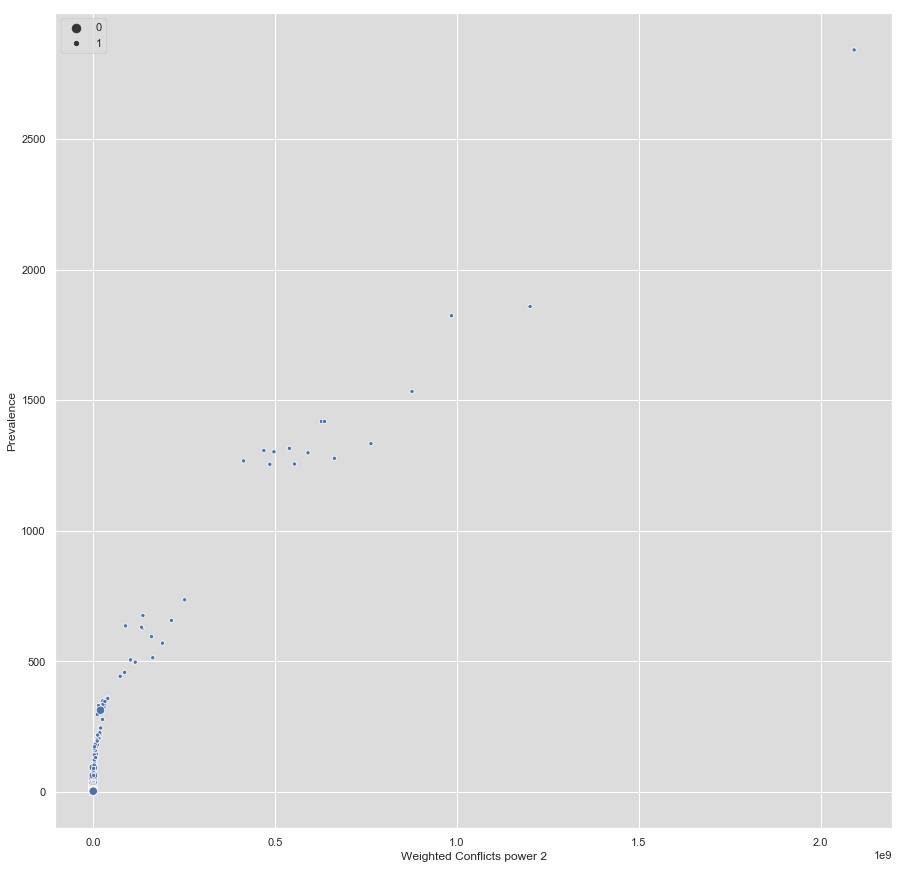

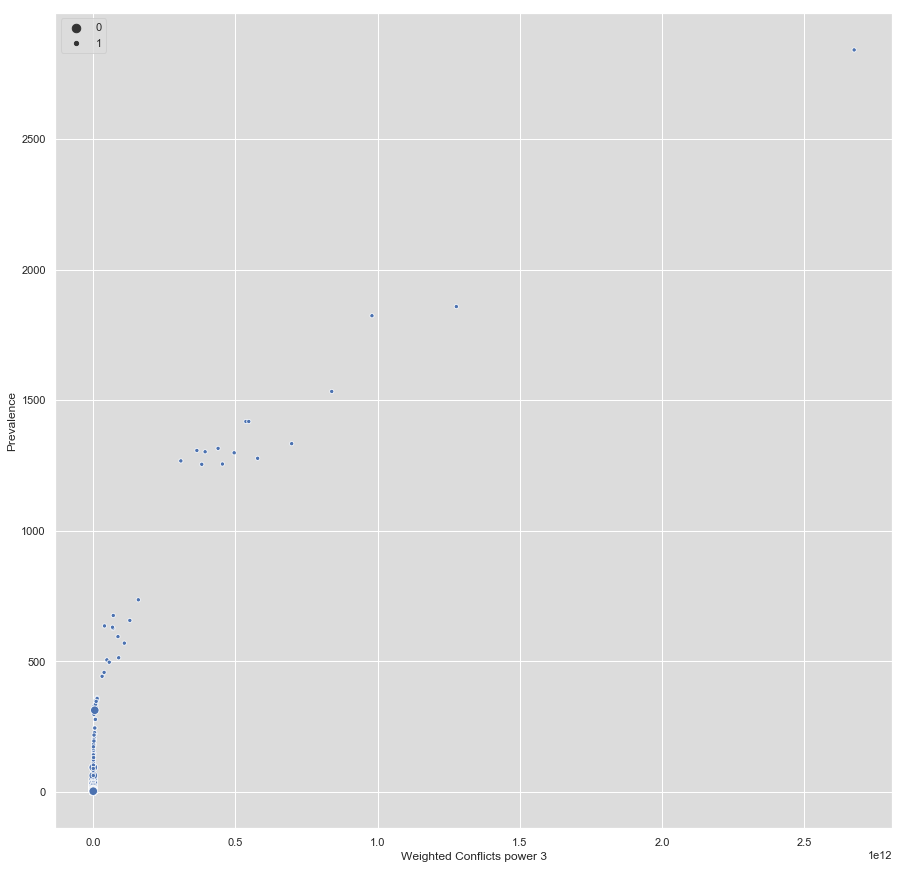

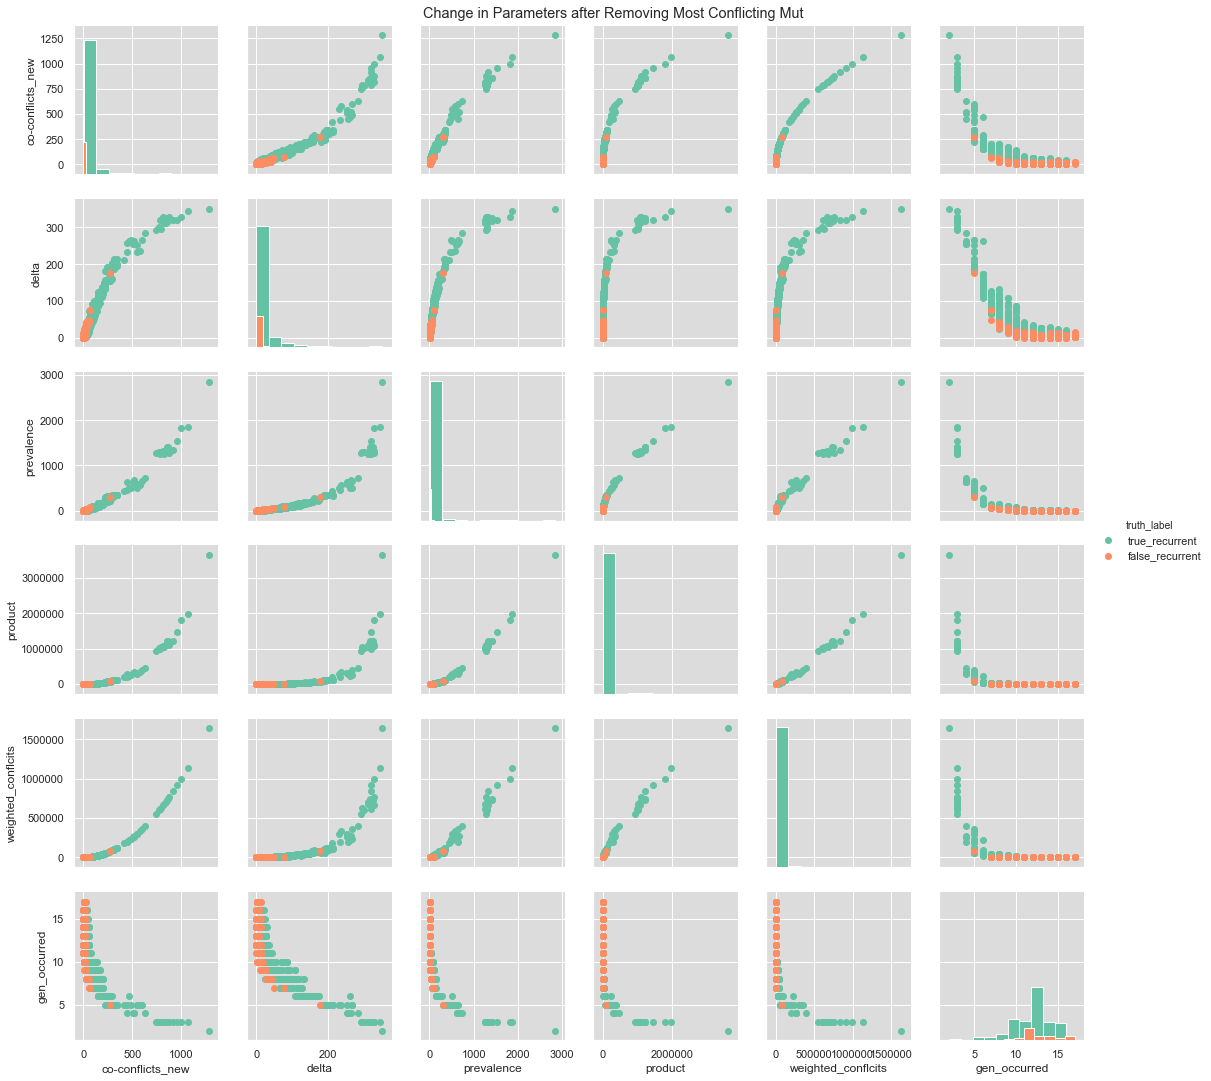

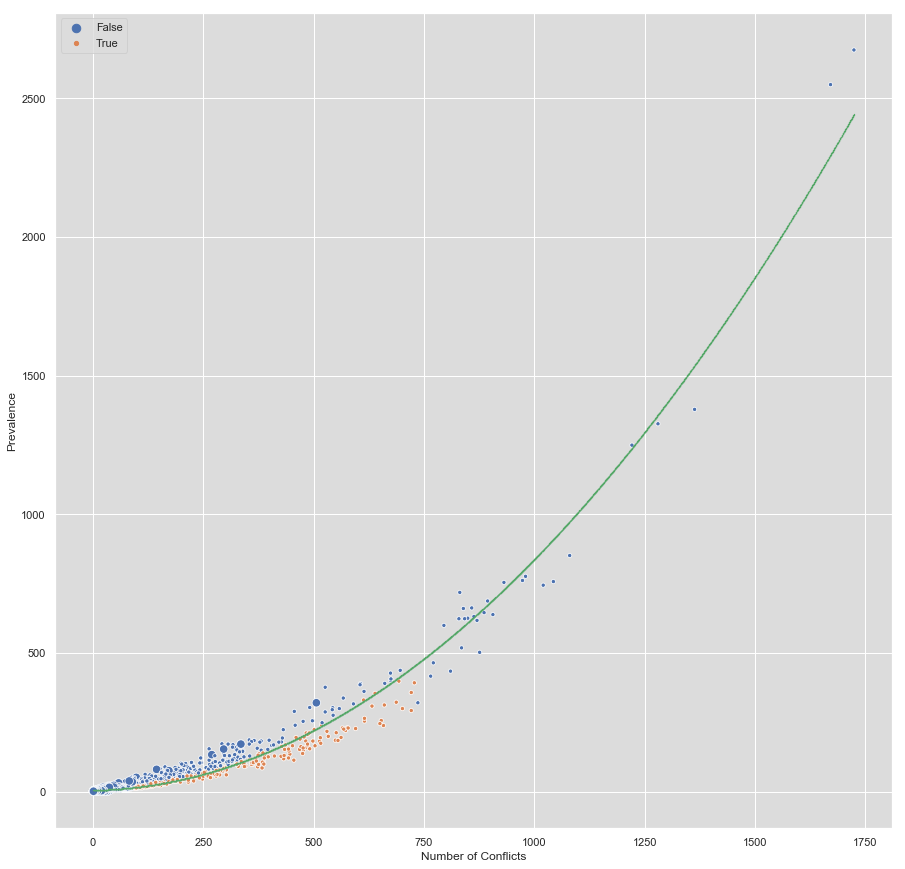

Percent truly identified as bad: 100.0
Proportion of total eliminated:  13.680555555555555
[  8.   9.   8. ...,  15.  16.  13.]


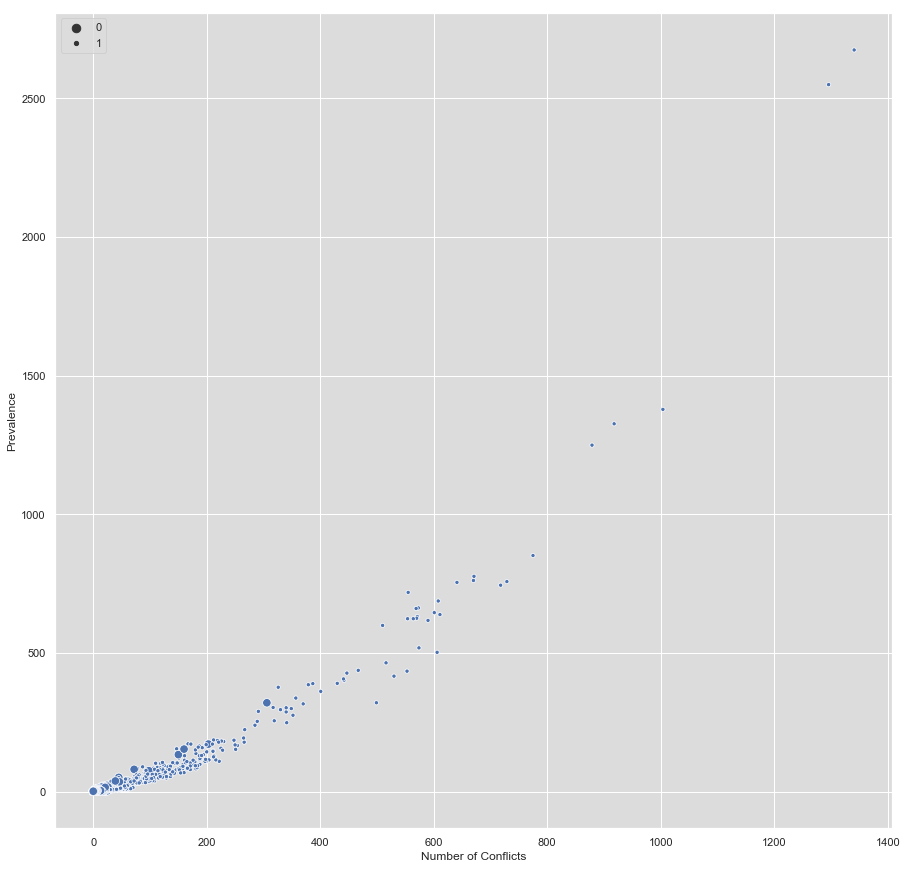

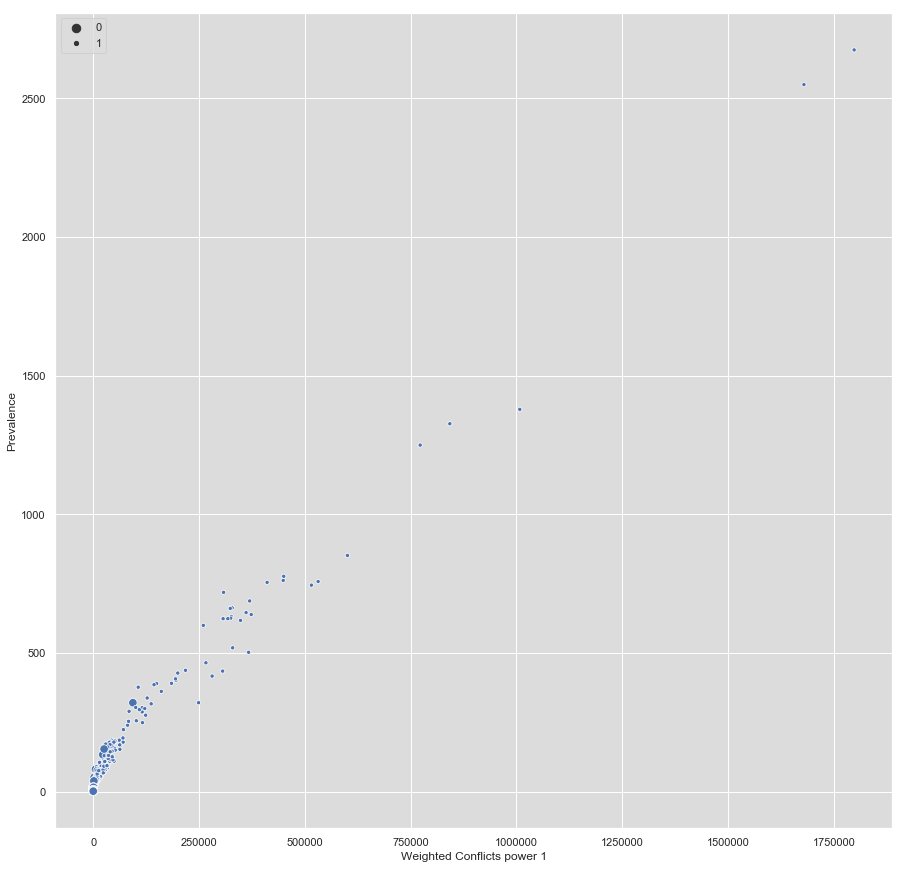

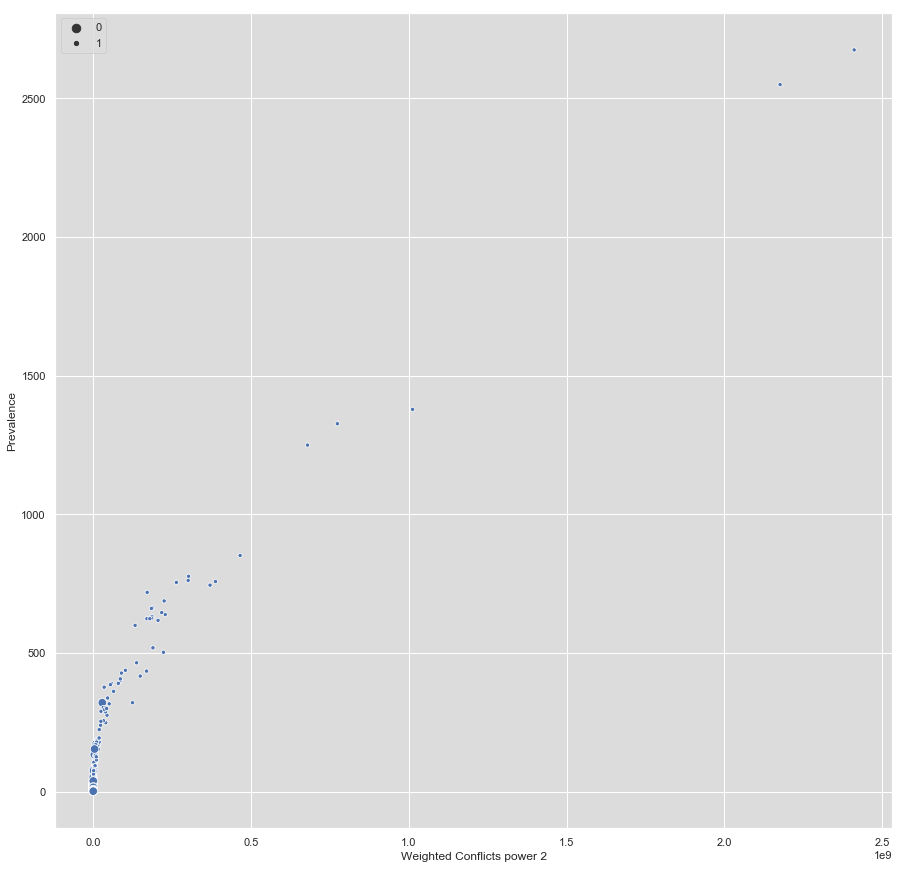

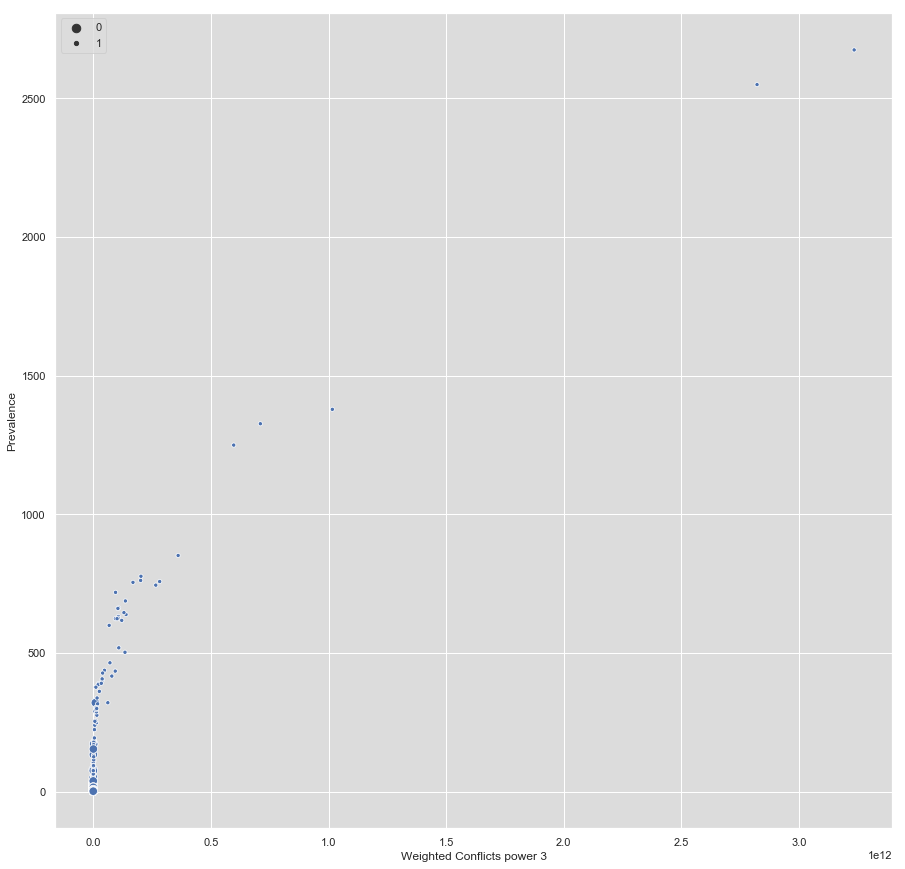

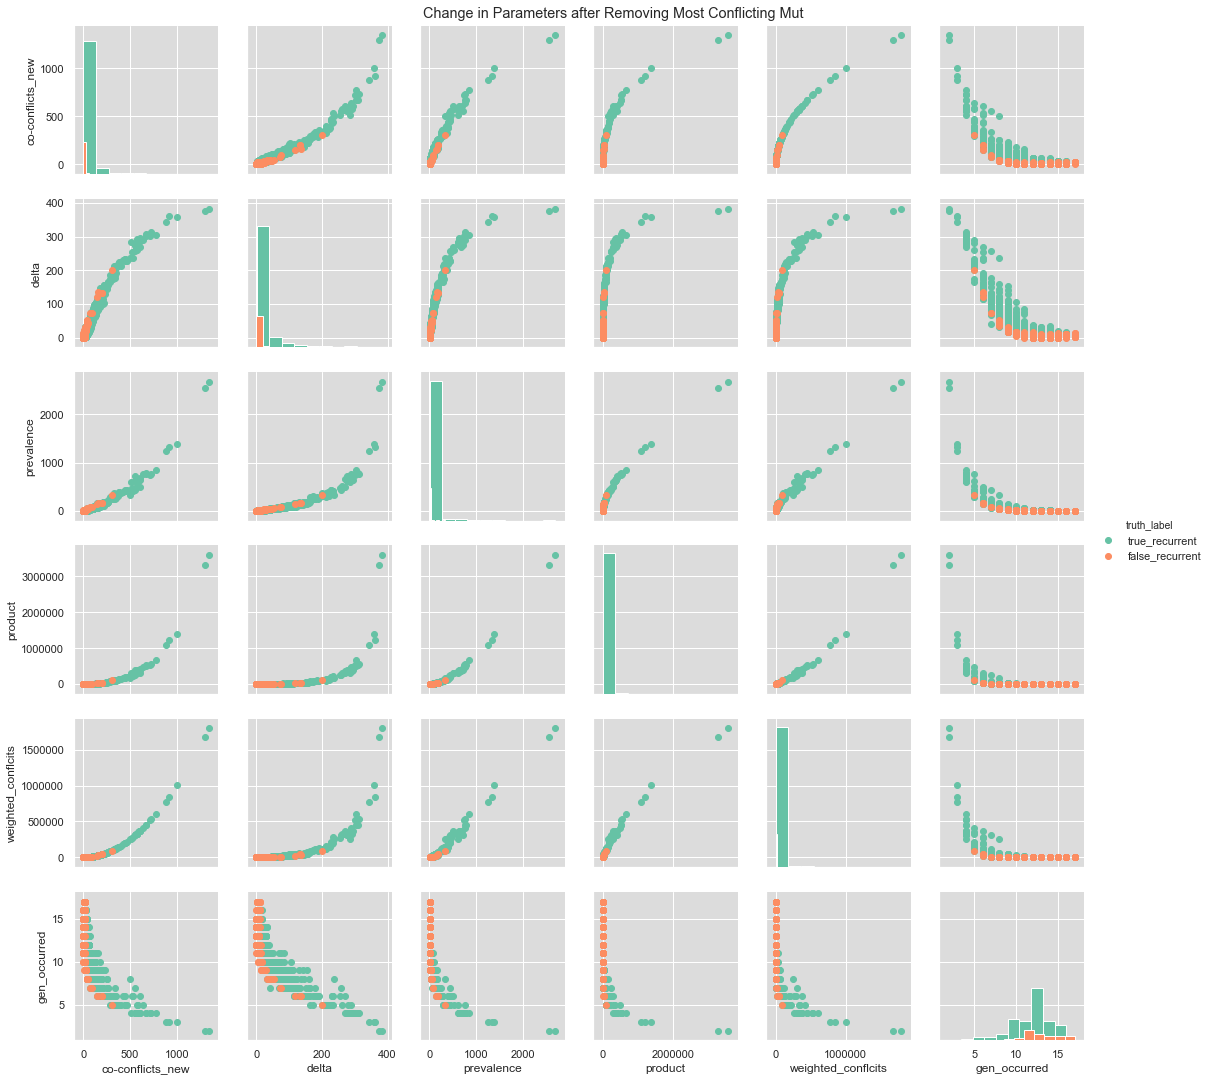

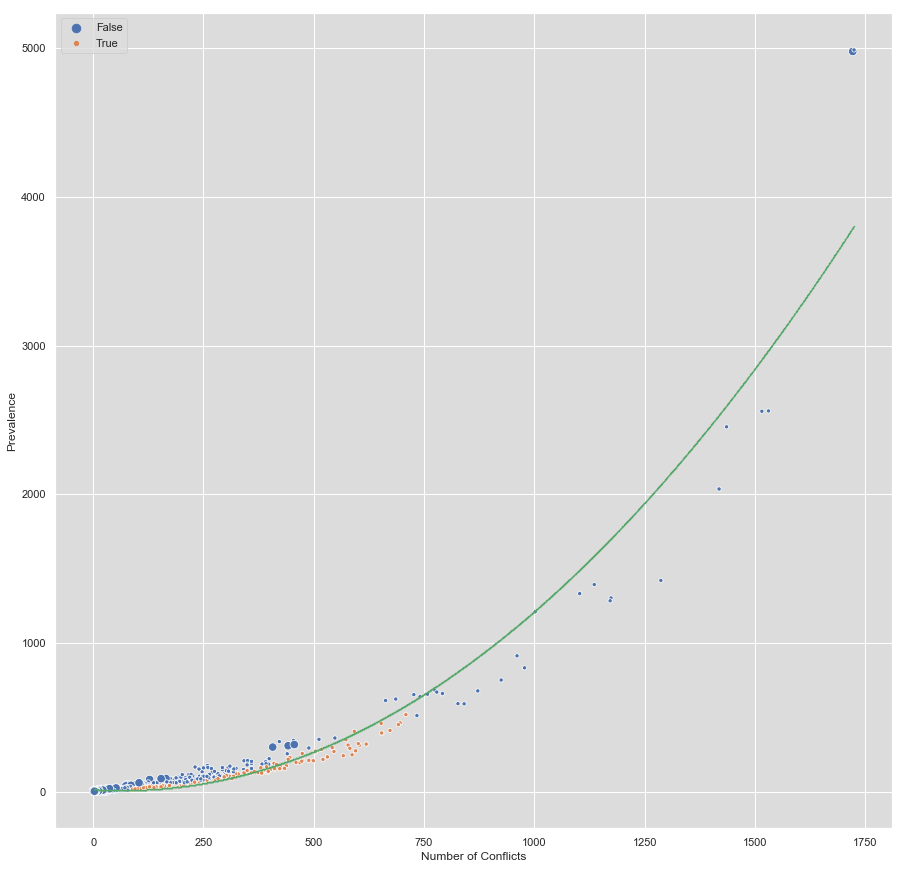

Percent truly identified as bad: 100.0
Proportion of total eliminated:  14.346978557504872
[  9.   5.  10. ...,  11.  15.  13.]


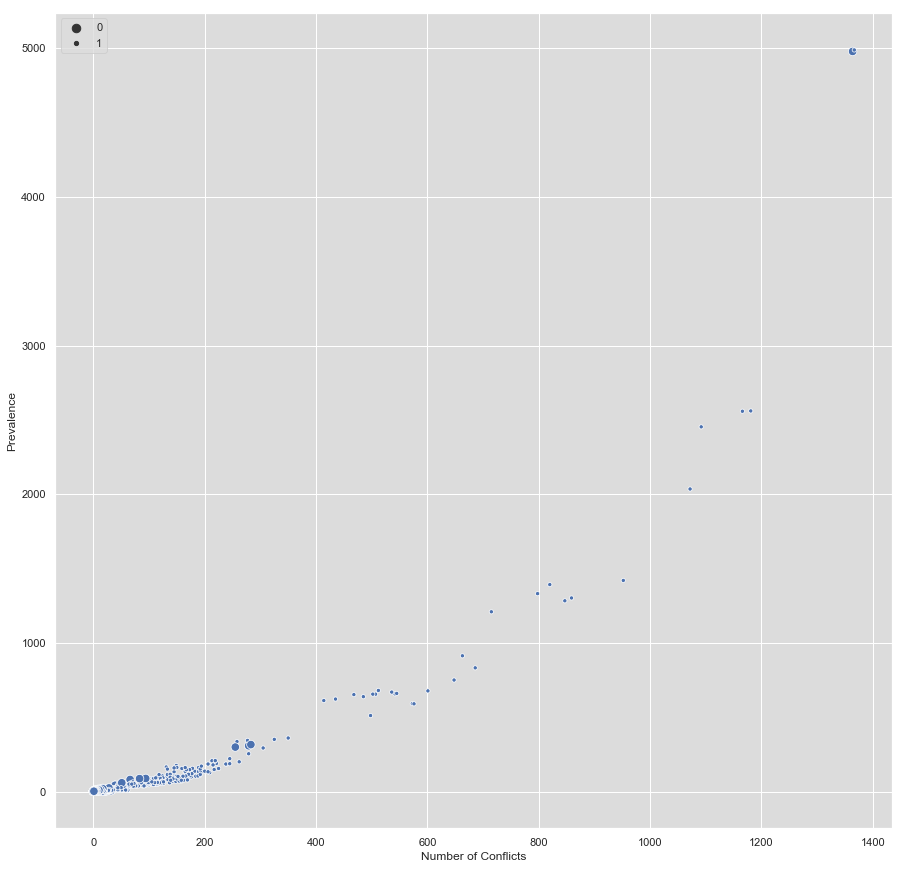

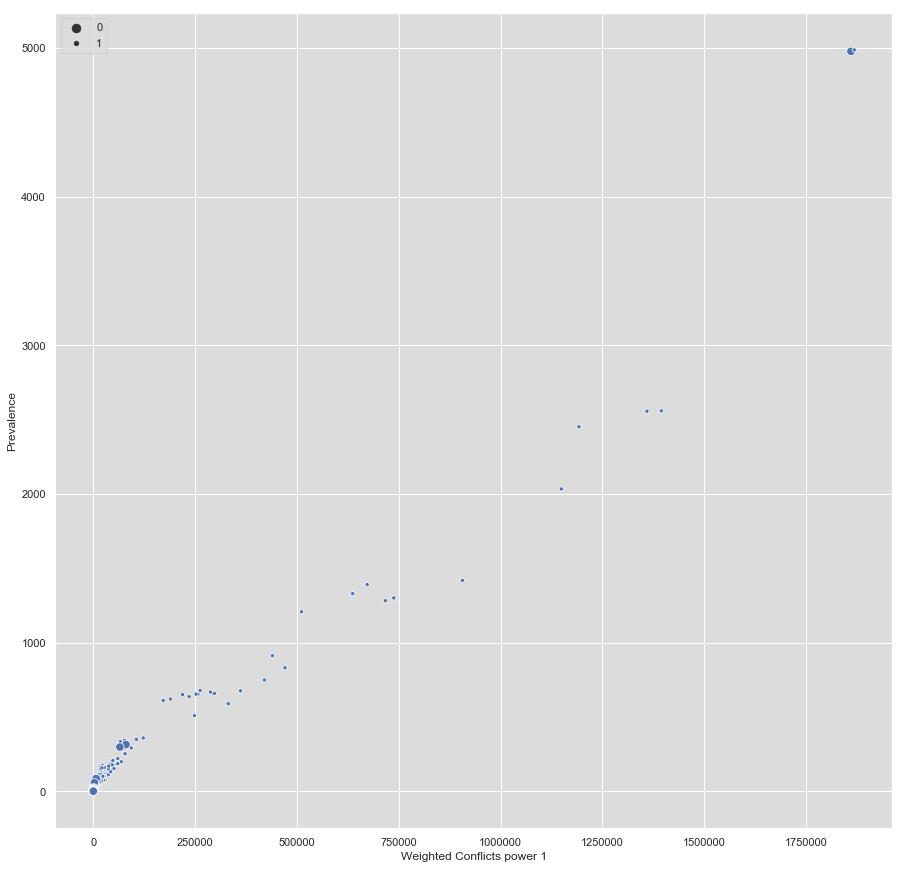

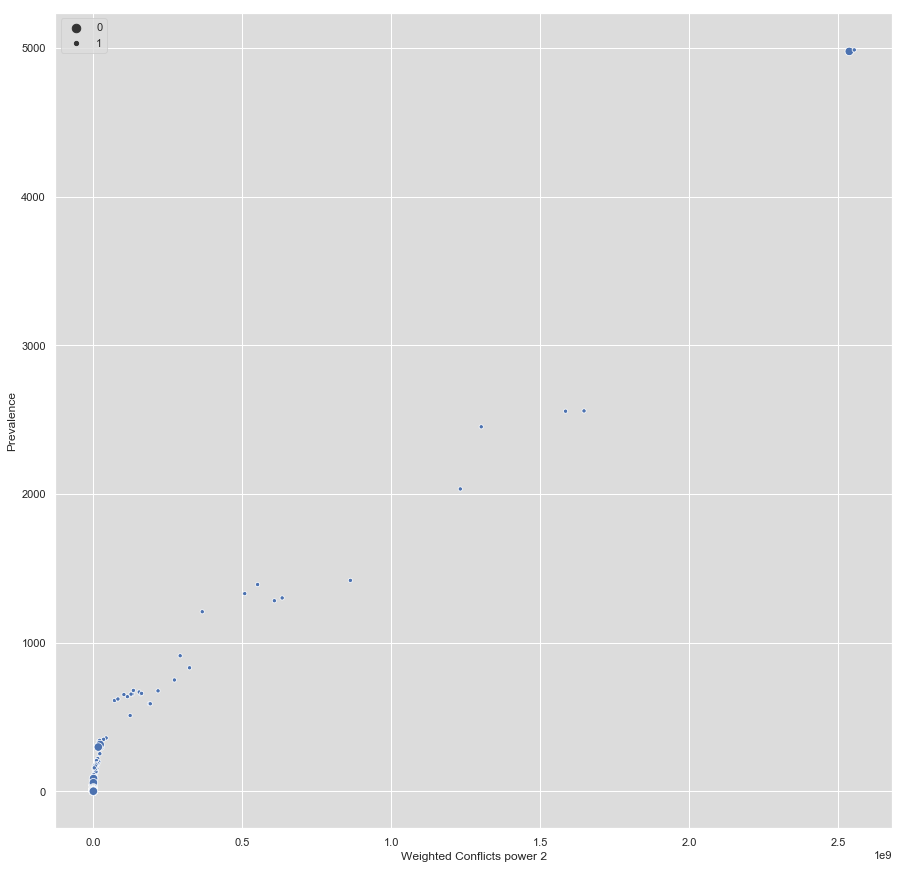

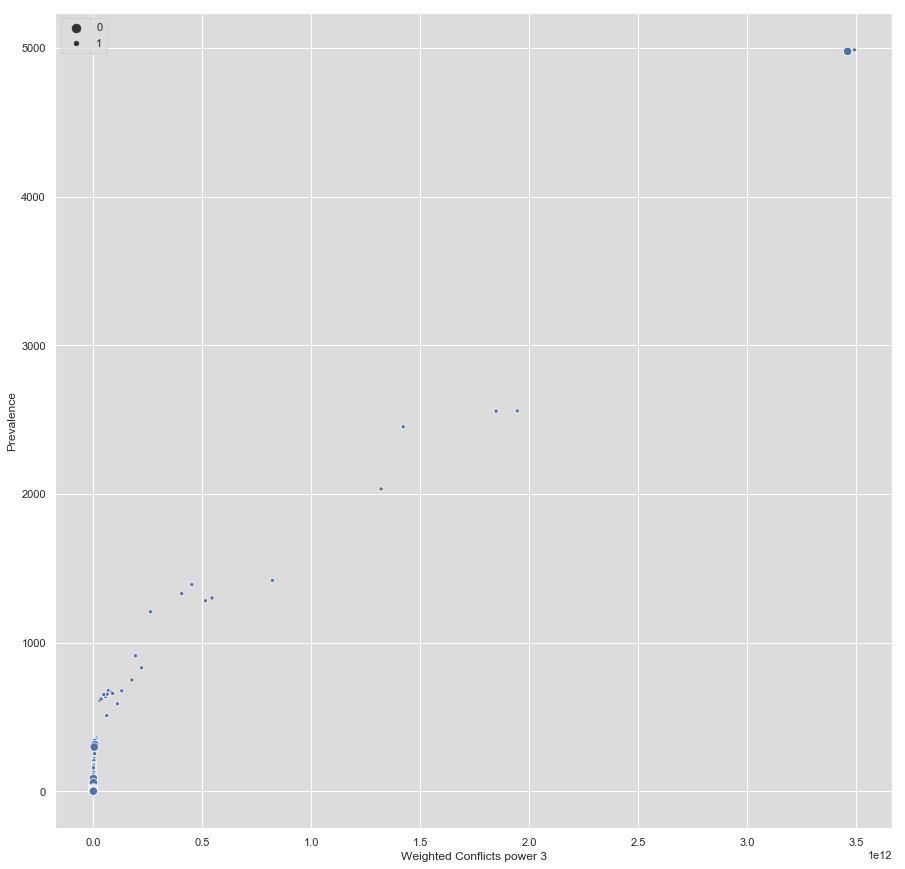

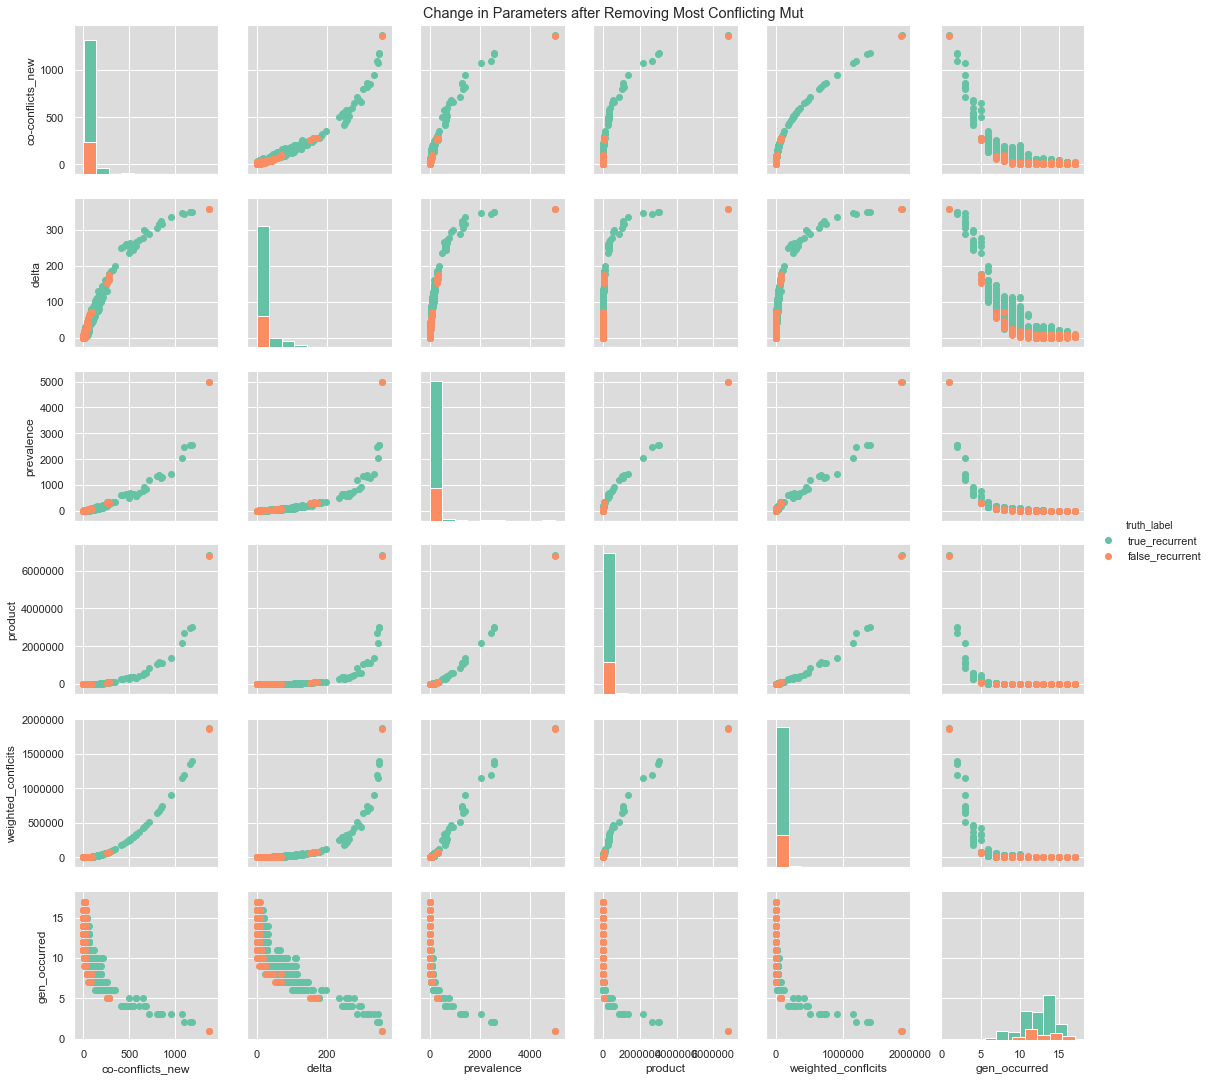

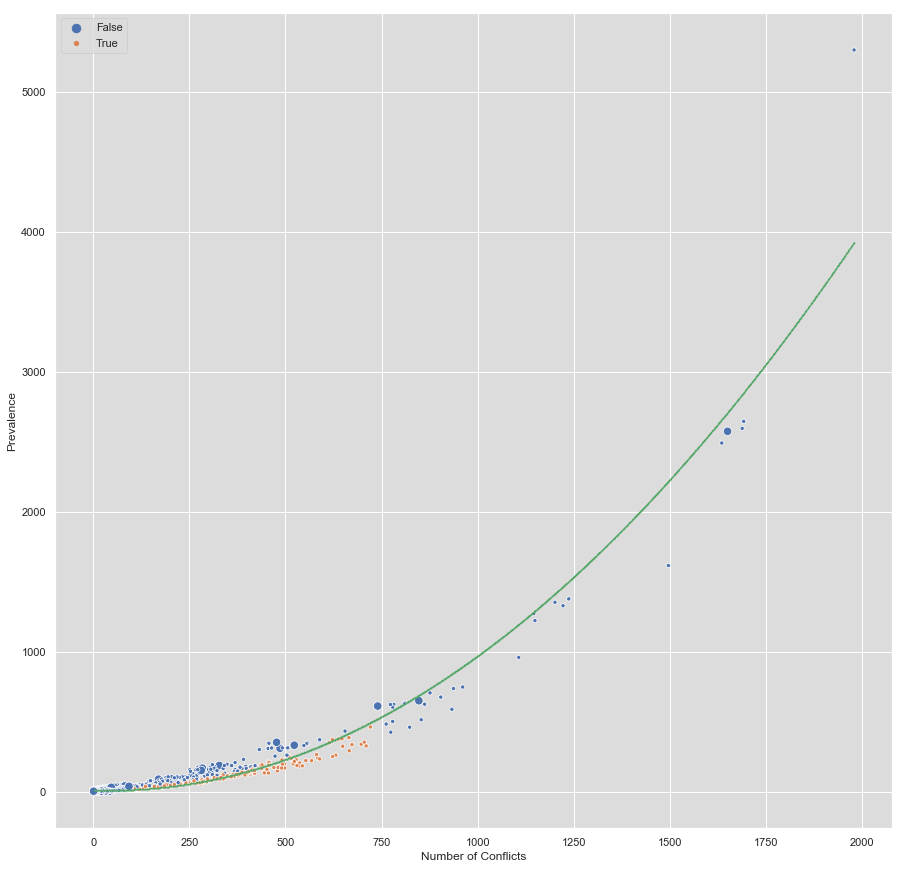

Percent truly identified as bad: 100.0
Proportion of total eliminated:  15.808170515097691
[  7.   6.   6. ...,  14.  15.  15.]


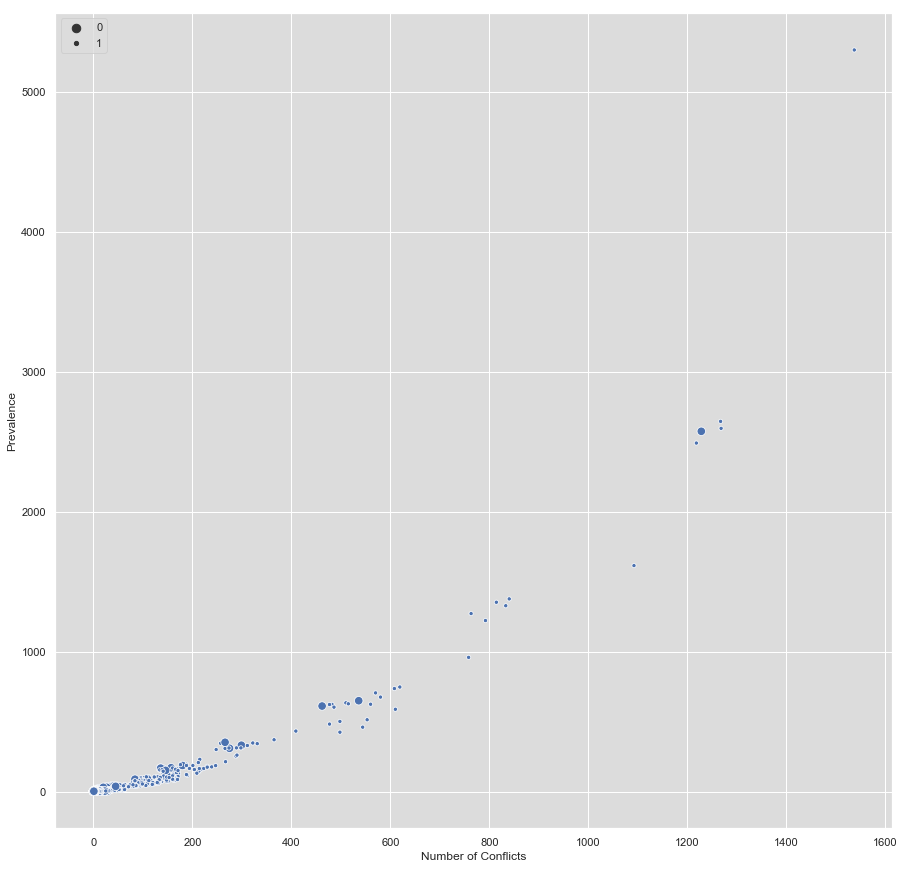

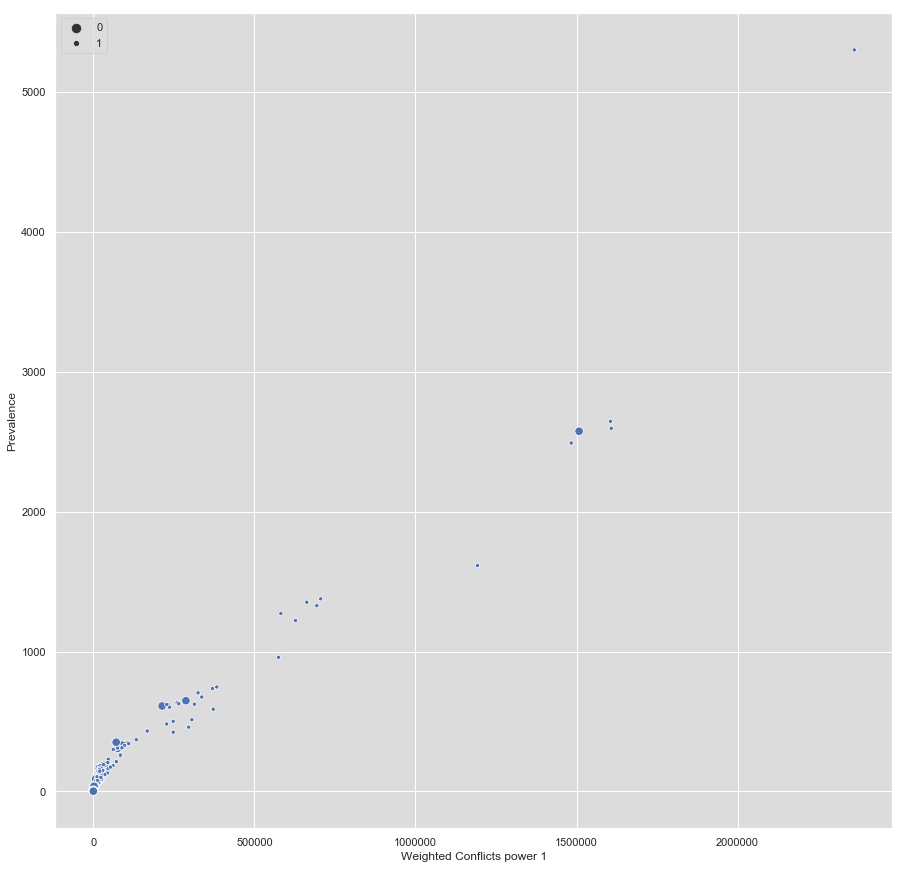

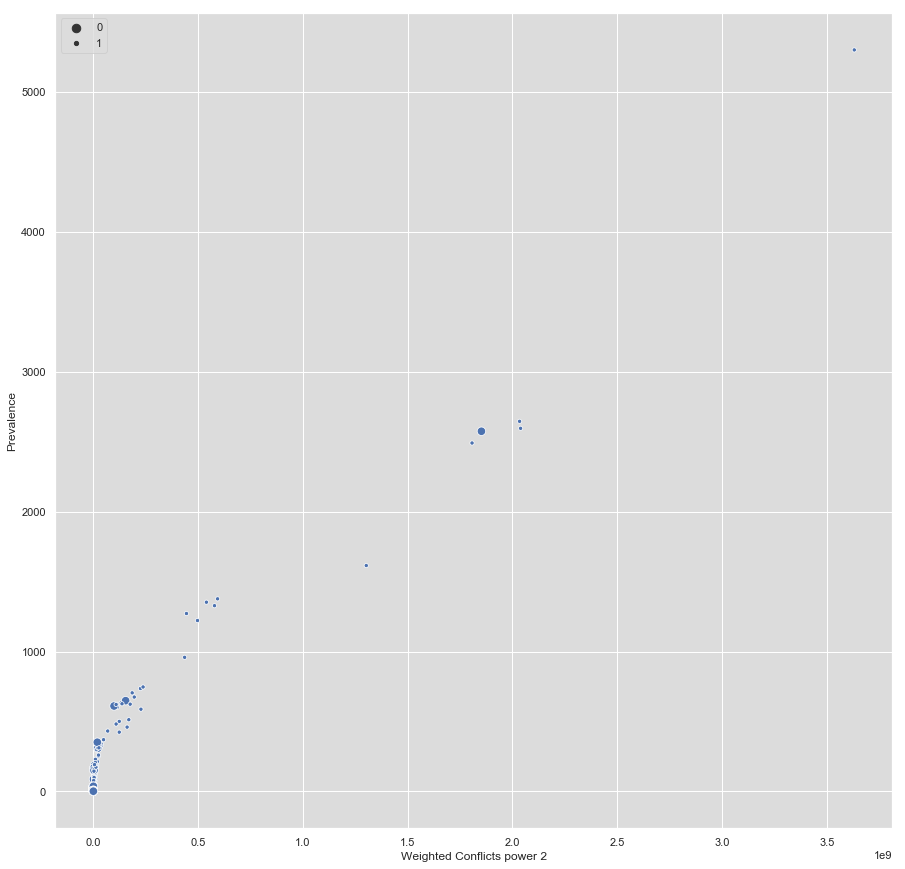

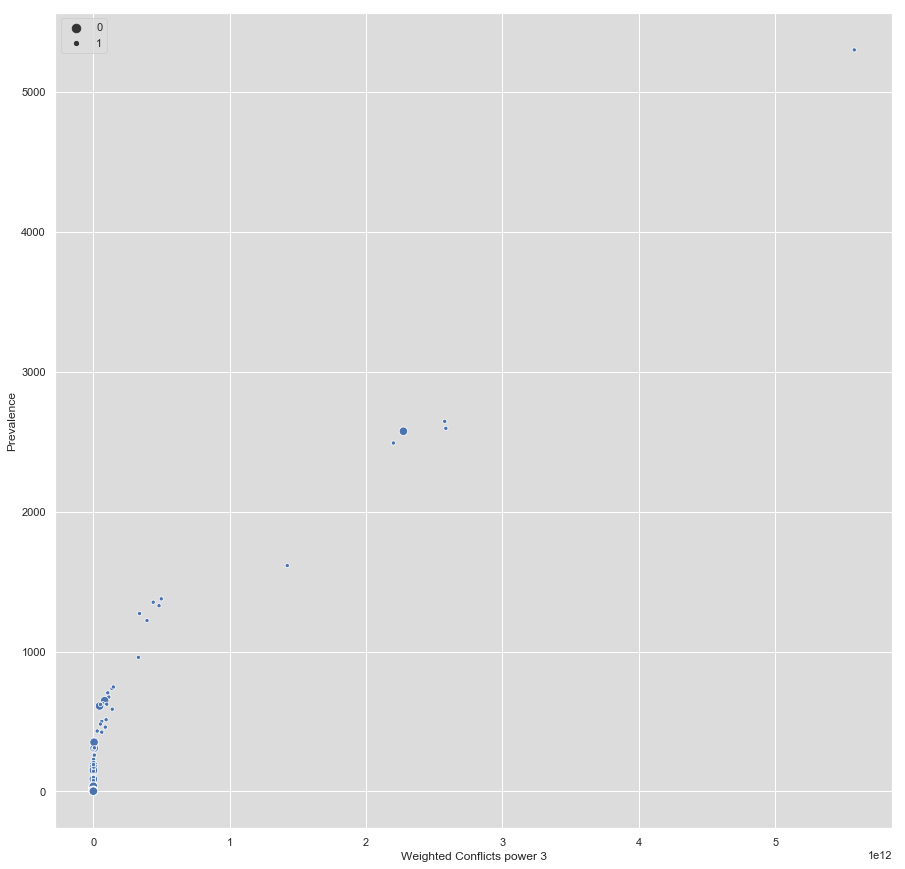

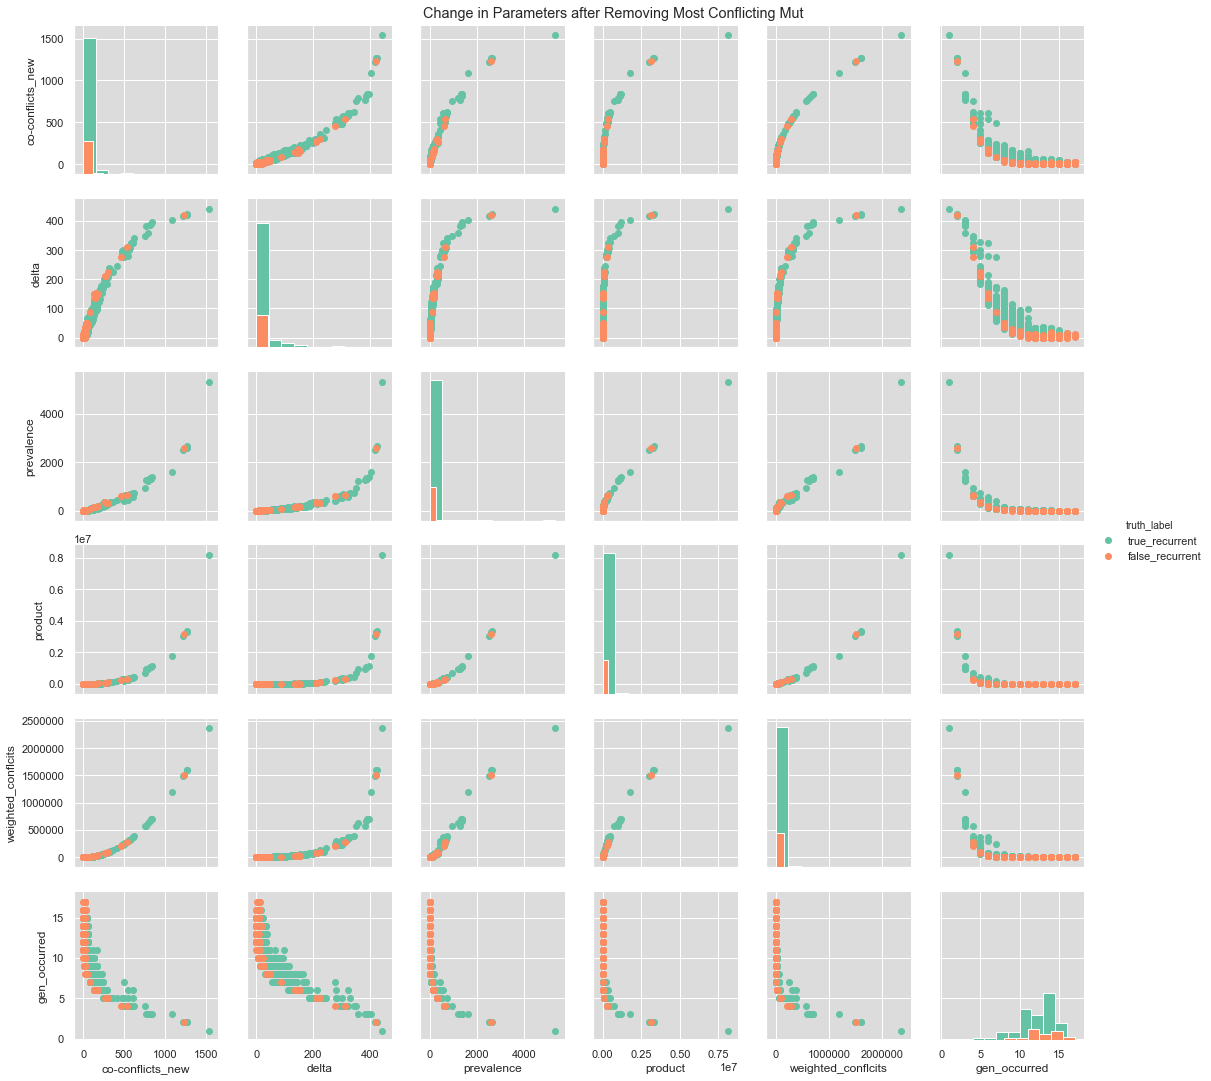

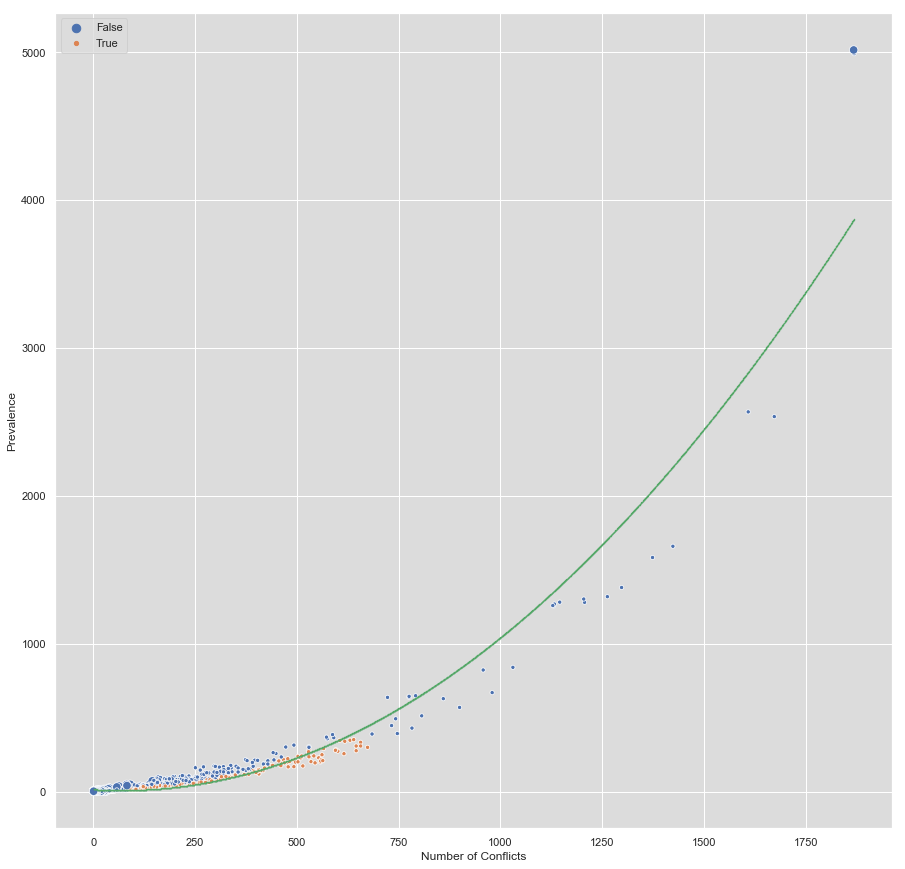

Percent truly identified as bad: 100.0
Proportion of total eliminated:  12.908961593172119
[  9.   4.   6. ...,  11.  14.  15.]


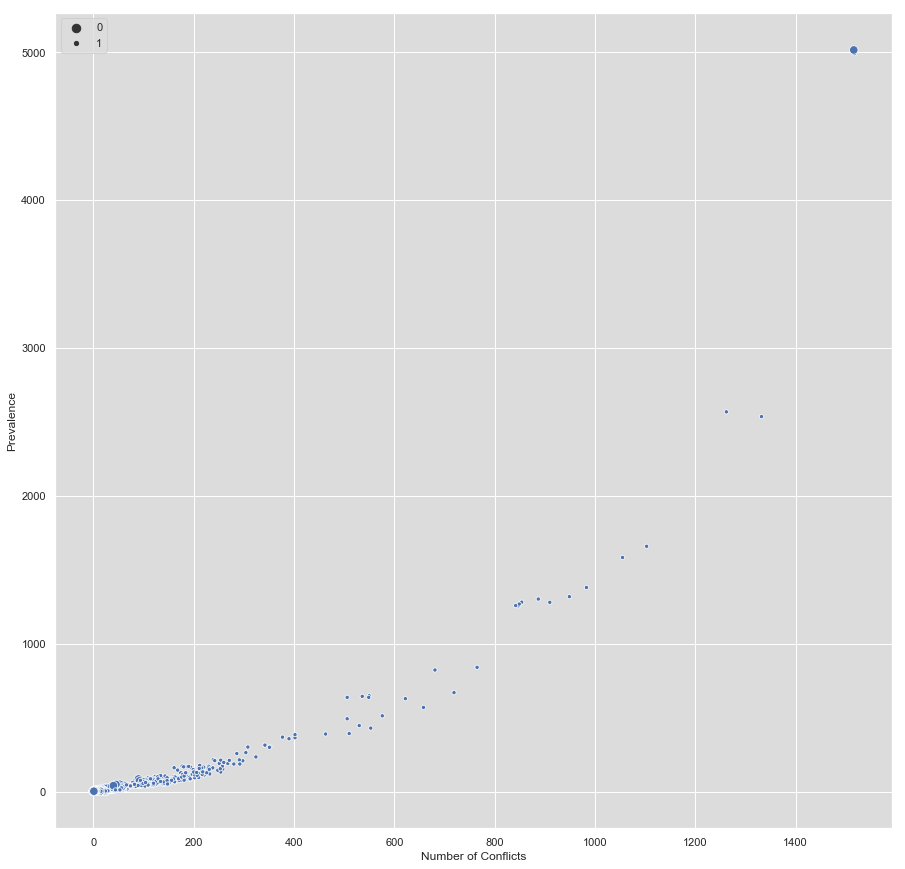

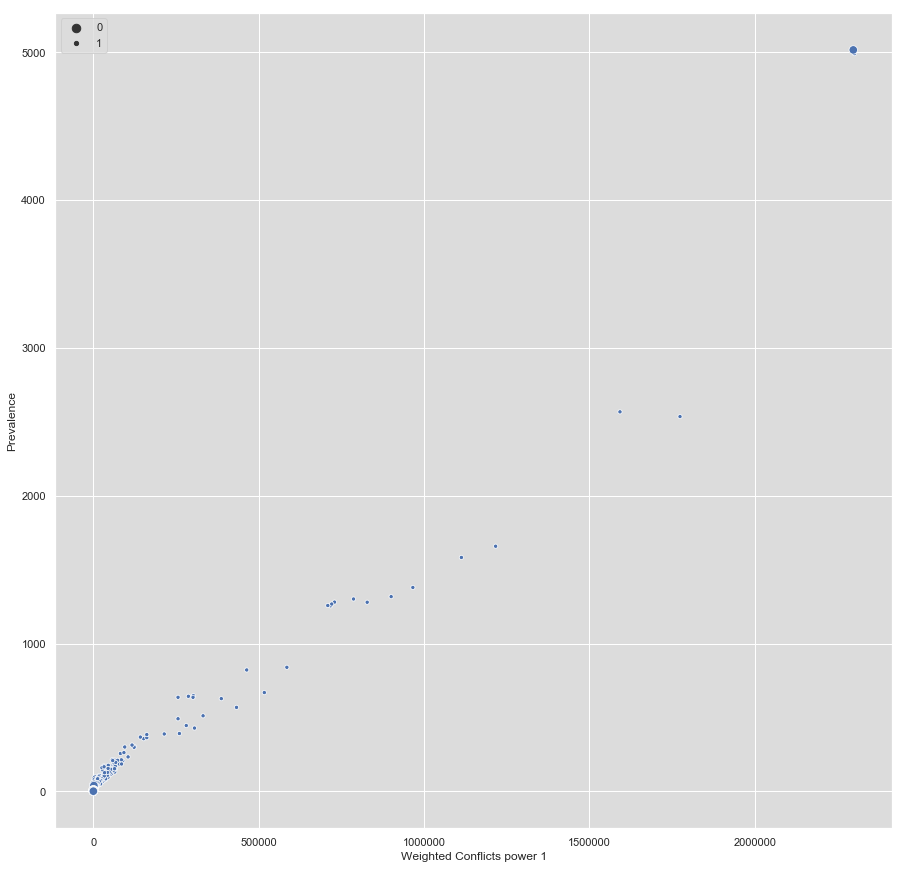

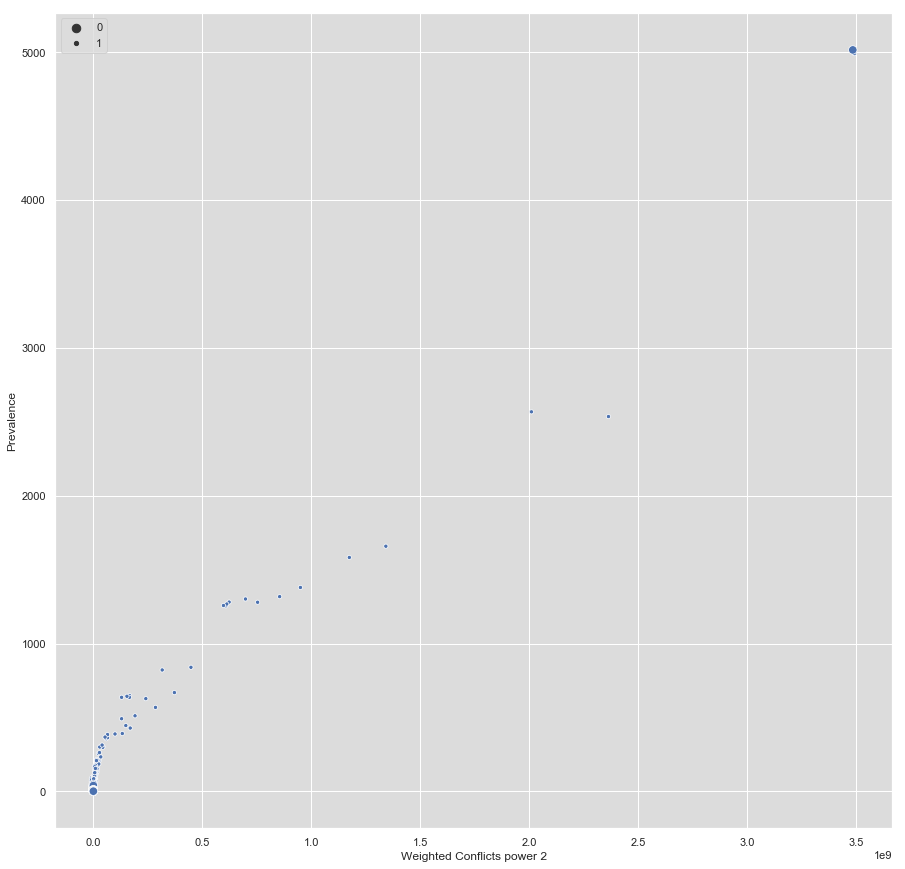

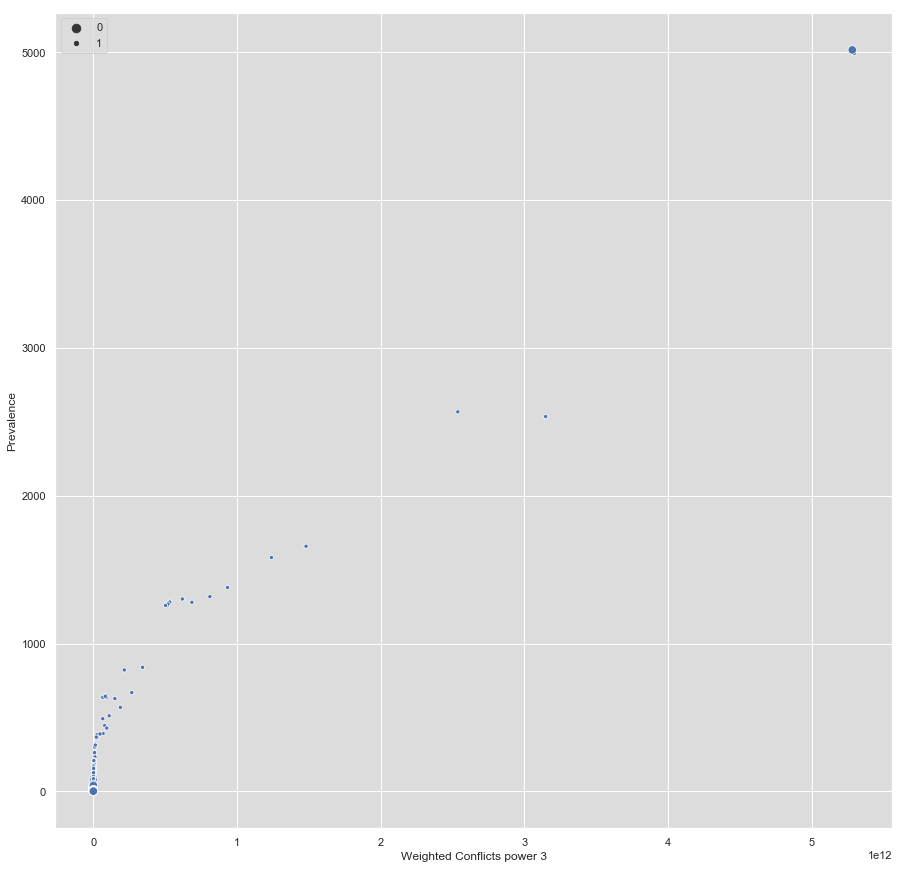

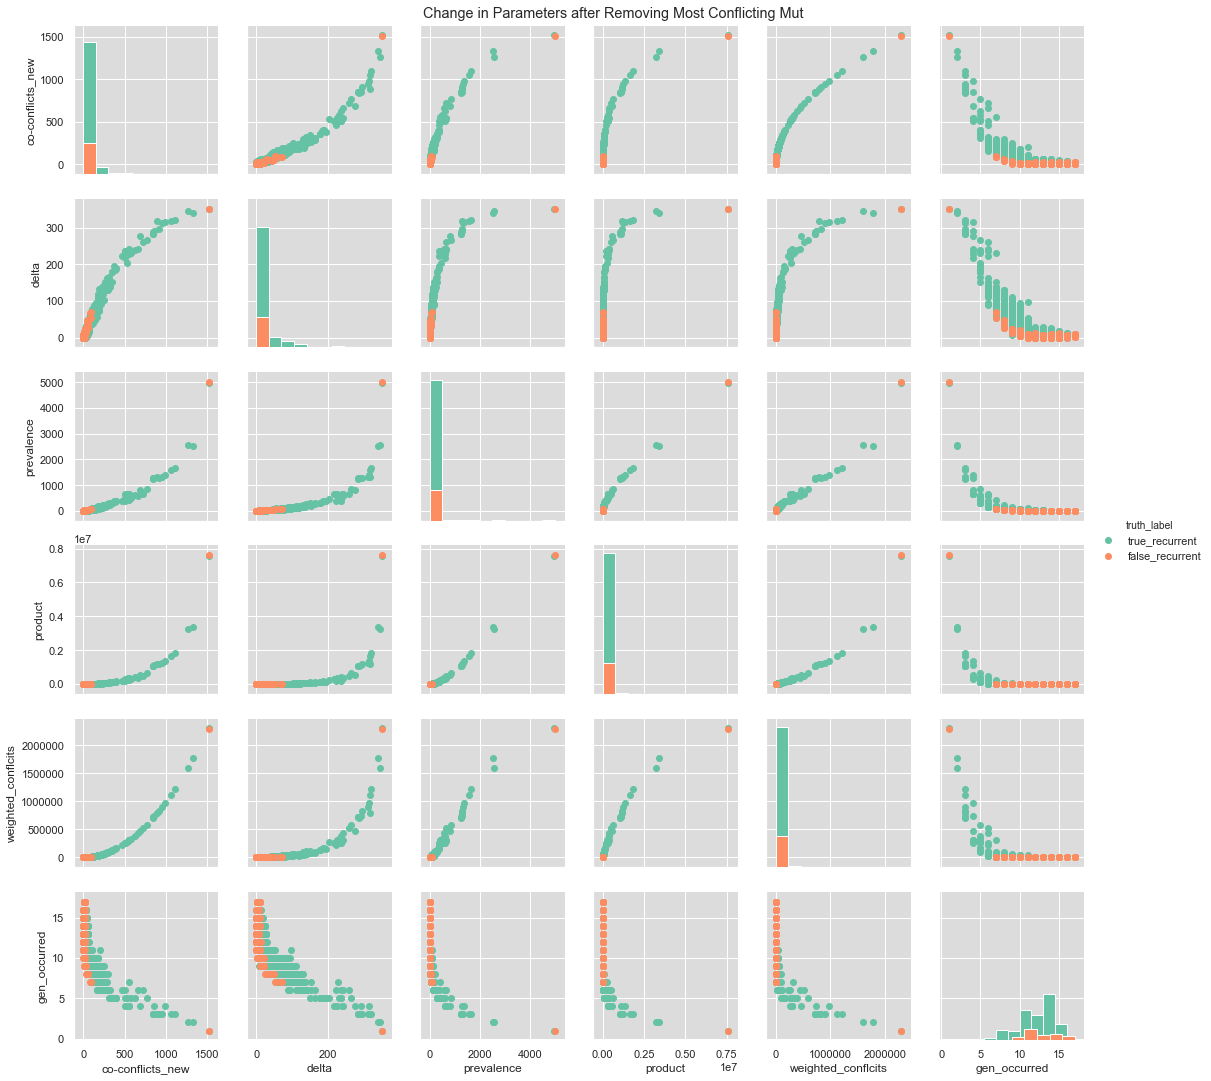

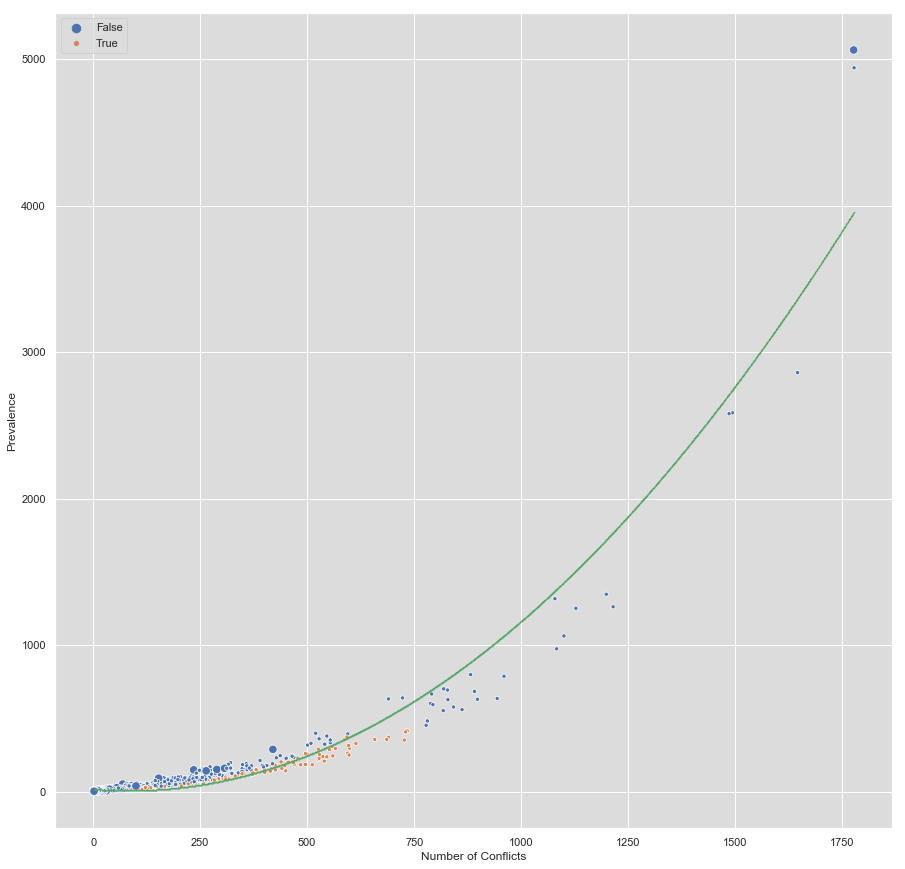

Percent truly identified as bad: 100.0
Proportion of total eliminated:  10.637509266123054
[  5.   7.   6. ...,  15.  14.  11.]


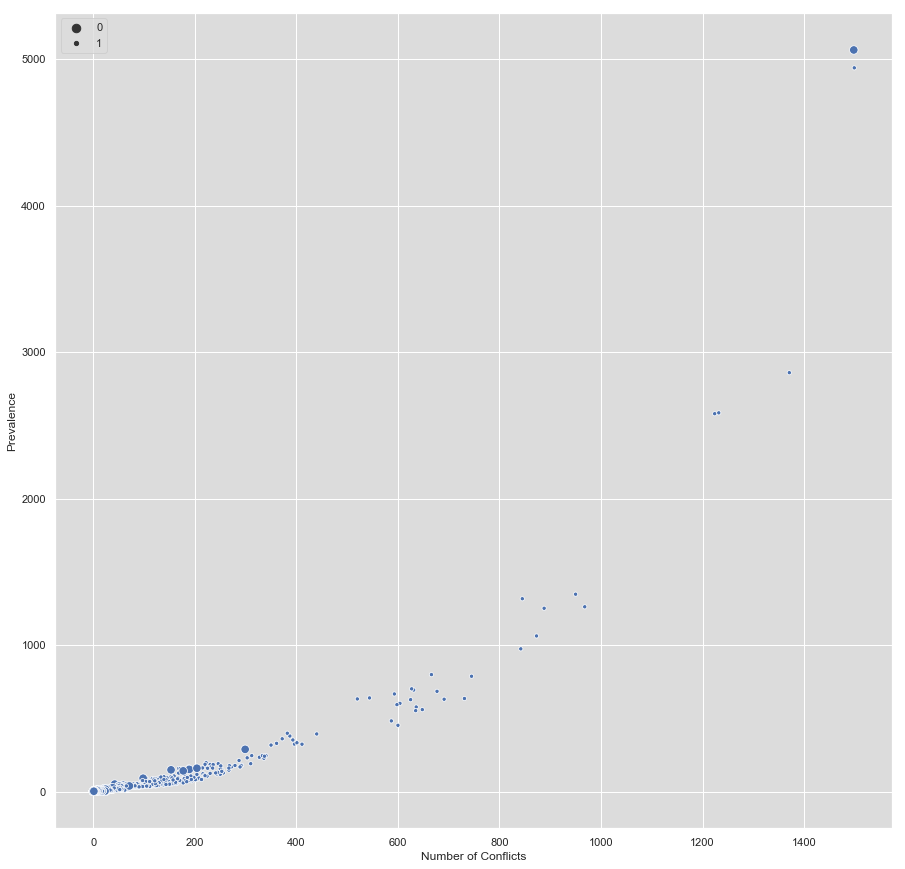

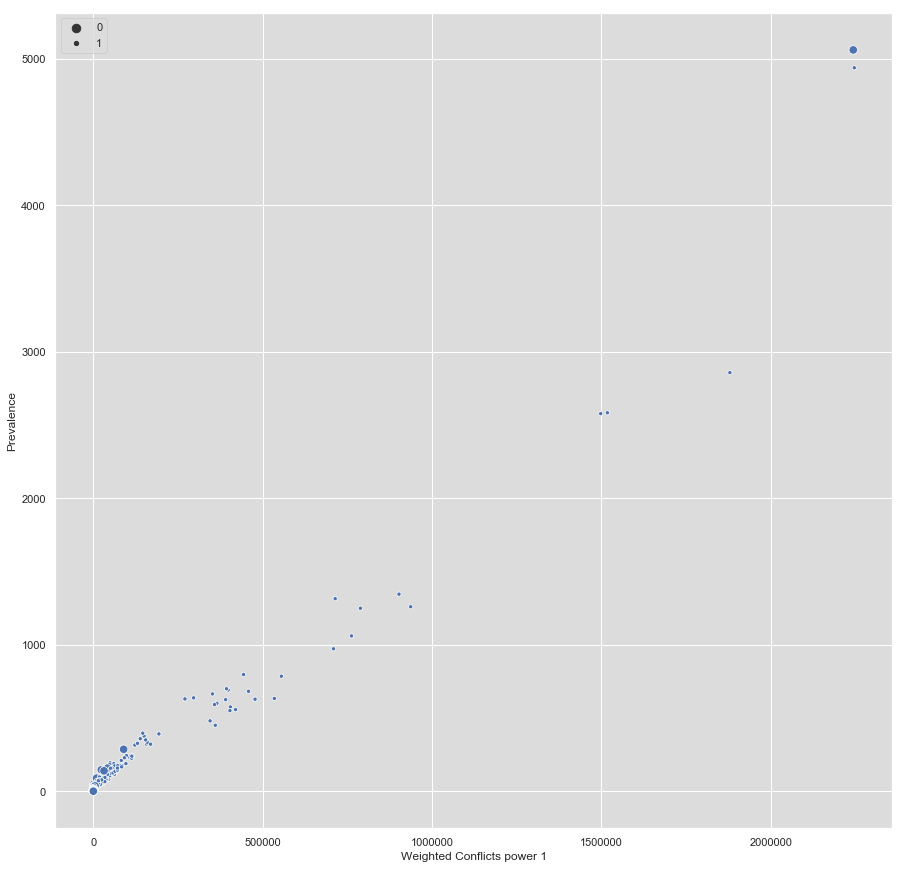

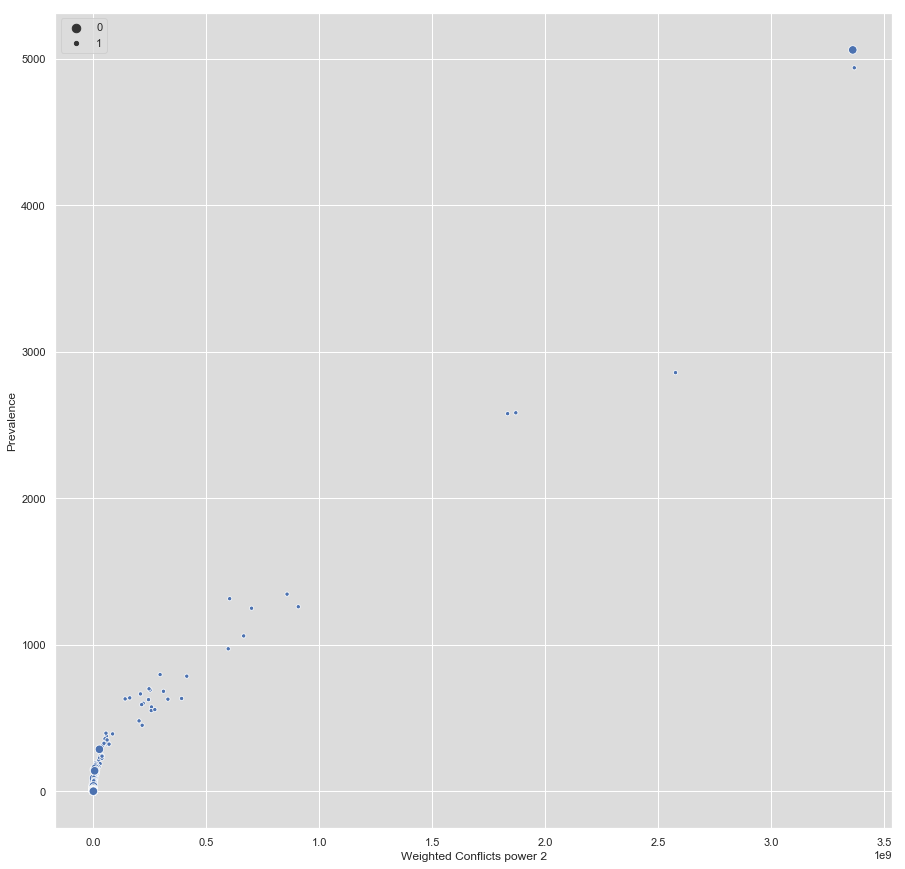

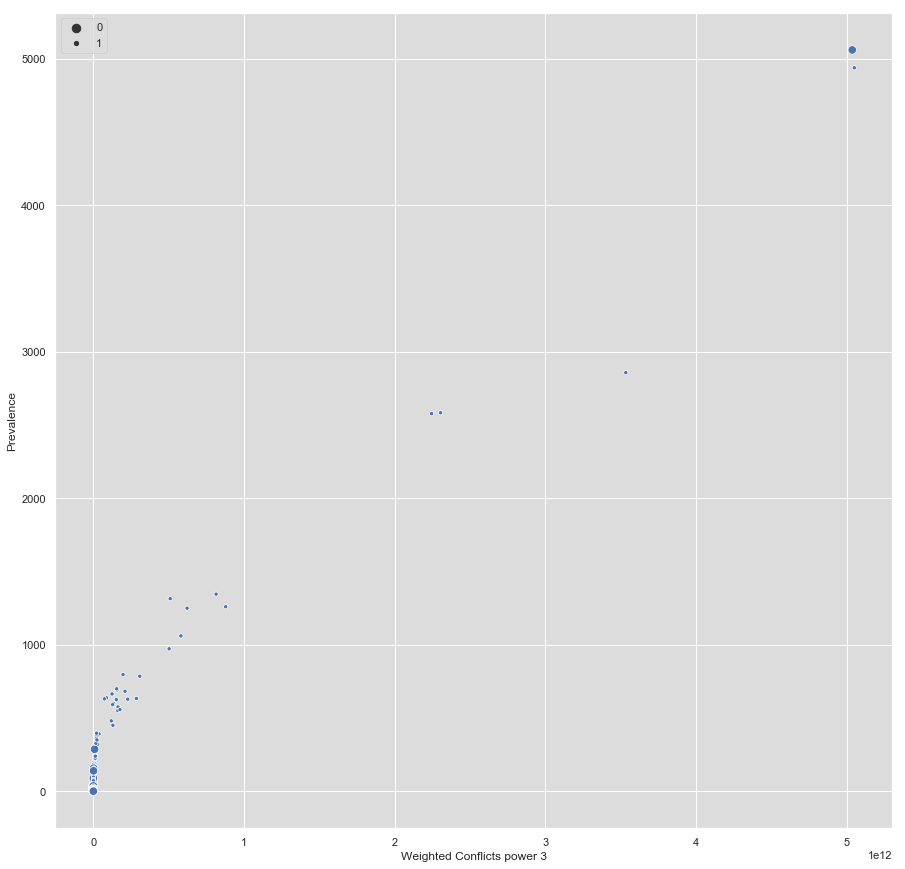

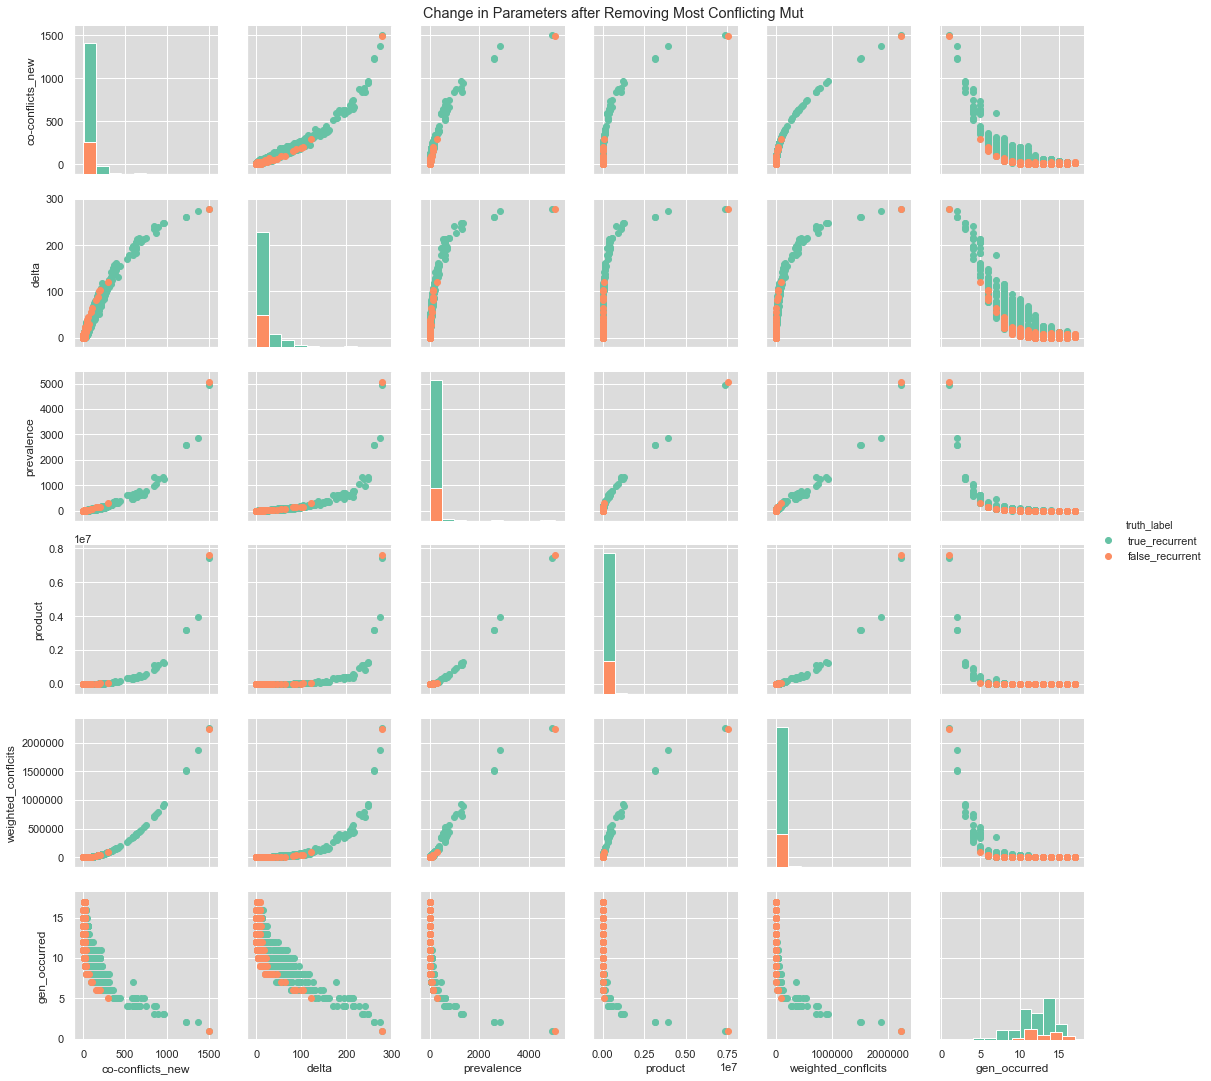

In [15]:
for enum, simulation in enumerate(simulation_list[:-1]):
    
    X = simulation.get_conflict_matrix().sum(0)
    Y = simulation.get_prevalance_tape()
    ix = np.array(simulation.get_truth_tape())==0

    coefs = simulation.random_attr['full_reg_coef']
    new_line = np.polyval(coefs, X)
    
    std_dev = np.std(np.abs(Y-new_line))
    bad_muts = Y < new_line + 0.5*std_dev
    
    # Constrain these to only those within the main 10-90 percent 
    q10, q90 = np.percentile(X, [75, 99])

    middleX = (X > q10)*(X < q90) 
    bad_muts = bad_muts * middleX
    
    if enum < 10:
        plt.figure(figsize=(15,15))
        sns.scatterplot(X, Y, hue=bad_muts, size=np.array(simulation.truth_tape))
        new_x = np.linspace(min(X), max(X), num=np.size(X))
        new_line = np.polyval(coefs, new_x)
        plt.scatter(new_x, new_line, c='g', marker='^', s=0.2)
        plt.xlabel('Number of Conflicts')
        plt.ylabel('Prevalence')
        plt.show()
        plt.close()
    
    # How many identified as bad muts are bad muts?
    
    bad_identified = np.array(simulation.truth_tape)[bad_muts]
    print('Percent truly identified as bad:', 100*bad_identified.sum()/bad_identified.shape[0])
    print('Proportion of total eliminated: ', 100*bad_identified.shape[0]/X.shape[0])
    
    ## What does the conflict matrix look like after removing these?
    
    # Get the indices of those mutations identified as recurrent
    bad_ix = np.sort(np.where(bad_muts)[0])[::-1]
    
    conflict_matrix = simulation.get_conflict_matrix()
    truth = simulation.get_truth_tape()
    first_gen_tape = copy.deepcopy(simulation.first_gen_tape)
    
    print(first_gen_tape)
    prevalence_tape = simulation.get_prevalance_tape()
    conflicts = conflict_matrix.sum(0)
    removed_truth = []
    
    for max_ix in bad_ix:
        conflict_matrix = np.delete(conflict_matrix, max_ix, axis=0)
        conflict_matrix = np.delete(conflict_matrix, max_ix, axis=1)

        # What mutation does this index map to?
        removed_truth.append(truth.pop(max_ix))


        first_gen_tape = np.delete(first_gen_tape, max_ix, axis=0)
        prevalence_tape = np.delete(prevalence_tape, max_ix, axis=0)
        conflicts = np.delete(conflicts, max_ix, axis=0)

    # How has removing this mutation affected the number of conflicts for true vs false recurrent mutations 
    new_conflicts = conflict_matrix.sum(0)

    delta = conflicts - new_conflicts

    df = {'truth_label': ['true_recurrent' if i else 'false_recurrent' for i in truth ],  
           'co-conflicts_new':new_conflicts,'delta':delta, 'prevalence': prevalence_tape}
    df = pd.DataFrame(df)

    df['product'] = df['prevalence']*df['co-conflicts_new']
    df['weighted_conflcits'] = (conflict_matrix*conflict_matrix.sum(0)).sum(0)
    df['gen_occurred'] = first_gen_tape
    pd.melt(df)

    if enum < 10:
        # Plot the prevalence vs co-conflicts after removing this set
        X = conflict_matrix.sum(0)
        Y = prevalence_tape
        
        plt.figure(figsize=(15,15))
        sns.scatterplot(X, Y, size=np.array(truth))
        plt.ylabel('Prevalence')
        plt.xlabel('Number of Conflicts')
        plt.show()
        plt.close()
                
        for sq in range(1,4):
            X = conflict_matrix.sum(0)
            weighted_X = (conflict_matrix*conflict_matrix.sum(0)**sq).sum(0)

            plt.figure(figsize=(15,15))
            sns.scatterplot(weighted_X, Y, size=np.array(truth))
            plt.ylabel('Prevalence')
            plt.xlabel('Weighted Conflicts power {0}'.format(sq))
            plt.show()
            plt.close()

        g = sns.PairGrid(df, hue = 'truth_label', palette="Set2")
        g.map_diag(plt.hist)
        g.map_offdiag(plt.scatter)
        g.add_legend()
        g.fig.suptitle("Change in Parameters after Removing Most Conflicting Mut", y=1) # y= some height>1
        plt.show()
        plt.close()


    

In [ ]:
simulation.get_first_gen_tape()

In [ ]:
## Which mutations are the misidentified mutations conflicting with?

# Weight mutations by whether they have many co-conflicts. 
for simulation in simulation_list[:-1]:
    X = simulation.get_conflict_matrix()
    X_sum = X.sum(0)
    
    weighted_X = (X * X_sum).sum(0)
    Y = simulation.get_prevalance_tape()
    
    plt.figure(figsize=(15,15))
    sns.scatterplot(weighted_X, Y, hue=np.array(simulation.truth_tape))
    plt.xlabel('Weighted Number of Conflicts')
    plt.ylabel('Prevalence')
    plt.show()
    plt.close()

### Iterative Removal Process

In [ ]:
def iterative_removal(conflict_matrix, truth, prevalence_tape, first_gen_tape, num_recur_tape, all_conflicting):
    conflict_matrix = copy.deepcopy(conflict_matrix)
    truth = copy.deepcopy(truth)
    prevalence_tape = copy.deepcopy(prevalence_tape)
    first_gen_tape = copy.deepcopy(first_gen_tape)
    num_recur_tape = copy.deepcopy(num_recur_tape)
    mutations = copy.deepcopy(all_conflicting)
    
    removed = []
    removed_truth = []
    eliminated_truth = []
    first_good_mut = []
    first_good_mut_by_product = []
    
    total_muts = conflict_matrix.shape[0]
    print('Starting with {0} candidate recurrent mutations'.format(conflict_matrix.shape[0]))
    while conflict_matrix.shape[0] > 0:
        conflicts = conflict_matrix.sum(0)

        # How long until we remove a good mutation 
        sortIx = conflicts.argsort()[::-1]
        first_good_mut.append(np.where(np.array(truth)[sortIx]==0)[0][0])

        product = conflicts*prevalence_tape
        sortIx = product.argsort()[::-1]
        first_good_mut_by_product.append(np.where(np.array(truth)[sortIx]==0)[0][0])

        # Remove the mutation with the maximum number of conflicts
        conflicts = conflict_matrix.sum(0)
        max_ix = np.argmax(conflicts)
        conflict_matrix = np.delete(conflict_matrix, max_ix, axis=0)
        conflict_matrix = np.delete(conflict_matrix, max_ix, axis=1)
        # What mutation does this index map to?
        removed.append(mutations.pop(max_ix))
        removed_truth.append(truth.pop(max_ix))

#         if not removed_truth[-1]:
#             print('Removed a not-recurrent mutation!')

        first_gen_tape = np.delete(first_gen_tape, max_ix, axis=0)
        prevalence_tape = np.delete(prevalence_tape, max_ix, axis=0)
        num_recur_tape = np.delete(num_recur_tape, max_ix, axis=0)
        conflicts = np.delete(conflicts, max_ix, axis=0)

        # How has removing this mutation affected the number of conflicts for true vs false recurrent mutations 
        new_conflicts = conflict_matrix.sum(0)

        delta = conflicts - new_conflicts

        df = {'truth_label': ['true_recurrent' if i else 'false_recurrent' for i in truth ],  
               'co-conflicts_new':new_conflicts,'delta':delta, 'prevalence': prevalence_tape} #, 'first_occur': first_gen_tape, 'num_recur': num_recur_tape}
        df = pd.DataFrame(df)

        df['product'] = df['prevalence']*df['co-conflicts_new']
        df['div'] = df['co-conflicts_new']/df['prevalence']
        pd.melt(df)
        
        if len(removed) < 10:
            g = sns.PairGrid(df, hue = 'truth_label', palette="Set2")
            g.map_diag(plt.hist)
            g.map_offdiag(plt.scatter)
            g.add_legend()
            g.fig.suptitle("Change in Parameters after Removing Most Conflicting Mut", y=1) # y= some height>1
            plt.show()
            plt.close()

            df['co-conflicts_new'].hist(by=df['truth_label'])
            plt.suptitle('Number of Co-occuring Mutations after Removing {0} Mutations'.format(len(removed)))
            plt.xlabel('Number of Co-conflicts')
            plt.ylabel('Number of Mutations')
            plt.show()
            plt.close()

        # Remove rows, columns in conflict matrix with no conflicts
        no_conflict = np.where(conflict_matrix.sum(0)==0)[0][::-1] 
        #Reverse this so we can delete elements without messing up order

        for max_ix in no_conflict:
            conflict_matrix = np.delete(conflict_matrix, max_ix, axis=0)
            conflict_matrix = np.delete(conflict_matrix, max_ix, axis=1)

            eliminated_truth.append(truth.pop(max_ix))
            mutations.pop(max_ix)
            
#             if eliminated_truth[-1]:
#                 print('Eliminated a recurrent mutation!')

            first_gen_tape = np.delete(first_gen_tape, max_ix, axis=0)
            prevalence_tape = np.delete(prevalence_tape, max_ix, axis=0)
            num_recur_tape = np.delete(num_recur_tape, max_ix, axis=0)
            conflicts = np.delete(conflicts, max_ix, axis=0)

    plt.figure()
    plt.title('Removed_truth')
    plt.plot(np.arange(len(removed_truth)), removed_truth)
    plt.show()
    plt.close()
    
    plt.figure()
    plt.title('Eliminated_truth: {0:2f}%'.format(100*len(eliminated_truth)/total_muts ))
    plt.plot(np.arange(len(eliminated_truth)), eliminated_truth)
    plt.show()
    plt.close()
    
    return removed

In [ ]:
removed = iterative_removal(conflict_matrix, truth, prevalence_tape, first_gen_tape, num_recur_tape, all_conflicting)

In [ ]:
removed

### Actually nan-out recurrent mutations

In [ ]:
final_cells_clean = copy.deepcopy(pd.DataFrame(subsampled_record[-1]))
for (col, edit) in removed:
    ix = (final_cells_clean[col]==edit)
    # Remove this edit (no need to use it again)
    final_cells_clean.loc[ix, col] = np.nan
    
final_cells_clean.head(2)

### Construct greedy tree using cleaned mutations

In [ ]:
final_cells_clean['Label'] = '1'
final_cells_clean_labeled = split_tree(final_cells_clean)

In [ ]:
final_cells_clean_labeled

### Compute triplets correct

In [ ]:
compute_triplets_correct(final_cells_clean_labeled, subsampled_ix, sample_size = 1000)

### Is our tree building method just terrible? Is the triplets correct metric wrong?

#### Remove all TRUE recurrent mutations and see what happens

In [ ]:
final_cells_true = copy.deepcopy(pd.DataFrame(subsampled_record[-1]))
for (col, edit) in recurring_edits.keys():
    ix = (final_cells_true[col]==edit)
    # Remove this edit (no need to use it again)
    final_cells_true.loc[ix, col] = np.nan
    
final_cells_true.head(2)


In [ ]:
final_cells_true['Label'] = '1'
final_cells_true = split_tree(final_cells_true)


In [ ]:
compute_triplets_correct(final_cells_true, subsampled_ix, sample_size = 1000)

## Things to do:

1. Debug triplets correct metric 
2. Figure out why neighbor joining is crashing 
3. Try Camin-Sokal 
4. When we eliminate recurrent mutations, what is the generation/ how many cells is it present in? (prevalence)?

In [ ]:
import scipy
data = scipy.spatial.distance.pdist(final_cells.values, metric='hamming')

In [ ]:
from skbio import DistanceMatrix
from skbio.tree import nj

dm = DistanceMatrix(data)



In [ ]:
def prob_no_muts(subtree_height, p_edit, p_mut, memo_table):
    """
    For a given target site and mutation character, compute the probability that a subtree of given height
    contains no instances of that mutation.
    
    p[d] = p_edit * (1-p_mut) + (1-p_edit)*p[d+1]^2 
    leaf case: p[d+1] = 1
    """
    if subtree_height in memo_table:
        return memo_table[subtree_height], memo_table
    
    if subtree_height == 0:
        ans = p_edit*(1-p_mut) + (1-p_edit)
    else: 
        ans, memo_table = prob_no_muts(subtree_height - 1, p_edit, p_mut, memo_table)
        ans = p_edit*(1-p_mut) + (1-p_edit)*(ans**2)  
    
    memo_table[subtree_height] = ans 
    return ans, memo_table

MAX_HEIGHT = 10
d = 5
p_edit = 0.02
p_mut = 1/250

# Compute the overall probability of a specific mutation at depth d (estimated from the prevalence prev) :

## FOR A GIVEN SITE AND A GIVEN MUTATION 

# Compute the probability that the specific mutation occurs in NONE of the offshoot trees:
memo_table ={}
running_prob = 1
for height in range(0, d):
    ans, memo_table = prob_no_muts(MAX_HEIGHT - height, p_edit, p_mut, memo_table)
    # We also need to multiply this by the probability that this site was not occupied in any of its ancestors
    running_prob *= ans*(1-p_edit)**height

# Compute the probability that this mutation occurs in at least one of the offshoot trees
prob_offshoot = 1 - running_prob

# Compute the probability that this site is NOT blocked along the lineage leading up to and including A
prob_no_blocking = (1-p_edit)**(d+1)

# Compute the probability that any subtree contains the specific mutation 
ans, memo_table = prob_no_muts(MAX_HEIGHT - d, p_edit, p_mut, memo_table)
prob_subtree = 1 - ans

prob_mutation_conflicts = prob_offshoot*prob_no_blocking*prob_subtree

prob_mutation_conflicts


# HOW TO NOW GENERALIZE THIS TO ANY MUTATION
# What is the probability that any mutation occurs both in an offshoot and in the subtree?

# our probabilities are very very not independent sadly 



In [ ]:
x = 0.02*249/250 + 

In [ ]:
x = 0.02*249/250 + (1-0.02)*(x**2)
x

In [ ]:
memo_table

In [ ]:
prob_offshoot*prob_no_blocking*prob_subtree

# This is way too high :/

In [21]:
import plotly.graph_objects as go

import numpy as np
np.random.seed(1)

x = np.random.rand(100)
y = np.random.rand(100)

f = go.FigureWidget([go.Scatter(x=x, y=y, mode='markers')])

scatter = f.data[0]
colors = ['#a3a7e4'] * 100
scatter.marker.color = colors
scatter.marker.size = [10] * 100
f.layout.hovermode = 'closest'


# create our callback function
def update_point(trace, points, selector):
    c = list(scatter.marker.color)
    s = list(scatter.marker.size)
    for i in points.point_inds:
        c[i] = '#bae2be'
        s[i] = 20
        with f.batch_update():
            scatter.marker.color = c
            scatter.marker.size = s


scatter.on_click(update_point)

f

AttributeError: module 'plotly.graph_objs' has no attribute 'FigureWidget'

In [17]:
import ipywidgets

In [20]:
import plotly 
plotly.__version__

'4.3.0'